# **Set Up Environment**

###**Package Installation**

In [ ]:
# Install latest package versions (Potential conflicts but updated)
!pip install s3fs
!pip install boto3
!pip install arm_pyart
!pip install pygrib
!pip install pyhdf†
!pip install typing_extensions
!pip install imageio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.3/199.3 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 95.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 4.0.0 requires fsspec[http]<=2025.3.0,>=2023.1.0, but you have fsspec 2025.9.0 which is incompatible.
gcsfs 2025.3.0 requires fsspec==2025.3.0, but you have fsspec 2025.9.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 113.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 5.3 

In [ ]:
# Install specific package versions (No conflicts but potentially outdated)
# Last updated: MM-DD-YYYY




###**Authentication**

In [ ]:
from google.colab import drive

# Login to Google Drive
drive.mount('/content/drive')

# Set working directory to project path
project_path = '/content/drive/MyDrive/RadarReflectivityProject'
%cd $project_path

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/RadarReflectivityProject


###**Package Versions**

In [ ]:
'''
List exact versions and save a timestamped requirements file under Logs/environment
'''
import os, sys, subprocess

from datetime import datetime, timezone


def run(cmd):
    return subprocess.check_output(cmd, text=True).strip()


# ---------------------------------------------------
# Show interpreter & pip info (handy when reproducing)
py_ver = sys.version.split()[0]
pip_ver = run([sys.executable, "-m", "pip", "--version"])
print(f"Python: {py_ver}")
print(pip_ver)

# Get fully resolved pins (includes direct URL installs, editable pkgs, etc.)
lines = run([sys.executable, "-m", "pip", "freeze"]).splitlines()
lines = sorted(lines, key=lambda s: s.lower())

# Print a requirements-style block to the cell output
print("\n# ----- requirements.txt (pin everything) -----")
print("\n".join(lines))

# Optional: also print as 'pip install ...' lines to the output
print("\n# ----- pip install lines (optional) -----")
for line in lines:
    if line and not line.startswith("#"):
        print(f"pip install {line}")


# ---------------------------------------------------
# Save to Logs/environment with a timestamped filename
ts = datetime.now(timezone.utc).astimezone().strftime("%Y%m%d_%H%M%S%z")
out_dir = os.path.join("Logs", "environment")
os.makedirs(out_dir, exist_ok=True)
req_path = os.path.join(out_dir, f"requirements_{ts}.txt")

# Include header comments with environment info (pip ignores lines starting with '#')
header = [
    f"# Generated: {datetime.now(timezone.utc).astimezone().isoformat()}",
    f"# Python: {py_ver}",
    f"# {pip_ver}",
    "# -------------------------"
]
with open(req_path, "w") as f:
    f.write("\n".join(header + lines) + "\n")

print(f"\nWrote {req_path}")


Python: 3.12.11
pip 24.1.2 from /usr/local/lib/python3.12/dist-packages/pip (python 3.12)

# ----- requirements.txt (pin everything) -----
absl-py==1.4.0
absolufy-imports==0.3.1
accelerate==1.10.1
aiobotocore==2.24.2
aiofiles==24.1.0
aiohappyeyeballs==2.6.1
aiohttp==3.12.15
aioitertools==0.12.0
aiosignal==1.4.0
alabaster==1.0.0
albucore==0.0.24
albumentations==2.0.8
ale-py==0.11.2
alembic==1.16.5
altair==5.5.0
annotated-types==0.7.0
antlr4-python3-runtime==4.9.3
anyio==4.10.0
anywidget==0.9.18
argon2-cffi-bindings==25.1.0
argon2-cffi==25.1.0
arm_pyart==2.1.0
array_record==0.8.1
arrow==1.3.0
arviz==0.22.0
astropy-iers-data==0.2025.9.1.0.42.11
astropy==7.1.0
astunparse==1.6.3
atpublic==5.1
attrs==25.3.0
audioread==3.0.1
Authlib==1.6.3
autograd==1.8.0
babel==2.17.0
backcall==0.2.0
beartype==0.21.0
beautifulsoup4==4.13.5
betterproto==2.0.0b6
bigframes==2.18.0
bigquery-magics==0.10.3
bleach==6.2.0
blinker==1.9.0
blis==1.3.0
blobfile==3.0.0
blosc2==3.7.2
bokeh==3.7.3
boto3==1.40.30
Bottlenec

# **🟥 Build Full Dataset**

###**Filtering Logic**

####**Helper Functions**

In [ ]:
'''
General purpose helpers used across multiple modules
'''
import pyart
import s3fs
import numpy as np
import pandas as pd
import threading
import queue
import os
import io
import tarfile
import pickle
import re
import ctypes
import matplotlib
import matplotlib.pyplot as plt


from IPython import get_ipython
from multiprocessing import Manager
from IPython.display import display
from datetime import datetime, timedelta, date
from scipy.ndimage import label
from shapely.geometry import Point
from math import radians, cos, sin, asin, sqrt
from typing import List, Tuple, Optional, Dict
import pandas as pd
import numpy as np
import pyart



########################################################################### PLOTTING ###########################################################################



# Allow matplotlib to work concurrently
mgr = Manager()
raw_queue = mgr.Queue() # Workers write raw data here
fig_queue = mgr.Queue() # Plotter thread hands back completed Figure objects here
matplotlib.use("Agg")


def _save_plot(fig, plot_dir, func_name, stub, debug):
    try:
        import matplotlib.pyplot as plt
        if plot_dir:
            subdir = os.path.join(plot_dir, func_name)
            os.makedirs(subdir, exist_ok=True)
            name = stub or func_name
            out_path = os.path.join(subdir, f"{name}.png")
            fig.savefig(out_path, dpi=150, bbox_inches="tight")
            if debug:
                print(f"[{func_name}] saved debug plot -> {out_path}")
            plt.close(fig)
    except Exception as e:
        if debug:
            print(f"[{func_name}] saving/plotting failed: {e}")


def _plotter_loop():
    """
    NOTE -> DEPRECATED, but keep for backwards compat until refactoring is done.
    Decouple figure construction from main thread to eliminate blocking locks while plotting figures.
    """
    print("[_plotter_loop] Queue monitoring started")
    while True:
        item = raw_queue.get()
        if item is None:                # sentinel to shut down
            break

        # Unpack the item in the queue
        *payload, plot_type = item
        print(f"[_plotter_loop] Plotting figure for plot_type: {plot_type}")

        # Have the last "argument" in a queue's item determine the plot type
        if plot_type == 'level_three':
            T, R, echo_clean = payload
            fig = plt.figure()
            ax  = fig.add_subplot(projection='polar')
            ax.set_theta_zero_location('N')
            ax.set_theta_direction(-1)
            pcm = ax.pcolormesh(T, R, echo_clean, shading='flat')
            plt.colorbar(pcm, label='Echo Classification Code', ax=ax)
            ax.set_title('Radar Echo Classification (Polar View)')

            # Add processed fig to fig_queue
            fig_queue.put(fig)

        # EXAMPLE (add more elif blocks for new plot types)
        elif plot_type == 'contour':
            x, y, z = payload
            fig, ax = plt.subplots()
            cs = ax.contour(x, y, z)
            ax.clabel(cs)
            # And again, fig_queue.put(fig)



############################################################################# MISC. ###########################################################################



# Haversine distance (km) between two lon/lat points
def haversine(lon1, lat1, lon2, lat2):
    R = 6371.0  # Earth radius in km
    dlon = radians(lon2 - lon1)
    dlat = radians(lat2 - lat1)
    a = sin(dlat/2)**2 + cos(radians(lat1))*cos(radians(lat2))*sin(dlon/2)**2
    return 2*R*asin(sqrt(a))


def section_seperator(lines_to_print):
    for _ in range(lines_to_print):
      print()

# Helper: ensure directory exists
def _ensure_dir(path: str):
    if not os.path.isdir(path):
        os.makedirs(path, exist_ok=True)



######################################################################## RAM CLEANUP ########################################################################



def _safe_close(obj):
    # Best-effort close for things that may hold file handles or buffers
    for name in ("close", "shutdown", "stop", "terminate", "flush"):
        try:
            getattr(obj, name)()
            return
        except Exception:
            pass

def aggressive_memory_cleanup(locals_dict):
    # 1) Close plotting state (matplotlib holds a LOT)
    try:
        plt.close('all')
    except Exception:
        pass

    # 2) Shut down any executors/threads/queues you created
    for k, v in list(locals_dict.items()):
        # queues, threads, executors, file systems, netCDF datasets, s3fs/gcsfs, etc.
        try:
            _safe_close(v)
        except Exception:
            pass

    # 3) Drop large objects by name (customize this list for your code)
    big_names = [
        "lsr_df", "spc_df", "grs_df",
        "grouped", "linked_radar_df", "bboxed_df",
        "files", "full_df",
        "raw_queue", "plot_thread",
        # add anything else large that might linger (arrays, caches, etc.)
    ]
    for name in big_names:
        if name in locals_dict:
            locals_dict[name] = None

    # 4) Clear module-level caches if you have them
    for cache_name in [
        "_GRID_PLAN_CACHE",     # your own cache variable (example from your earlier code)
        "_s3fs", "_s3client",   # s3fs/boto (if you created globals)
    ]:
        if cache_name in globals():
            try:
                obj = globals()[cache_name]
                _safe_close(obj)
            except Exception:
                pass
            globals()[cache_name] = None

    # 5) Free TF/PyTorch contexts if they exist (safe no-ops if not installed)
    try:
        import tensorflow as tf
        tf.keras.backend.clear_session()
    except Exception:
        pass
    try:
        import torch
        torch.cuda.empty_cache()
        torch.cuda.ipc_collect()
    except Exception:
        pass

    # 6) Force Python GC
    gc.collect()
    gc.collect()  # call twice sometimes helps drop finalizers/cycles

    # 7) Ask glibc to return free arenas to the OS (Linux only; works on Colab)
    try:
        ctypes.CDLL("libc.so.6").malloc_trim(0)
    except Exception:
        pass





## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



KeyboardInterrupt: 

####**Filter LSR + SPC Data**

In [ ]:
import requests
import pandas as pd
import tempfile

from io import StringIO
from pathlib import Path
from datetime import datetime, date, time, timedelta
from IPython.display import display
from typing import Union


######################################################################## FILTER LSR DATA ###############################################################################


def load_raw_lsr(start: Union[date, datetime],
                 end:   Union[date, datetime],
                 debug: bool = False,
                 cache_dir: Union[str, Path] = "Datasets/surface_obs_datasets/lsr_reports",
                 force_refresh: bool = False) -> pd.DataFrame:
    """
    Pull raw Local Storm Reports (LSRs) from the IEM archive CSV service
    for each calendar-day between `start` and `end` (inclusive).

    Caching:
      - a cache CSV is saved as {cache_dir}/YYYYMMDD_YYYYMMDD.csv
      - if that file exists and force_refresh is False, it will be loaded and returned
      - corrupted cache files are removed and the fetch is retried

    Returns a DataFrame with columns:
      - time (UTC datetime of the exact report)
      - lat, lon (location of report)
      - gust (the reported magnitude, as float)
      - remarks (text comments, if any)
      - type (the original TYPETEXT)
    """
    cache_dir = Path(cache_dir)
    cache_dir.mkdir(parents=True, exist_ok=True)

    # Coerce start/end to datetimes (treat date inputs as full-day ranges) ---
    if isinstance(start, date) and not isinstance(start, datetime):
        start_dt = datetime.combine(start, time.min)
    else:
        start_dt = start

    if isinstance(end, date) and not isinstance(end, datetime):
        # Treat end date as inclusive through the end of day
        end_dt = datetime.combine(end, time(23, 59, 59))
    else:
        end_dt = end

    # Build cache filename using only YMD (matches your requested format)
    cache_fname = cache_dir / f"{start_dt:%Y%m%d}_{end_dt:%Y%m%d}.csv"

    # If present and not forcing refresh, try to load cache
    if cache_fname.exists() and not force_refresh:
        if debug:
            print(f"Loading LSRs from cache: {cache_fname}")
        try:
            cached = pd.read_csv(cache_fname, parse_dates=['time'], engine='python')
            # ensure columns are present and return subset to be safe
            cols = ['time', 'lat', 'lon', 'gust', 'type']
            missing = [c for c in cols if c not in cached.columns]
            if missing:
                raise ValueError(f"Cached file missing columns: {missing}")
            return cached[cols]
        except Exception as e:
            if debug:
                print(f"Failed to read cache ({cache_fname}): {e}. Removing and refetching.")
            try:
                cache_fname.unlink()
            except Exception:
                pass
            # fall through to re-fetch

    # Fetch from IEM if cache not used ---
    base_url = "https://mesonet.agron.iastate.edu/cgi-bin/request/gis/lsr.py"

    # Format start/end as ISO8601 with trailing Z (include +1 sec to make end inclusive)
    sts = start_dt.strftime('%Y-%m-%dT%H:%MZ')
    ets = (end_dt + timedelta(seconds=1)).strftime('%Y-%m-%dT%H:%MZ')

    params = {
        'wfo': 'ALL',
        'sts': sts,
        'ets': ets,
        'fmt': 'csv'
    }

    if debug:
        print(f"\n Fetching LSRs from {sts} to {ets} with params {params} \n")

    resp = requests.get(base_url, params=params)
    resp.raise_for_status()
    if debug:
        print("Fetch HTTP", resp.status_code, "| Response snippet:",
              resp.text[:200].replace('\n',' '))

    # Read into pandas via StringIO
    df = pd.read_csv(
        StringIO(resp.text),
        parse_dates=['VALID'],
        engine='python',
        on_bad_lines='skip'
    )
    if debug:
        print(f"{len(df)} total reports before filtering")

    # Filter for thunderstorm-wind events with MG or EG
    if debug:
        display(df['TYPETEXT'].value_counts())
    keep_codes = ['tstm wind',
                  'tstm wnd gst',
                  'non-tstm wnd gst',
                  'marine tstm wind',
                  ]
    df = df[df['TYPETEXT'].str.lower().isin(keep_codes)]
    df = df.reset_index(drop=True)
    if debug:
        print(f" {len(df)} total reports remaining after TYPETEXT filtering")

    # Rename & select
    df = df.rename(columns={
        'VALID':  'time',
        'LAT':    'lat',
        'LON':    'lon',
        'MAG':    'gust',
        'REMARK': 'remarks',
        'TYPETEXT': 'type'
    })

    # coerce gust to numeric then drop NaNs in critical fields
    df['gust'] = pd.to_numeric(df['gust'], errors='coerce')
    df = df.dropna(subset=['time','lat','lon','gust']).reset_index(drop=True)
    if debug:
        print(f" {len(df)} total reports after dropping NaNs in critical fields")

    # keep only needed columns (and preserve order)
    out = df[['time', 'lat', 'lon', 'gust', 'type']].copy()

    # Save to cache atomically ---
    try:
        # write to a temporary file then atomically replace
        with tempfile.NamedTemporaryFile(delete=False, dir=str(cache_dir), suffix='.csv') as tmp:
            tmp_name = Path(tmp.name)
        out.to_csv(tmp_name, index=False)
        tmp_name.replace(cache_fname)
        if debug:
            print(f"Saved LSR cache to {cache_fname}")
    except Exception as e:
        if debug:
            print("Warning: failed to write cache:", e)

    return out



def filter_lsr(lsr_df,
               bounding_lat,
               bounding_lon,
               center_lat,
               center_lon,
               scan_time,
               time_window=timedelta(minutes=5),
               debug=True):
    """
    - Filters pre-loaded lsr_df to time_window & bbox
    - bounding_lat = (min_lat, max_lat)
    - bounding_lon = (min_lon, max_lon)
    Returns DataFrame of {source, time, station_lat, station_lon, gust, obs_distance}
    """
    min_lat, max_lat = bounding_lat
    min_lon, max_lon = bounding_lon

    if debug:
        print(f"[filter_lsr] bounding_lat=({min_lat},{max_lat}), bounding_lon=({min_lon},{max_lon})")
        print(f"[filter_lsr] scan_time={scan_time}, window=±{time_window}")

    # normalize scan_time to python datetime
    if hasattr(scan_time, 'strftime') and not isinstance(scan_time, pd.Timestamp):
        try:
            scan_time_dt = datetime(
                scan_time.year, scan_time.month, scan_time.day,
                scan_time.hour, scan_time.minute, scan_time.second
            )
            if debug:
                print(f"[filter_lsr] converted scan_time to datetime: {scan_time_dt}")
        except Exception:
            scan_time_dt = pd.to_datetime(str(scan_time))
            if debug:
                print(f"[filter_lsr] fallback converted scan_time via to_datetime: {scan_time_dt}")
    else:
        scan_time_dt = pd.Timestamp(scan_time)
        if debug:
            print(f"[filter_lsr] scan_time is Timestamp: {scan_time_dt}")

    # copy dataframe
    df = lsr_df.copy()

    # Normalize time column to pandas Timestamps
    df['time'] = pd.to_datetime(df['time'])
    if debug:
        print(f"[filter_lsr] coerced time dtype = {df['time'].dtype}")

    # Build pandas Timestamps for the window
    start_ts = pd.Timestamp(scan_time_dt) - time_window
    end_ts   = pd.Timestamp(scan_time_dt) + time_window
    if debug:
        print(f"[filter_lsr] time window start={start_ts}, end={end_ts}")

    # Time filter
    df = df[df['time'].between(start_ts, end_ts)]
    if debug:
        print(f"[filter_lsr] after time filter: {len(df)} records")


    # spatial filter using bounding box
    df = df[(df['lat'] >= min_lat) & (df['lat'] <= max_lat) &
            (df['lon'] >= min_lon) & (df['lon'] <= max_lon)]
    if debug:
        print(f"[filter_lsr] records after spatial filter: {len(df)}")

    # compute distance from cell center
    df['obs_distance'] = df.apply(
        lambda r: haversine(center_lon, center_lat, r['lon'], r['lat']),
        axis=1
    )

    # rename station coordinates
    df = df.rename(columns={'lat': 'station_lat', 'lon': 'station_lon'})
    df['source'] = 'lsr_iastate'

    # select and order columns to match filter_synoptic
    result = df[['source', 'time', 'station_lat', 'station_lon', 'gust', 'obs_distance']]
    if debug:
        print(f"[filter_lsr] final returned records: {len(result)}")

    return result


##################################################################################################################################################################



def load_raw_spc(start: datetime,
                 end:   datetime,
                 spc_dir: str = "Datasets/surface_obs_datasets/spc_reports",
                 debug: bool = False) -> pd.DataFrame:
    """
    Load SPC per-year 'wind' CSV(s) from a folder and return a DataFrame with:
      - time (python/pandas datetime)
      - lat, lon (averaged from slat/elat and slon/elon)
      - gust (float; from `mag`)
      - type (string; 'spc_wind')

    Parameters:
    - start, end: datetime objects (inclusive range)
    - spc_dir: path to folder containing YYYY_wind.csv files. Can be relative to
               current working dir or a path under /content/drive/My Drive/...
    - debug: enable debug printing
    """
    # Build candidate folder paths to try (helps with Colab Drive mounts)
    candidates = [spc_dir,
                  os.path.join("/content/drive/My Drive", spc_dir),
                  os.path.join("/content/drive/MyDrive", spc_dir),
                  os.path.expanduser(spc_dir)]
    folder = None
    for p in candidates:
        if p and os.path.isdir(p):
            folder = p
            break

    if folder is None:
        raise FileNotFoundError(
            f"Could not find SPC folder. Tried: {candidates}. "
            "Make sure your Drive is mounted and the folder exists."
        )

    if debug:
        print(f"[load_raw_spc] using folder: {folder}")

    # Determine which year files we need
    years = list(range(start.year, end.year + 1))
    if debug:
        print(f"[load_raw_spc] loading years: {years}")

    dfs = []
    for y in years:
        fname = f"{y}_wind.csv"
        fpath = os.path.join(folder, fname)
        if os.path.isfile(fpath):
            if debug:
                print(f"[load_raw_spc] reading {fpath}")
            # read with pandas
            try:
                dfi = pd.read_csv(fpath, low_memory=False)
                dfi['__source_file'] = fname
                dfs.append(dfi)
            except Exception as e:
                if debug:
                    print(f"[load_raw_spc] failed to read {fpath}: {e}")
        else:
            if debug:
                print(f"[load_raw_spc] file not found: {fpath} (skipping)")

    if not dfs:
        raise FileNotFoundError(f"No SPC wind CSVs found in {folder} for years {years}.")

    df = pd.concat(dfs, ignore_index=True, sort=False)
    if debug:
        print(f"[load_raw_spc] concatenated rows: {len(df)}")

    # Build time column from `date` + `time` (both expected in file)
    # Examples in file: date='2024-12-29', time='03:45:00'
    df['time'] = pd.to_datetime(df['date'].astype(str).str.strip() + ' ' +
                                df['time'].astype(str).str.strip(),
                                errors='coerce')

    if debug:
        n_bad_time = df['time'].isna().sum()
        print(f"[load_raw_spc] parsed time; {n_bad_time} rows failed to parse time")

    # Compute lat/lon as the mean of start/end lat/lon
    # tolerantly coerce columns to numeric
    for c in ['slat','elat','slon','elon','mag']:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors='coerce')
        else:
            df[c] = np.nan

    df['lat'] = df[['slat','elat']].mean(axis=1)
    df['lon'] = df[['slon','elon']].mean(axis=1)

    # gust from mag
    df['gust'] = df['mag']

    if debug:
        print(f"[load_raw_spc] after coordinate/gust computation: rows={len(df)}")
        print(f"  lat/nulls={df['lat'].isna().sum()}, lon/nulls={df['lon'].isna().sum()}, gust/nulls={df['gust'].isna().sum()}")

    # drop rows missing critical fields
    before = len(df)
    df = df.dropna(subset=['time','lat','lon','gust']).reset_index(drop=True)
    after = len(df)
    if debug:
        print(f"[load_raw_spc] dropped {before-after} rows missing time/lat/lon/gust -> {len(df)} remaining")

    # Keep / rename columns to match your LSR loader
    df_out = pd.DataFrame({
        'time': df['time'],
        'lat': df['lat'],
        'lon': df['lon'],
        'gust': df['gust'].astype(float),
        'type': 'spc_wind'
    })

    return df_out[['time','lat','lon','gust','type']]


def filter_spc(spc_df,
               bounding_lat,
               bounding_lon,
               center_lat,
               center_lon,
               scan_time,
               time_window=timedelta(minutes=5),
               debug=True):
    """
    Filters pre-loaded spc_df to time_window & bbox and returns:
      ['source','time','station_lat','station_lon','gust','obs_distance']

    - bounding_lat = (min_lat, max_lat)
    - bounding_lon = (min_lon, max_lon)
    - scan_time may be datetime or pandas Timestamp
    """
    min_lat, max_lat = bounding_lat
    min_lon, max_lon = bounding_lon

    if debug:
        print(f"[filter_spc] bounding_lat=({min_lat},{max_lat}), bounding_lon=({min_lon},{max_lon})")
        print(f"[filter_spc] scan_time={scan_time}, window=±{time_window}")

    # Normalize scan_time to a naive datetime
    if hasattr(scan_time, 'strftime') and not isinstance(scan_time, pd.Timestamp):
        try:
            scan_time_dt = datetime(
                scan_time.year, scan_time.month, scan_time.day,
                scan_time.hour, scan_time.minute, scan_time.second
            )
            if debug:
                print(f"[filter_spc] converted scan_time to datetime: {scan_time_dt}")
        except Exception:
            scan_time_dt = pd.to_datetime(str(scan_time))
            if debug:
                print(f"[filter_spc] fallback converted scan_time via to_datetime: {scan_time_dt}")
    else:
        scan_time_dt = pd.Timestamp(scan_time)
        if debug:
            print(f"[filter_spc] scan_time is Timestamp: {scan_time_dt}")

    # Work on a copy
    df = spc_df.copy()

    # Normalise and ensure time is datetime
    df['time'] = pd.to_datetime(df['time'])
    if debug:
        print(f"[filter_spc] coerced time dtype = {df['time'].dtype}")

    start_ts = pd.Timestamp(scan_time_dt) - time_window
    end_ts   = pd.Timestamp(scan_time_dt) + time_window
    if debug:
        print(f"[filter_spc] time window start={start_ts}, end={end_ts}")

    # Time filter
    df = df[df['time'].between(start_ts, end_ts)]
    if debug:
        print(f"[filter_spc] after time filter: {len(df)} records")

    # Spatial filter using bounding box
    df = df[(df['lat'] >= min_lat) & (df['lat'] <= max_lat) &
            (df['lon'] >= min_lon) & (df['lon'] <= max_lon)]
    if debug:
        print(f"[filter_spc] records after spatial filter: {len(df)}")

    # compute distance from cell center (center_lon, center_lat)
    df['obs_distance'] = df.apply(
        lambda r: haversine(center_lon, center_lat, r['lon'], r['lat']),
        axis=1
    )

    # rename station coordinates
    df = df.rename(columns={'lat': 'station_lat', 'lon': 'station_lon'})
    df['source'] = 'spc'

    result = df[['source', 'time', 'station_lat', 'station_lon', 'gust', 'obs_distance']].reset_index(drop=True)
    if debug:
        print(f"[filter_spc] final returned records: {len(result)}")

    return result


####**Filter Synoptic Data**

In [ ]:
import requests

from google.colab import userdata
from datetime import datetime
from math import radians, cos


SYNOPTIC_TOKEN = userdata.get('SYNOPTIC_TOKEN')


def filter_synoptic(bounding_lat,
                    bounding_lon,
                    center_lat,
                    center_lon,
                    scan_time,
                    time_window=timedelta(minutes=5),
                    debug=True):
    """
    - bounding_lat = (min_lat, max_lat)
    - bounding_lon = (min_lon, max_lon)
    - scan_time in UTC
    Returns DataFrame of {source, time, lat, lon, gust, obs_distance}
    """
    min_lat, max_lat = bounding_lat
    min_lon, max_lon = bounding_lon

    if debug:
        print(f"[filter_synoptic] bbox lat=({min_lat},{max_lat}), lon=({min_lon},{max_lon})")
        print(f"[filter_synoptic] scan_time={scan_time.isoformat()} window=±{time_window}")

    # Build bounding box string param
    bbox = f"{min_lon},{min_lat},{max_lon},{max_lat}"
    if debug:
        print(f"[filter_synoptic] bbox string = '{bbox}'")

    # Format time window in UTC as YYYYmmddHHMM
    start = (scan_time - time_window).strftime("%Y%m%d%H%M")
    end   = (scan_time + time_window).strftime("%Y%m%d%H%M")
    if debug:
        print(f"[filter_synoptic] time window start={start}, end={end}")

    # Request the time series
    url = "https://api.synopticdata.com/v2/stations/timeseries"
    params = {
      "token": SYNOPTIC_TOKEN,
      "bbox":  bbox,
      "start": start,
      "end":   end,
      "vars":   "wind_gust",

      # ASOS/AWOS -> High Quality, airport data, sparse  |  ID = 1
      # CWOP/APRSWXNET -> Individual stations, dense     |  ID = 65
      # RAWS -> Off grid states, dense                   |  ID = 2
      # HADS ->                                          |  ID = 106
      # [Add more networks as needed]
      "network": "1, 65, 106, 2",

      "qc":     "on",
      "showemptystations": 1,
      "units":  "english"
    }

    if debug:
        print(f"[filter_synoptic] GET {url} with params={params}")
    r = requests.get(url, params=params)
    r.raise_for_status()
    resp = r.json()


    if debug:
        # print top-level summary
        print("SUMMARY:", resp.get("SUMMARY", {}))

        # print how many stations
        n = len(resp.get("STATION", []))
        print("STATION count:", n)



    if debug:
        n_stations = len(resp.get("STATION", []))
        print(f"[filter_synoptic] received data for {n_stations} stations")

    # Parse out each station’s observations
    recs = []
    for st in resp.get("STATION", []):
        st_lat = float(st.get("LATITUDE"))
        st_lon = float(st.get("LONGITUDE"))
        obs = st.get("OBSERVATIONS", {})

        # detect network id from common station fields (MNET_ID seen in dumps)
        network_id = (
            st.get("MNET_ID")
            or st.get("MNET")
            or st.get("NETWORK")
            or st.get("NETWORK_ID")
        )
        # normalize to simple string (or None)
        network_id = str(network_id) if network_id not in (None, "", "None") else None

        # build source label like "synoptic_1" or fallback "synoptic"
        src_label = f"synoptic_{network_id}" if network_id else "synoptic"

        # Prefer wind_gust_set_1, fall back to wind_gust
        gusts = obs.get("wind_gust_set_1") or obs.get("wind_gust") or []

        # Try several possible time arrays, then fall back to date_time
        times = (
            obs.get("wind_gust_time_utc_1")
            or obs.get("wind_gust_time_utc")
            or obs.get("wind_gust_time")
            or obs.get("date_time")
            or []
        )

        if debug:
            print(f"[filter_synoptic] Station {st['STID']} @ ({st_lat},{st_lon}): gusts={len(gusts)}, times={len(times)}")

        # zip will iterate up to the shortest list; that's fine
        for t_str, g in zip(times, gusts):
            # skip missing gusts
            if g is None:
                continue

            # parse timestamp
            try:
                t = datetime.strptime(t_str, "%Y-%m-%dT%H:%M:%SZ")
            except Exception:
                if debug:
                    print(f"[filter_synoptic] skipping bad timestamp '{t_str}' for {st['STID']}")
                continue

            # ensure numeric gust
            try:
                g_val = float(g)
            except Exception:
                if debug:
                    print(f"[filter_synoptic] skipping non-numeric gust '{g}' for {st['STID']}")
                continue

            dist = haversine(st_lon, st_lat, center_lon, center_lat)

            # NOTE -> this must be aligned with dataframe returned by filter_lsr
            recs.append({
                "source":      src_label,
                "time":        t,
                "station_lat": st_lat,
                "station_lon": st_lon,
                "gust":        g_val,
                "obs_distance": dist
            })

    df = pd.DataFrame(recs)
    if debug:
        print(f"[filter_synoptic] total records = {len(df)}")
    return df




####**Filter GSR Tracks**

In [ ]:
import os
import io
import re
import requests
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from concurrent.futures import ThreadPoolExecutor, as_completed


############################################################################ HELPERS ############################################################################


def _prepare_site_arrays(radar_info: dict):
    """
    From dict-of-dicts radar_info -> (names, lat_array, lon_array, list_of_range_arrays)
    Each range array is shape (R, 2) of int64 nanoseconds [start_ns, end_ns].
    None -> open interval (min/max int64).
    """
    names, lats, lons, ranges = [], [], [], []
    int_min, int_max = np.iinfo(np.int64).min, np.iinfo(np.int64).max

    for site, meta in radar_info.items():
        pos = (meta or {}).get('position', {})
        lat = pos.get('lat', None)
        lon = pos.get('lon', None)
        if lat is None or lon is None:
            continue  # skip incomplete entries

        # normalize active_ranges
        ar = (meta or {}).get('active_ranges') or [{'start': None, 'end': None}]
        rs = []
        for span in ar:
            s = span.get('start', None)
            e = span.get('end', None)
            # cast to UTC ns; None -> open
            s_ns = int_min if s is None else pd.to_datetime(s, utc=True).value
            e_ns = int_max if e is None else pd.to_datetime(e, utc=True).value
            rs.append((s_ns, e_ns))

        names.append(site)
        lats.append(lat)
        lons.append(lon)
        ranges.append(np.asarray(rs, dtype=np.int64))  # (R, 2)

    return (
        names,
        np.asarray(lats, dtype=np.float32),
        np.asarray(lons, dtype=np.float32),
        ranges,  # list of (R,2) int64 arrays per site
    )


def _active_mask_for_chunk(t_chunk_ns: np.ndarray, site_ranges: list) -> np.ndarray:
    """
    Build a boolean mask [L, S] where True means site S is active at row-time L.
    site_ranges[j] is an (R,2) ns array of [start,end] for site j (open intervals handled already).
    """
    L = t_chunk_ns.shape[0]
    S = len(site_ranges)
    mask = np.zeros((L, S), dtype=bool)

    # vectorize per-site (rows x ranges), then OR over ranges
    for j, rs in enumerate(site_ranges):
        if rs.size == 0:
            continue
        starts = rs[:, 0][None, :]  # [1, R]
        ends   = rs[:, 1][None, :]  # [1, R]
        tt     = t_chunk_ns[:, None]  # [L, 1]
        m = (tt >= starts) & (tt <= ends)  # [L, R]
        mask[:, j] = m.any(axis=1)

    return mask


######################################################################## LOAD GRS TRACKS ##########################################################################


def load_grs_tracks(year: int,
                    radar_info: dict,
                    base_url: str = "https://data-osdf.rda.ucar.edu/ncar/rda/d841006/tracks",
                    min_rows: int = 5,
                    max_distance_km: float = 250.0,
                    debug: bool = False,
                    timeout: float = 20.0,
                    save_dir: str = "Datasets/cell_tracks/raw_grs",
                    processed_cache_dir: str = "Datasets/cell_tracks/processed_grs",
                    max_workers: int = 10,
                    chunk_size: int = 100_000,
                    max_gap_hours: float = 6.0   # ← NEW: continuity gap threshold
                    ) -> pd.DataFrame:
    """
    Download & cache daily GR-S CSVs, parse them in parallel (fast C-engine if possible),
    compute nearest radar site (vectorized chunked haversine), split multi-site storms
    (vectorized), drop small groups, snake_case columns, and save processed-year cache.

    All original debug printing and logic preserved.
    """
    # ensure cache dirs
    os.makedirs(save_dir, exist_ok=True)
    os.makedirs(processed_cache_dir, exist_ok=True)

    processed_parquet = os.path.join(processed_cache_dir, f"{year}.parquet")
    processed_csv = os.path.join(processed_cache_dir, f"{year}.csv")

    # Quick processed-cache short-circuit
    if os.path.exists(processed_parquet):
        if debug:
            print(f"[load_grs_tracks] loading processed cache {processed_parquet}")
        try:
            return pd.read_parquet(processed_parquet)
        except Exception:
            if debug:
                print("[load_grs_tracks] parquet read failed — will try CSV or re-process")
            if os.path.exists(processed_csv):
                return pd.read_csv(processed_csv)

    # helper to download a single day (safe atomic write)
    def _download_day(url, local_path):
        tmp = local_path + ".tmp"
        try:
            r = requests.get(url, allow_redirects=True, timeout=timeout)
        except Exception as e:
            if debug:
                print(f"[download] request error {url}: {e}")
            return False, url
        if r.status_code != 200:
            return False, url
        content = r.content
        if not content or len(content) < 50:
            return False, url
        try:
            with open(tmp, "wb") as f:
                f.write(content)
            os.replace(tmp, local_path)
            return True, url
        except Exception as e:
            if debug:
                print(f"[download] write error for {local_path}: {e}")
            try:
                if os.path.exists(tmp):
                    os.remove(tmp)
            except Exception:
                pass
            return False, url

    # Build list of all YYYYMMDD dates for the year
    start_date = datetime(year, 1, 1)
    end_date = datetime(year, 12, 31)
    dates = []
    d = start_date
    while d <= end_date:
        dates.append(d)
        d += timedelta(days=1)

    # Check local cache and collect missing days
    missing = []
    for day in dates:
        ymd = day.strftime("%Y%m%d")
        local_path = os.path.join(save_dir, f"{ymd}.csv")
        if not (os.path.exists(local_path) and os.path.getsize(local_path) > 50):
            missing.append((day, local_path))
    if debug:
        print(f"[load_grs_tracks] {len(dates)} days in year, {len(missing)} missing cached files")

    # Download missing days in parallel (I/O bound)
    if missing:
        if debug:
            print(f"[load_grs_tracks] launching downloader with max_workers={max_workers} ...")
        with ThreadPoolExecutor(max_workers=max_workers) as ex:
            futures = {}
            for day, local_path in missing:
                ymd = day.strftime("%Y%m%d")
                url = f"{base_url}/{year}/{ymd}.csv"
                futures[ex.submit(_download_day, url, local_path)] = (day, local_path)
            for fut in as_completed(futures):
                ok, url = fut.result()
                if debug:
                    if ok:
                        print(f"[load_grs_tracks] downloaded: {url}")
                    else:
                        print(f"[load_grs_tracks] missed / 404 or error: {url}")



    # Parse all cached daily files concurrently (fast local I/O, C engine first)
    def _parse_local_file_path(local_path):
        """
        Parse a local CSV file path. Try fast C-engine with common delimiters first,
        fall back to python engine auto-detect if necessary. Return DataFrame or None.
        """
        try:
            # 1) try comma with C engine
            try:
                df = pd.read_csv(local_path, sep=",", engine="c", low_memory=False)
                if df.shape[1] > 1:
                    return df
            except Exception:
                pass

            # 2) try tab with C engine
            try:
                df = pd.read_csv(local_path, sep="\t", engine="c", low_memory=False)
                if df.shape[1] > 1:
                    return df
            except Exception:
                pass

            # 3) fallback: python engine auto-detect (slower)
            try:
                df = pd.read_csv(local_path, sep=None, engine="python")
                return df
            except Exception:
                return None
        except Exception:
            return None

    # collect list of local paths that exist
    local_paths = []
    for day in dates:
        ymd = day.strftime("%Y%m%d")
        local_path = os.path.join(save_dir, f"{ymd}.csv")
        if os.path.exists(local_path) and os.path.getsize(local_path) > 50:
            local_paths.append(local_path)
        else:
            if debug:
                print(f"[load_grs_tracks] no file for {ymd} @ path {local_path} skipping")

    if debug:
        print(f"[load_grs_tracks] parsing {len(local_paths)} cached files with max_workers={max_workers}")

    frames = []
    # Use a ThreadPoolExecutor; pandas C engine releases the GIL so threads are effective here
    with ThreadPoolExecutor(max_workers=max_workers) as ex:
        futures = {ex.submit(_parse_local_file_path, p): p for p in local_paths}
        for fut in as_completed(futures):
            p = futures[fut]
            try:
                df = fut.result()
            except Exception as e:
                df = None
                if debug:
                    print(f"[load_grs_tracks] parse worker failed for {p}: {e}")
            if df is not None:
                # same debug-style print line you used
                if debug:
                    print(f"[load_grs_tracks] parsed {p} -> rows={len(df)}, cols={len(df.columns)}")
                frames.append(df)
            else:
                if debug:
                    print(f"[load_grs_tracks] parsed {p} -> returned None or failed")

    if not frames:
        if debug:
            print(f"[load_grs_tracks] no track files parsed for year {year}")
        return pd.DataFrame()

    # CONCATENATE
    grs = pd.concat(frames, ignore_index=True, sort=False)
    if debug:
        print(f"[load_grs_tracks] concatenated {len(frames)} files -> {len(grs)} rows")
        # show columns for debugging
        if debug:
            print(f"[load_grs_tracks] concatenated columns: {list(grs.columns)}")

    # IMPORTANT: canonicalize core column names after concat
    # Strip whitespace from column names and collapse repeated spaces
    new_cols = []
    for c in grs.columns:
        # make sure it's a string
        s = str(c).strip()
        new_cols.append(s)
    grs.columns = new_cols

    # heuristically find the lon/lat/time/storm columns (case-insensitive)
    cols_lower = {c.lower(): c for c in grs.columns}

    def _find_col(*keywords):
        for lowname, orig in cols_lower.items():
            if all(k.lower() in lowname for k in keywords):
                return orig
        return None

    # find storm column (we only need it in order to create _orig_storm_number if missing)
    storm_col_found = _find_col("storm", "number") or _find_col("storm") or next((c for c in grs.columns if "storm" in c.lower()), None)
    time_col_found = _find_col("time") or next((c for c in grs.columns if "time" in c.lower()), None)
    lon_col_found = _find_col("long") or next((c for c in grs.columns if "lon" in c.lower()), None)
    lat_col_found = _find_col("lat") or next((c for c in grs.columns if "lat" in c.lower()), None)

    if debug:
        print(f"[load_grs_tracks] detected post-concat columns -> storm: {storm_col_found}, time: {time_col_found}, lon: {lon_col_found}, lat: {lat_col_found}")

    if not (lon_col_found and lat_col_found and time_col_found):
        # If we can't find core columns, throw a helpful error with available columns
        raise KeyError(f"Couldn't find longitude/latitude/time columns after concat. Available columns: {list(grs.columns)}")

    # rename canonical columns so downstream code can rely on them
    rename_map = {}
    rename_map[lon_col_found] = "Longitude"
    rename_map[lat_col_found] = "Latitude"
    rename_map[time_col_found] = "Time"
    grs = grs.rename(columns=rename_map)

    # Ensure _orig_storm_number exists (may be named differently in files)
    if "_orig_storm_number" not in grs.columns:
        if storm_col_found:
            grs["_orig_storm_number"] = pd.to_numeric(grs[storm_col_found], errors="coerce").astype('Int64')
        else:
            # attempt any column with 'storm' substring
            possible = next((c for c in grs.columns if "storm" in c.lower()), None)
            if possible:
                grs["_orig_storm_number"] = pd.to_numeric(grs[possible], errors="coerce").astype('Int64')

    # Now the original dropna call is safe
    grs = grs.dropna(subset=["Longitude", "Latitude", "_orig_storm_number", "Time"]).reset_index(drop=True)
    if debug:
        print(f"[load_grs_tracks] rows after dropping NaNs in core fields: {len(grs)}")



    # FAST nearest-site via chunked vectorized haversine (unchanged math; now time-aware)
    # Prepare site arrays from dict-of-dicts + active date ranges
    site_names, site_lats, site_lons, site_ranges = _prepare_site_arrays(radar_info)

    if not site_names:
        raise ValueError("radar_info is empty or lacks valid positions.")

    # prepare site arrays (radians, float32 to reduce mem)
    site_lats_rad = np.deg2rad(site_lats).astype(np.float32)
    site_lons_rad = np.deg2rad(site_lons).astype(np.float32)

    N = len(grs)
    nearest_sites_idx = np.full(N, -1, dtype=np.int32)  # -1 = no active site
    nearest_dists = np.full(N, np.nan, dtype=np.float32)

    lon_arr = grs["Longitude"].to_numpy(dtype=np.float32)
    lat_arr = grs["Latitude"].to_numpy(dtype=np.float32)

    # Time as int64 ns for range checks
    t_arr = pd.to_datetime(grs["Time"], utc=True, errors="coerce")
    t_ns_arr = t_arr.view('int64').to_numpy()

    R_earth_km = 6371.0  # km

    def _compute_chunk(i0: int, i1: int, active_mask: np.ndarray):
        """
        Compute distances [L,S] for rows i0:i1, then mask out inactive sites,
        pick argmin per row, and return (idx, mindist).
        """
        la = lat_arr[i0:i1].astype(np.float32)
        lo = lon_arr[i0:i1].astype(np.float32)
        la_rad = np.deg2rad(la).reshape(-1, 1)
        lo_rad = np.deg2rad(lo).reshape(-1, 1)
        s_lat = site_lats_rad.reshape(1, -1)
        s_lon = site_lons_rad.reshape(1, -1)

        dlat = la_rad - s_lat
        dlon = lo_rad - s_lon
        sin_dlat2 = np.sin(dlat * 0.5) ** 2
        sin_dlon2 = np.sin(dlon * 0.5) ** 2
        a = sin_dlat2 + np.cos(la_rad) * np.cos(s_lat) * sin_dlon2
        a = np.clip(a, 0.0, 1.0)
        c = 2.0 * np.arcsin(np.sqrt(a))
        d = (R_earth_km * c).astype(np.float32)   # [L,S]

        # mask out sites not active at the row's time
        # inactive -> set to +inf so they can't be selected
        # active_mask is [L,S], True=active
        d[~active_mask] = np.inf

        # pick nearest among active
        idx = np.argmin(d, axis=1)
        mind = d[np.arange(d.shape[0]), idx]

        # rows with no active sites -> mind = inf, set idx=-1, dist=NaN
        no_active = ~np.isfinite(mind)
        if no_active.any():
            idx = idx.astype(np.int32, copy=True)
            mind = mind.astype(np.float32, copy=True)
            idx[no_active] = -1
            mind[no_active] = np.nan

        return idx.astype(np.int32), mind.astype(np.float32)

    if debug:
        print(f"[load_grs_tracks] computing nearest active site in chunks of {chunk_size} rows")

    i0 = 0
    while i0 < N:
        i1 = min(N, i0 + chunk_size)
        # build the [L,S] active-site mask for this chunk’s timestamps
        active_mask = _active_mask_for_chunk(t_ns_arr[i0:i1], site_ranges)

        idxs, dists = _compute_chunk(i0, i1, active_mask)
        nearest_sites_idx[i0:i1] = idxs
        nearest_dists[i0:i1] = dists
        if debug:
            na = int(np.sum(np.isnan(dists)))
            print(f"[load_grs_tracks] processed rows {i0}:{i1} (rows w/ no active site: {na})")
        i0 = i1

    # map indices to names; -1 -> None
    nearest_sites = [site_names[i] if i >= 0 else None for i in nearest_sites_idx]
    grs["radar_site"] = nearest_sites
    grs["distance_to_site"] = nearest_dists.astype(float)

    # drop rows beyond max_distance_km
    before = len(grs)
    grs = grs[grs["distance_to_site"] <= max_distance_km].reset_index(drop=True)
    if debug:
        print(f"[load_grs_tracks] dropped {before - len(grs)} rows with distance > {max_distance_km} km; remaining {len(grs)}")
    if grs.empty:
        if debug:
            print("[load_grs_tracks] no rows left after distance filtering")
        return grs

    # VERY FAST vectorized split for multi-site storms
    grs['_orig_storm_number'] = grs['_orig_storm_number'].astype(int)
    site_counts = grs.groupby('_orig_storm_number')['radar_site'].nunique()
    multi_mask_series = grs['_orig_storm_number'].map(site_counts) > 1

    # For rows that need splitting (multi-site storms), factorize (orig, site) pairs and assign new ids
    mask_multi = multi_mask_series.fillna(False).values  # boolean numpy array
    if mask_multi.any():
        # factorize the pair tuples for only those rows
        pairs = list(zip(grs.loc[mask_multi, '_orig_storm_number'].values,
                         grs.loc[mask_multi, 'radar_site'].values))
        codes, uniques = pd.factorize(pairs)
        max_orig = int(grs['_orig_storm_number'].max())
        next_id = max_orig + 1
        # map codes to new storm ids (vectorized)
        new_ids_for_multi = next_id + codes
        # create an array for storm_id
        storm_id_arr = grs['_orig_storm_number'].values.copy().astype(int)
        storm_id_arr[mask_multi] = new_ids_for_multi
        grs['storm_id'] = storm_id_arr.astype(int)
    else:
        # no splits needed, preserve original numbers
        grs['storm_id'] = grs['_orig_storm_number'].values.astype(int)

    # drop storm groups with fewer than min_rows rows
    counts = grs.groupby('storm_id').size()
    keep_ids = counts[counts >= min_rows].index.tolist()
    before2 = len(grs)
    grs = grs[grs['storm_id'].isin(keep_ids)].reset_index(drop=True)
    if debug:
        dropped = before2 - len(grs)
        print(f"[load_grs_tracks] dropped {dropped} rows belonging to storm groups with < {min_rows} rows")

    # remove original storm-like columns and helper column
    storm_like = [c for c in grs.columns if re.match(r'^\s*storm(?:\s*number)?\s*$', c, flags=re.I)]
    if storm_like:
        if debug:
            print(f"[load_grs_tracks] dropping original storm-like columns: {storm_like}")
        grs = grs.drop(columns=storm_like, errors='ignore')
    if '_orig_storm_number' in grs.columns:
        grs = grs.drop(columns=['_orig_storm_number'], errors='ignore')


    # snake_case all column names
    def _snake_case(name: str) -> str:
        s = str(name).strip()
        s = re.sub(r'[^0-9a-zA-Z]+', '_', s)
        s = re.sub(r'__+', '_', s)
        s = s.strip('_').lower()
        return s or name
    grs.columns = [_snake_case(c) for c in grs.columns]

    # final ordering: keep time/latitude/longitude/storm_id/radar_site/distance_to_site up front when present
    front = []
    for k in ("time", "latitude", "longitude", "storm_id", "radar_site", "distance_to_site"):
        if k in grs.columns:
            front.append(k)
    rest = [c for c in grs.columns if c not in front]
    grs = grs[front + rest]


    ######################################################### FILTER DATAFRAME FOR DISCONTINUITIES #########################################################


    # Continuity & splitting:
    # 1) If NO cluster in a storm covers ≥50% of that storm's rows → drop the entire storm.
    # 2) Otherwise (there IS a majority cluster), keep every cluster with size ≥ min_rows:
    #       - majority cluster keeps original storm_id
    #       - each other kept cluster becomes a new storm_id
    #    Clusters with size < min_rows are dropped.
    if ("storm_id" in grs.columns) and ("time" in grs.columns):
        t = pd.to_datetime(grs["time"], utc=True, errors="coerce")

        # Sort by (storm_id, time) to compute per-storm diffs and cluster ids
        order = np.lexsort((t.view(np.int64), grs["storm_id"].to_numpy()))
        grs_sorted = grs.iloc[order].copy()
        t_sorted = t.iloc[order]

        dts = t_sorted.groupby(grs_sorted["storm_id"]).diff()
        gap = pd.to_timedelta(max_gap_hours, unit="h")
        new_cluster = dts.isna() | (dts > gap)
        cluster_id = new_cluster.groupby(grs_sorted["storm_id"]).cumsum().astype(np.int32)

        # Cluster sizes and group sizes  (version-agnostic column naming)
        cluster_sizes = (
            grs_sorted
            .groupby(["storm_id", cluster_id], sort=False)
            .size()
            .reset_index(name="cluster_size")
        )
        # The second column is the one created from 'cluster_id' Series; rename by position.
        # (Works regardless of whether pandas called it 'level_1', 0, or anything else.)
        second_col = cluster_sizes.columns[1]
        if second_col != "cluster_id":
            cluster_sizes = cluster_sizes.rename(columns={second_col: "cluster_id"})

        group_sizes = (
            grs_sorted.groupby("storm_id").size().rename("group_size").reset_index()
        )

        # Largest cluster per storm (majority check) using normalized name
        largest = (
            cluster_sizes.sort_values(["storm_id", "cluster_size"], ascending=[True, False])
            .groupby("storm_id", sort=False)
            .head(1)[["storm_id", "cluster_id", "cluster_size"]]
            .rename(columns={"cluster_id": "best_cluster_id", "cluster_size": "best_size"})
        )

        meta = (
            cluster_sizes
            .merge(group_sizes, on="storm_id", how="left")
            .merge(largest, on="storm_id", how="left")
        )
        meta["best_ratio"] = meta["best_size"] / meta["group_size"]

        # Decide which storms survive (must have a majority cluster ≥ 50%)
        storms_have_majority = (
            meta[["storm_id", "best_ratio"]].drop_duplicates().set_index("storm_id")["best_ratio"] >= 0.5
        )

        # Keep clusters only for storms that have a majority; among those, keep clusters with size ≥ min_rows
        meta["keep_cluster"] = storms_have_majority.reindex(meta["storm_id"]).to_numpy() & (meta["cluster_size"] >= min_rows)

        # Build mapping (storm_id, cluster_id) -> new_storm_id for kept clusters
        next_id = int(grs["storm_id"].max()) + 1
        mapping_rows = []
        for sid, sub in meta.groupby("storm_id", sort=False):
            has_majority = bool(storms_have_majority.get(sid, False))
            if not has_majority:
                # drop the entire storm (no mapping rows created)
                continue

            # clusters that pass size threshold
            kept = sub.loc[sub["keep_cluster"]]
            if kept.empty:
                # even majority cluster was < min_rows → drop this storm entirely
                continue

            # Identify majority cluster for this storm (one row in 'largest')
            best_cid = int(sub["best_cluster_id"].iloc[0])

            # Majority cluster keeps original storm_id if it's kept; otherwise the storm is dropped
            if (kept["cluster_id"] == best_cid).any():
                mapping_rows.append({"storm_id": sid, "cluster_id": best_cid, "new_storm_id": sid})
            else:
                # No kept majority cluster → drop storm entirely
                continue

            # All other kept clusters → assign fresh ids
            others = kept[kept["cluster_id"] != best_cid]
            for _, r in others.iterrows():
                mapping_rows.append({"storm_id": sid, "cluster_id": int(r["cluster_id"]), "new_storm_id": next_id})
                next_id += 1

        if mapping_rows:
            map_df = pd.DataFrame(mapping_rows)

            # Attach (storm_id, cluster_id) for each row, then merge to new_storm_id
            key = pd.DataFrame({
                "storm_id": grs_sorted["storm_id"].to_numpy(),
                "cluster_id": cluster_id.to_numpy()
            })
            key = key.merge(map_df, on=["storm_id", "cluster_id"], how="left")

            # Rows not mapped are dropped
            keep_mask_sorted = key["new_storm_id"].notna().to_numpy()
            new_ids_sorted = key["new_storm_id"].fillna(-1).astype(np.int64).to_numpy()

            # Map to original order
            keep_mask = np.empty_like(keep_mask_sorted, dtype=bool)
            keep_mask[order] = keep_mask_sorted
            new_ids = np.empty_like(new_ids_sorted)
            new_ids[order] = new_ids_sorted

            before_cont = len(grs)
            grs = grs.loc[keep_mask].reset_index(drop=True)
            grs["storm_id"] = new_ids[keep_mask]

            if debug:
                dropped = before_cont - len(grs)
                print(f"[load_grs_tracks] continuity filter (max_gap_hours={max_gap_hours}): "
                      f"dropped {dropped} rows; kept clusters with size ≥ {min_rows} "
                      f"and split non-major clusters into new storm_ids; "
                      f"dropped storms with no ≥50% majority cluster")
        else:
            # No storms passed the rules → empty result
            if debug:
                print(f"[load_grs_tracks] continuity filter: no storms had a ≥50% majority cluster; dropping all")
            grs = grs.iloc[0:0].copy().reset_index(drop=True)
    else:
        if debug:
            print("[load_grs_tracks] continuity filter skipped (missing 'storm_id' or 'time')")


    ######################################################################################################################################################


    # save processed cache
    try:
        grs.to_parquet(processed_parquet, index=False)
        if debug:
            print(f"[load_grs_tracks] wrote processed cache {processed_parquet}")
    except Exception as e:
        try:
            grs.to_csv(processed_csv, index=False)
            if debug:
                print(f"[load_grs_tracks] parquet save failed; saved CSV {processed_csv}: {e}")
        except Exception as ee:
            if debug:
                print(f"[load_grs_tracks] failed to save processed cache: {ee}")

    return grs


####**Filter Radar Scans**

In [ ]:
import os
import pygrib
import re
import s3fs
import gcsfs
import matplotlib.pyplot as plt
import numpy as np
import pyart
import tarfile
import json
import concurrent.futures, threading
import gzip, numpy.ma as _ma


from scipy.ndimage import label
from io import BytesIO
from urllib.request import urlretrieve
from concurrent.futures import ProcessPoolExecutor
from collections import Counter


# S3 access (anon)
_s3fs = None
_s3client = None



############################################################################ HELPERS ############################################################################


def _product_key(p: str) -> str:
    # keep your sanitizer semantics
    return re.sub(r'[^0-9A-Za-z]+', '_', p).strip('_').lower() or 'prod'

def _product_name_map(allowed_fields):
    # mapping from "file-safe key" -> "pyart field name"
    return { _product_key(f): f for f in allowed_fields }

def _save_gz_pickle(obj, path, debug=False):
    try:
        _ensure_dir(os.path.dirname(path))
        with gzip.open(path, "wb") as f:
            pickle.dump(obj, f, protocol=4)
    except Exception as e:
        if debug: print(f"[find_radar_scans] skeleton write failed {path}: {e}")

def _load_gz_pickle(path, debug=False):
    try:
        with gzip.open(path, "rb") as f:
            return pickle.load(f)
    except Exception as e:
        if debug: print(f"[find_radar_scans] skeleton read failed {path}: {e}")
        return None

def _save_field_pack(base_path, field_dict, downcast=True, debug=False):
    """
    Save a single field into two small files:
      - {base_path}.npz  : compressed data + mask
      - {base_path}.json : tiny metadata (everything except 'data')
    """
    try:
        _ensure_dir(os.path.dirname(base_path))
        arr = field_dict["data"]
        data = np.asarray(arr, dtype=np.float32 if downcast else arr.dtype)
        mask = np.asarray(_ma.getmaskarray(arr), dtype=np.uint8)
        np.savez_compressed(base_path + ".npz", data=data, mask=mask)
        meta = {k: v for k, v in field_dict.items() if k != "data"}
        with open(base_path + ".json", "w") as f:
            json.dump(meta, f)
    except Exception as e:
        if debug: print(f"[find_radar_scans] field save failed {base_path}: {e}")

def _load_field_pack(base_path, debug=False):
    """
    Load a single field pack and return a pyart-compatible field dict.
    """
    try:
        z = np.load(base_path + ".npz", allow_pickle=False)
        with open(base_path + ".json", "r") as f:
            meta = json.load(f)
        data = _ma.MaskedArray(z["data"], mask=z["mask"].astype(bool))
        meta["data"] = data
        return meta
    except Exception as e:
        if debug: print(f"[find_radar_scans] field load failed {base_path}: {e}")
        return None

def _make_radar_skeleton(r):
    import pyart
    import numpy as np

    # minimal copies; no fields
    time     = {'data': r.time['data'].copy()}
    rng_dict = {'data': r.range['data'].copy()}   # source attr is 'range'
    fields   = {}
    metadata = dict(getattr(r, "metadata", {}) or {})

    latitude   = dict(r.latitude)
    longitude  = dict(r.longitude)
    altitude   = dict(r.altitude)

    sweep_number          = r.sweep_number.copy()
    sweep_start_ray_index = r.sweep_start_ray_index.copy()
    sweep_end_ray_index   = r.sweep_end_ray_index.copy()
    azimuth   = {'data': r.azimuth['data'].copy()}
    elevation = {'data': r.elevation['data'].copy()}

    scan_type = getattr(r, "scan_type", "ppi")

    # optional dict-like attrs (only include if present)
    opt = {}
    for name in ("fixed_angle", "target_scan_rate", "rays_are_indexed",
                 "ray_angle_res", "scan_rate", "antenna_transition",
                 "altitude_agl"):
        val = getattr(r, name, None)
        if val is not None:
            opt[name] = dict(val)

    # sweep_mode is required by many builds; ensure it exists
    sm = getattr(r, "sweep_mode", None)
    if sm is not None:
        sweep_mode = dict(sm)
    else:
        # create a reasonable default
        nsweeps = int(sweep_number["data"].size)
        default_mode = "azimuth_surveillance" if scan_type == "ppi" else "rhi"
        sweep_mode = {"data": np.array([default_mode] * nsweeps)}

    # keep bulky blocks out
    instrument_parameters = None
    radar_calibration = None

    # Build via keywords; be compatible with both `_range` and `range`
    try:
        return pyart.core.Radar(
            time=time, _range=rng_dict, fields=fields, metadata=metadata,
            scan_type=scan_type,
            latitude=latitude, longitude=longitude, altitude=altitude,
            sweep_number=sweep_number, sweep_mode=sweep_mode,
            fixed_angle=opt.get("fixed_angle"),
            sweep_start_ray_index=sweep_start_ray_index,
            sweep_end_ray_index=sweep_end_ray_index,
            azimuth=azimuth, elevation=elevation,
            altitude_agl=opt.get("altitude_agl"),
            target_scan_rate=opt.get("target_scan_rate"),
            rays_are_indexed=opt.get("rays_are_indexed"),
            ray_angle_res=opt.get("ray_angle_res"),
            scan_rate=opt.get("scan_rate"),
            antenna_transition=opt.get("antenna_transition"),
            instrument_parameters=instrument_parameters,
            radar_calibration=radar_calibration
        )
    except TypeError as e:
        # Some older/newer Py-ART builds use 'range' instead of '_range'
        if "unexpected keyword argument '_range'" in str(e):
            return pyart.core.Radar(
                time=time, range=rng_dict, fields=fields, metadata=metadata,
                scan_type=scan_type,
                latitude=latitude, longitude=longitude, altitude=altitude,
                sweep_number=sweep_number, sweep_mode=sweep_mode,
                fixed_angle=opt.get("fixed_angle"),
                sweep_start_ray_index=sweep_start_ray_index,
                sweep_end_ray_index=sweep_end_ray_index,
                azimuth=azimuth, elevation=elevation,
                altitude_agl=opt.get("altitude_agl"),
                target_scan_rate=opt.get("target_scan_rate"),
                rays_are_indexed=opt.get("rays_are_indexed"),
                ray_angle_res=opt.get("ray_angle_res"),
                scan_rate=opt.get("scan_rate"),
                antenna_transition=opt.get("antenna_transition"),
                instrument_parameters=instrument_parameters,
                radar_calibration=radar_calibration
            )
        raise


def _slim_to_fields(r, allowed_fields):
    """
    In-place: drop all fields not in allowed_fields. Downcast to float32 to shrink memory.
    """
    keep = set(allowed_fields)
    for k in list(r.fields.keys()):
        if k not in keep:
            del r.fields[k]
        else:
            arr = r.fields[k]["data"]
            if arr.dtype != np.float32:
                r.fields[k]["data"] = np.asarray(arr, dtype=np.float32)



############################################################ FIND RADAR SCANS FOR STORM_ID POSITIONS ###############################################################################



def find_radar_scans(
    storm_df: pd.DataFrame,
    site_column: str = "radar_site",
    time_column: str = "time",
    level2_base: str = "unidata-nexrad-level2",   # NEW: AWS Level II bucket (name or s3://bucket)
    cache_dir: str = "Datasets/nexrad_datasets/level_two_raw",  # keep local Drive/FS cache
    product_filter: List = None,                  # e.g. ["reflectivity","velocity","zdr","rhohv"]
    time_tolerance_seconds: int = 29,             # +/- tolerance for matching volume start times
    keep_in_memory: bool = True,                  # keep Py-ART Radar object(s) in the returned DF
    debug: bool = False,
) -> pd.DataFrame:
    """
    Link GR-S storm rows to NEXRAD Level II volume files on AWS S3 (Unidata bucket).
    For each storm timestamp (UTC), find the nearest Level II volume for the storm's radar
    within +/- `time_tolerance_seconds`. Optionally restrict to specific Level II fields
    using `product_filter` (e.g., ["reflectivity","velocity","zdr"]).

    Returns a subset of `storm_df` with extra columns:
      - If product_filter is provided: for each normalized field key `k`:
          * `{k}_scan`                : Py-ART Radar object (or None if keep_in_memory=False)
          * `{k}_cache_member_name`   : local pickle path where the Radar object is cached
          * `{k}_matched_member_name` : matched S3 object key (filename)
      - Else (no product_filter): legacy single triple:
          * 'radar_scan', 'cache_member_name', 'matched_member_name'

    Notes:
      - Uses AWS S3 bucket `unidata-nexrad-level2` by default; accepts either bare bucket
        name or full "s3://bucket" in `level2_base`.
      - No tar handling (complete migration to Level II single-file volumes).
      - Preserves overall structure, caching, and debug verbosity from Level III version.
    """
    # Utilities / Normalizers
    def _strip_s3_prefix(b):
        return b[5:] if isinstance(b, str) and b.startswith("s3://") else b

    def _s3_uri(bucket: str, key: str) -> str:
        return f"s3://{_strip_s3_prefix(bucket).rstrip('/')}/{key.lstrip('/')}"

    # Canonicalize product names to Py-ART Level II field keys
    # (Accept common aliases; fall back to lowercased alnum)
    _LV2_ALIASES = {
        "reflectivity": {"reflectivity", "refl", "ref", "dz", "z"},
        "velocity": {"velocity", "vel", "vr"},
        "spectrum_width": {"spectrum_width", "sw", "width"},
        "differential_reflectivity": {"differential_reflectivity", "zdr"},
        "differential_phase": {"differential_phase", "phidp", "phi", "kdp?"},
        "cross_correlation_ratio": {"cross_correlation_ratio", "rho", "rhohv"},
        "normalized_coherent_power": {"normalized_coherent_power", "ncp"},
        "clutter_filter_power_removed": {"clutter_filter_power_removed", "cfpr", "cpwr"},
    }

    def _normalize_lv2_product_filter(pf: Optional[List[str]]) -> List[str]:
        if not pf:
            return []
        norm = []
        for raw in pf:
            if raw is None:
                continue
            s = str(raw).strip().lower()
            hit = None
            for key, aliases in _LV2_ALIASES.items():
                if s == key or s in aliases:
                    hit = key
                    break
            if not hit:
                # fallback: clean up to a "likely" field name; Py-ART may not have it but keep column schema
                hit = re.sub(r"[^0-9a-z]+", "_", s).strip("_")
            if hit not in norm:
                norm.append(hit)
        return norm

    try:
        import s3fs  # best path: lets Py-ART read s3:// URIs directly
        _s3fs = s3fs.S3FileSystem(anon=True)
        if debug: print("[find_radar_scans] using s3fs (anonymous)")
    except Exception as e:
        if debug: print(f"[find_radar_scans] s3fs not available: {e} - falling back to boto3")
        try:
            import boto3
            from botocore import UNSIGNED
            from botocore.client import Config
            _s3client = boto3.client("s3", config=Config(signature_version=UNSIGNED), region_name="us-east-1")
            if debug: print("[find_radar_scans] using boto3 (unsigned) for S3 access")
        except Exception as e2:
            if debug: print(f"[find_radar_scans] ERROR: no S3 access libraries available: {e2}")
            # We'll continue; listing will fail and return empty.

    def _s3_ls(bucket: str, prefix: str) -> List[str]:
        """
        Return a list of 's3://bucket/key' paths under the prefix (no directories).
        """
        full = _s3_uri(bucket, prefix)
        out = []
        if _s3fs is not None:
            try:
                for p in _s3fs.ls(full, detail=False):
                    # s3fs returns 's3://bucket/key' for objects
                    # Filter out "directories" if any
                    if p.endswith("/"):
                        continue
                    out.append(p)
            except Exception as e:
                if debug: print(f"[find_radar_scans] s3fs.ls({full}) failed: {e}")
        elif _s3client is not None:
            try:
                Bucket = _strip_s3_prefix(bucket)
                Prefix = prefix.lstrip("/")
                paginator = _s3client.get_paginator("list_objects_v2")
                for page in paginator.paginate(Bucket=Bucket, Prefix=Prefix):
                    for it in page.get("Contents", []):
                        out.append(_s3_uri(Bucket, it["Key"]))
            except Exception as e:
                if debug: print(f"[find_radar_scans] boto3 list_objects_v2({bucket},{prefix}) failed: {e}")
        return out

    def _s3_read_pyart(bucket: str, key: str):
        """
        Read a Level II volume into a Py-ART Radar object.
        Prefer s3fs path; fallback to boto3 BytesIO.
        """
        import pyart
        s3path = _s3_uri(bucket, key)
        try:
            if _s3fs is not None:
                # Py-ART 2.0+ reads s3:// URIs with s3fs installed
                return pyart.io.read_nexrad_archive(s3path)
            elif _s3client is not None:
                resp = _s3client.get_object(Bucket=_strip_s3_prefix(bucket), Key=key.lstrip("/"))
                bio = BytesIO(resp["Body"].read())
                return pyart.io.read_nexrad_archive(bio)
        except Exception as e:
            if debug: print(f"[find_radar_scans] pyart read failed for {s3path}: {e}")
        return None

    # Quick-empty checks
    if storm_df is None or len(storm_df) == 0:
        if debug: print("[find_radar_scans] empty storm_df, returning empty DataFrame")
        return pd.DataFrame(columns=list(storm_df.columns) + ["radar_scan", "cache_member_name"])

    # Normalize time column
    storm_df = storm_df.copy()
    storm_df[time_column] = pd.to_datetime(storm_df[time_column], utc=True, errors="coerce")
    storm_df = storm_df.dropna(subset=[time_column])
    if len(storm_df) == 0:
        if debug: print("[find_radar_scans] all times coerce->NaT, returning empty")
        return pd.DataFrame(columns=list(storm_df.columns) + ["radar_scan", "cache_member_name"])

    # Normalize requested Level II fields
    allowed_fields = _normalize_lv2_product_filter(product_filter)  # [] = accept-all (legacy single column)
    allowed_keys = [_product_key(p) for p in allowed_fields] if allowed_fields else []

    # Expect single radar site per group
    sites = storm_df[site_column].dropna().unique().tolist()
    if len(sites) == 0:
        raise ValueError("No radar site present in storm_df")
    if len(sites) > 1 and debug:
        print(f"[find_radar_scans] Warning: multiple radar sites found for group: {sites}. Using first: {sites[0]}")
    site = sites[0].upper().strip()

    # Compute date range for S3 prefix listing
    times = storm_df[time_column].sort_values()
    min_dt = times.min()
    max_dt = times.max()
    start_date = min_dt.date()
    end_date = max_dt.date()

    # create caches
    bucket = level2_base or "unidata-nexrad-level2"
    bucket = _strip_s3_prefix(bucket)
    pkl_cache_dir = os.path.join(cache_dir, site)
    _ensure_dir(pkl_cache_dir)

    if debug:
        print(f"[find_radar_scans] site={site}, date range {start_date} -> {end_date}")
        print(f"[find_radar_scans] S3 bucket={bucket} (AWS Level II)")
        print(f"[find_radar_scans] pkl_cache_dir={pkl_cache_dir}")

    # Build set of target timestamps (rounded to seconds)
    target_times = list(times.dt.round("s"))
    date_to_times: Dict[date, List[pd.Timestamp]] = {}
    for ts in target_times:
        date_to_times.setdefault(ts.date(), []).append(ts)

    # Results
    linked_rows: List[dict] = []
    tol = pd.Timedelta(seconds=time_tolerance_seconds)

    # Iterate by date; list S3 once per day
    for day, times_for_day in date_to_times.items():
        y = f"{day:%Y}"; m = f"{day:%m}"; d = f"{day:%d}"
        prefix = f"{y}/{m}/{d}/{site}/"

        # List all Level II objects for this site/day
        objects = _s3_ls(bucket, prefix)
        if not objects:
            if debug: print(f"[find_radar_scans] no Level II objects for {site} on {day} under s3://{bucket}/{prefix}")
            continue
        if debug:
            print(f"[find_radar_scans] {len(objects)} Level II object(s) for {site} on {day}")

        # Map: file_time -> object key (most days have multiple)
        file_time_to_key: Dict[pd.Timestamp, str] = {}

        # Example name: KHGX20220322_120125_V06  (no extension)
        # We allow optional extension just in case.
        name_re = re.compile(rf"{re.escape(site)}(\d{{8}})_(\d{{6}})(?:_[A-Za-z0-9]+)?(?:\.[A-Za-z0-9]+)?$")

        for s3path in objects:
            fname = os.path.basename(s3path)
            mo = name_re.search(fname)
            if not mo:
                continue
            ymd = mo.group(1)
            hms = mo.group(2)
            timestr = f"{ymd}{hms}"
            ftime = pd.to_datetime(timestr, format="%Y%m%d%H%M%S", utc=True, errors="coerce")
            if pd.isna(ftime):
                continue
            # Store key (bucket-relative)
            key = f"{y}/{m}/{d}/{site}/{fname}"
            file_time_to_key[ftime] = key

        if debug:
            print(f"[find_radar_scans] parsed {len(file_time_to_key)} volume times for {site} on {day}")

        if not file_time_to_key:
            continue

        # For each storm time, find nearest volume within tolerance
        matched_count_for_day = 0
        volume_times_sorted = sorted(file_time_to_key.keys())

        for storm_ts in times_for_day:
            # Binary search for closest time
            # (small N per day; linear scan also fine; keep readable)
            best_time = None
            best_dt_delta = None
            for vts in volume_times_sorted:
                delta = abs(storm_ts - vts)
                if delta <= tol:
                    if best_time is None or delta < best_dt_delta:
                        best_time = vts
                        best_dt_delta = delta
                elif vts > storm_ts and (best_time is not None) and (vts - storm_ts) > best_dt_delta + tol:
                    # simple early break once we're beyond a plausible better match
                    break

            if best_time is None:
                if debug:
                    print(f"[find_radar_scans] no L2 match within +/-{time_tolerance_seconds}s for {storm_ts}")
                continue

            key = file_time_to_key[best_time]
            fname = os.path.basename(key)


            # ---- Field-level caching paths (no duplicate {site}/{site} in path) ----
            base_rel = os.path.join(day.strftime("%Y%m%d"), fname)                  # e.g., 20170717/KMTX20170717_230028_V06
            base_dir = os.path.join(pkl_cache_dir, base_rel)                        # Datasets/.../KMTX/20170717/...
            skeleton_path = base_dir + ".skeleton.pkl.gz"

            # Unified path that we expose in the DataFrame:
            df_cache_path = skeleton_path if allowed_fields else (base_dir + ".radar.pkl.gz")

            radar_obj = None

            if allowed_fields:
                keymap = _product_name_map(allowed_fields)                           # {'reflectivity': 'reflectivity', ...} via sanitized key mapping if needed
                field_paths = { k: base_dir + f".{k}" for k in keymap.keys() }       # per-field base (we add .npz/.json)

                # Check if we already have a full set in cache
                have_skeleton = os.path.exists(skeleton_path)
                have_all_fields = all(os.path.exists(p + ".npz") and os.path.exists(p + ".json") for p in field_paths.values())

                if have_skeleton and have_all_fields:
                    # Rebuild slim Radar from cache
                    sk = _load_gz_pickle(skeleton_path, debug=debug)
                    if sk is not None:
                        radar_obj = sk
                        for k, fldname in keymap.items():
                            pack = _load_field_pack(field_paths[k], debug=debug)
                            if pack is not None:
                                radar_obj.fields[fldname] = pack
                        if debug:
                            print(f"[find_radar_scans] cache HIT (skeleton + {list(keymap.keys())}) at {base_dir}")

            # If not fully cached, fetch from S3, slim, and write field-level caches
            if radar_obj is None:
                radar_obj = _s3_read_pyart(bucket, key)
                if radar_obj is None:
                    if debug: print(f"[find_radar_scans] FAILED to read {key} from s3://{bucket}")
                    continue

                if allowed_fields:
                    # Keep only requested fields & convert to float32
                    _slim_to_fields(radar_obj, allowed_fields)

                    # Write skeleton + per-field packs
                    _save_gz_pickle(_make_radar_skeleton(radar_obj), skeleton_path, debug=debug)
                    if debug: print(f"[find_radar_scans] skeleton WRITE: {skeleton_path}")

                    for fldname in allowed_fields:
                        if fldname in radar_obj.fields:
                            k = _product_key(fldname)             # file-safe key
                            _save_field_pack(base_dir + f".{k}", radar_obj.fields[fldname], downcast=True, debug=debug)
                    if debug: print(f"[find_radar_scans] fields WRITE at base: {base_dir}")
                else:
                    # Legacy (no product_filter): still shrink + compress a single file to avoid 400MB pickles
                    # PATH: single gz-pickle instead of raw pickle
                    single_path = df_cache_path
                    _save_gz_pickle(radar_obj, single_path, debug=debug)
                    if debug: print(f"[find_radar_scans] cache WRITE (single gz): {single_path}")


            # Find matching storm_df rows with that exact normalized timestamp
            matching_row_mask = (storm_df[time_column] == storm_ts)
            matched_rows = storm_df[matching_row_mask]
            if matched_rows.empty:
                if debug:
                    print(f"[find_radar_scans] no exact storm_df rows matched post-normalization for time {storm_ts}")
                continue

            # Attach columns (multi-field or legacy single)
            if allowed_fields:
                # build product-specific triples; reuse the *same* Radar object per field
                prod_infos = {}
                for fld in allowed_fields:
                    k = _product_key(fld)
                    prod_infos[k] = {
                        "scan": radar_obj if keep_in_memory else None,
                        "pkl": df_cache_path,
                        "name": key,  # S3 key used as "matched member name"
                    }

                for _, row in matched_rows.iterrows():
                    out = row.to_dict()
                    for k, info in prod_infos.items():
                        out[f"{k}_scan"] = info["scan"]
                        out[f"{k}_cache_member_name"] = info["pkl"]
                        out[f"{k}_matched_member_name"] = info["name"]
                    linked_rows.append(out)
                    matched_count_for_day += 1
                    if debug:
                        print(f"[find_radar_scans] linked {storm_ts} -> {fname} fields={allowed_fields}")
            else:
                # legacy single triple
                for _, row in matched_rows.iterrows():
                    out = row.to_dict()
                    out["radar_scan"] = radar_obj if keep_in_memory else None
                    out["cache_member_name"] = df_cache_path
                    out["matched_member_name"] = key
                    linked_rows.append(out)
                    matched_count_for_day += 1
                    if debug:
                        print(f"[find_radar_scans] linked {storm_ts} -> {fname}")

        if debug:
            print(f"[find_radar_scans] finished {site} {day} - matched {matched_count_for_day} row(s)")

    # Build final linked DataFrame
    if len(linked_rows) == 0:
        if debug:
            print("[find_radar_scans] found no matches; returning empty DataFrame")
        # Keep consistent schema
        base_cols = list(storm_df.columns)
        if allowed_fields:
            extra = []
            for fld in allowed_fields:
                k = _product_key(fld)
                extra += [f"{k}_scan", f"{k}_cache_member_name", f"{k}_matched_member_name"]
            return pd.DataFrame(columns=base_cols + extra)
        else:
            return pd.DataFrame(columns=base_cols + ["radar_scan", "cache_member_name", "matched_member_name"])

    linked_df = pd.DataFrame(linked_rows)

    # Column ordering like before
    if allowed_fields:
        prod_keys = [_product_key(p) for p in allowed_fields]
        extra_cols = []
        for k in prod_keys:
            extra_cols += [f"{k}_scan", f"{k}_cache_member_name", f"{k}_matched_member_name"]
        cols = list(storm_df.columns) + extra_cols
    else:
        cols = list(storm_df.columns) + ["radar_scan", "cache_member_name", "matched_member_name"]

    linked_df = linked_df.reindex(columns=cols)

    if debug:
        print(f"[find_radar_scans] returning linked_df with {len(linked_df)} rows for site {site}")
        print(f"\n linked_radar_df shape: {linked_df.shape} \n")
        print(linked_df.head(50))

    return linked_df





####**Build Bounding Box**

In [ ]:
import copy
import pickle
import numpy as np
import numpy.ma as _ma
import matplotlib.pyplot as _plt
import functools
import pandas as pd
import hashlib
import os
from datetime import datetime

from time import perf_counter
from collections import OrderedDict
from pyproj import Transformer
from scipy.ndimage import binary_closing, label
from scipy.spatial import cKDTree
from matplotlib.patches import Rectangle



########################################################################### GRID CACHE #############################################################################


# Module globals
_GRID_PLAN_CACHE = OrderedDict()
_GRID_PLAN_CACHE_MAX = 16

def _ray_canonical_roll(az):
    """Return roll offset so that the first ray is the one with the smallest azimuth (0..360)."""
    azm = np.mod(np.asarray(az, dtype=float), 360.0)
    if azm.size == 0 or not np.isfinite(azm).any():
        return 0
    return int(np.nanargmin(azm))

def _grid_cache_set(key, plan):
    # move-to-end semantics; evict oldest when full
    _GRID_PLAN_CACHE[key] = plan
    _GRID_PLAN_CACHE.move_to_end(key)
    if len(_GRID_PLAN_CACHE) > _GRID_PLAN_CACHE_MAX:
        _GRID_PLAN_CACHE.popitem(last=False)  # evict LRU


def _grid_plan_key(comp_scan, grid_res_m, pad_m, class_field):
    sweep = int(getattr(comp_scan, "metadata", {}).get("pseudo_host_sweep", 0))

    # radar center
    try:
        rlat = float(comp_scan.latitude['data']) if np.isscalar(comp_scan.latitude['data']) else float(comp_scan.latitude['data'][0])
        rlon = float(comp_scan.longitude['data']) if np.isscalar(comp_scan.longitude['data']) else float(comp_scan.longitude['data'][0])
    except Exception:
        rlat = float(np.nanmean(comp_scan.gate_latitude['data']))
        rlon = float(np.nanmean(comp_scan.gate_longitude['data']))
    rlon = ((rlon + 180.0) % 360.0) - 180.0
    rlat_r = round(rlat, 4); rlon_r = round(rlon, 4)

    start = comp_scan.sweep_start_ray_index['data'][sweep]
    stop  = comp_scan.sweep_end_ray_index['data'][sweep]
    n_rays  = int(stop - start)
    n_gates = int(comp_scan.fields[class_field]['data'].shape[1])

    # Range fingerprint (start and spacing rounded)
    try:
        rng = np.asarray(comp_scan.range['data'][:n_gates], dtype=float)
        r0 = float(rng[0]) if rng.size else 0.0
        dr = float(np.nanmean(np.diff(rng))) if rng.size > 1 else 0.0
    except Exception:
        r0, dr = 0.0, 0.0
    r0_r = round(r0, 1); dr_r = round(dr, 1)

    # NOTE: intentionally no azimuth hash here (too jittery scan-to-scan)
    return (rlat_r, rlon_r, sweep, n_rays, n_gates, float(grid_res_m), float(pad_m), r0_r, dr_r)


def _get_or_build_grid_plan(comp_scan, class_field, grid_res_m, pad_m, debug=False):
    key = _grid_plan_key(comp_scan, grid_res_m, pad_m, class_field)
    if key in _GRID_PLAN_CACHE:
        plan = _GRID_PLAN_CACHE[key]
        _GRID_PLAN_CACHE.move_to_end(key)
        if debug:
            print(f"[_grid_plan] cache HIT → grid={plan['ny']}x{plan['nx']}")
        return plan

    if debug:
        print("[_grid_plan] cache MISS → building plan…")

    sweep = key[2]
    start = comp_scan.sweep_start_ray_index['data'][sweep]
    stop  = comp_scan.sweep_end_ray_index['data'][sweep]

    # Canonicalize ray order (roll so the smallest azimuth ray is first)
    az = np.asarray(comp_scan.azimuth['data'][start:stop], dtype=float)
    roll = _ray_canonical_roll(az)

    comp_scan.init_gate_longitude_latitude()
    lats_full = comp_scan.gate_latitude['data'][start:stop, :]
    lons_full = comp_scan.gate_longitude['data'][start:stop, :]

    # Roll ray axis to canonical order
    lats = np.roll(lats_full, -roll, axis=0)
    lons = np.roll(lons_full, -roll, axis=0)

    # radar center (from key rounding)
    radar_lat, radar_lon = key[0], key[1]

    t_geog2xy, t_xy2geog = _cached_aeqd_transformers(round(radar_lat, 6), round(radar_lon, 6))

    # valid mask in canonical order
    valid_geo_2d = np.isfinite(lons) & np.isfinite(lats)
    if not np.any(valid_geo_2d):
        raise RuntimeError("[_get_or_build_grid_plan] no valid geo gates found")

    # project valid gates once (lon normalized around radar_lon for stability)
    lon_valid = _normalize_lons_to_center(lons[valid_geo_2d], radar_lon)
    lat_valid = lats[valid_geo_2d]
    xx_flat, yy_flat = t_geog2xy.transform(lon_valid, lat_valid)

    # grid extents + arrays
    xmin, xmax = xx_flat.min() - pad_m, xx_flat.max() + pad_m
    ymin, ymax = yy_flat.min() - pad_m, yy_flat.max() + pad_m
    nx = int(np.ceil((xmax - xmin) / grid_res_m)) + 1
    ny = int(np.ceil((ymax - ymin) / grid_res_m)) + 1
    grid_x = np.linspace(xmin, xmax, nx)
    grid_y = np.linspace(ymin, ymax, ny)

    # KDTree over valid gates
    pts = np.column_stack((xx_flat, yy_flat))
    tree = cKDTree(pts)

    # Prepare per-valid-point (ray, gate) indices in canonical order
    n_rays = lats.shape[0]; n_gates = lats.shape[1]
    ray_idx_2d = np.broadcast_to(np.arange(n_rays)[:, None], (n_rays, n_gates))
    gate_idx_2d = np.broadcast_to(np.arange(n_gates)[None, :], (n_rays, n_gates))
    valid_ray_idx = ray_idx_2d[valid_geo_2d].astype(np.int32, copy=False)
    valid_gate_idx = gate_idx_2d[valid_geo_2d].astype(np.int32, copy=False)

    # Query nearest for every grid node in stripes
    grid_ray = np.empty(ny * nx, dtype=np.int32)
    grid_gate = np.empty(ny * nx, dtype=np.int32)
    block_rows = 512 if ny > 512 else ny
    write_ptr = 0
    for y0 in range(0, ny, block_rows):
        y1 = min(y0 + block_rows, ny)
        Xb = np.tile(grid_x, y1 - y0)
        Yb = np.repeat(grid_y[y0:y1], nx)
        _, idx = tree.query(np.column_stack((Xb, Yb)), k=1, workers=-1)
        grid_ray[write_ptr:write_ptr + idx.size]  = valid_ray_idx[idx]
        grid_gate[write_ptr:write_ptr + idx.size] = valid_gate_idx[idx]
        write_ptr += idx.size

    plan = {
        't_geog2xy': t_geog2xy,
        't_xy2geog': t_xy2geog,
        'grid_x': grid_x, 'grid_y': grid_y,
        'nx': nx, 'ny': ny,
        # NEW: order-invariant mapping
        'grid_ray': grid_ray,          # (ny*nx,) int32 → ray index in canonical order
        'grid_gate': grid_gate,        # (ny*nx,) int32 → gate index
        'ray_order_rule': 'min_az_first',  # for clarity/debug
        'xmin': xmin, 'xmax': xmax, 'ymin': ymin, 'ymax': ymax,
        'n_rays': n_rays, 'n_gates': n_gates,
    }
    _GRID_PLAN_CACHE[key] = plan
    if debug:
        print(f"[_grid_plan] built new plan: grid={ny}x{nx}, valid_gates={pts.shape[0]}, roll={roll}, cache_size={len(_GRID_PLAN_CACHE)}")
    return plan



###################################################################### PSEUDO-COMPOSITE #############################################################################



def _make_reflectivity_pseudocomposite(
    radar: "pyart.core.Radar",
    field_name: str = "reflectivity",
    out_field: str = "reflectivity",      # keep same so downstream class_field='reflectivity' just works
    max_tilts: int = 3,                   # unused here but kept for signature stability
    chunk_size: int = 2048,               # rays per chunk to bound memory; None = no chunking
    debug: bool = False,
    plot_dir: str | None = None,
    plot_stub: str | None = None
) -> "pyart.core.Radar":
    """
    Build a pseudo-composite reflectivity from a subset of tilts:
      - choose all tilts to build true composite,
      - per-gate max across the chosen tilts,
      - returns a *new* Radar object with a single field `out_field`.
    """
    from time import perf_counter

    _t0 = perf_counter()

    if field_name not in radar.fields:
        raise KeyError(f"[pseudo-comp] field '{field_name}' not found in radar.fields")

    nsw = int(radar.nsweeps)
    sw_start = radar.sweep_start_ray_index['data'].astype(int)
    sw_end   = radar.sweep_end_ray_index['data'].astype(int)

    # fixed_angle is the canonical way to order tilts
    _t_fixed0 = perf_counter()
    try:
        fixed = np.asarray(radar.fixed_angle['data']).astype(float)
        if fixed.size != nsw:
            fixed = np.array([
                np.nanmean(radar.elevation['data'][sw_start[i]:sw_end[i]])
                for i in range(nsw)
            ], dtype=float)
    except Exception:
        fixed = np.array([
            np.nanmean(radar.elevation['data'][sw_start[i]:sw_end[i]])
            for i in range(nsw)
        ], dtype=float)
    _t_fixed1 = perf_counter()

    # --- DEBUG: per-sweep timing / size summary ---------------------------------
    _t_summ0 = perf_counter()
    tsec = np.full(nsw, np.nan, dtype=float)
    try:
        t_all = np.asarray(radar.time['data'], dtype=float)
        for i in range(nsw):
            s, e = int(sw_start[i]), int(sw_end[i])
            tsec[i] = float(np.nanmedian(t_all[s:e])) if e > s else np.nan
    except Exception:
        pass

    if debug:
        print("[_make_reflectivity_pseudocomposite] sweep summary (idx  elev(deg)  rays  gates  median_t[s]):")
        for i in range(nsw):
            s, e = int(sw_start[i]), int(sw_end[i])
            rays = int(max(0, e - s))
            try:
                gates = int(radar.fields[field_name]['data'].shape[1])
            except Exception:
                gates = -1
            print(f"    {i:02d}   {float(fixed[i]):5.2f}    {rays:5d}   {gates:5d}   {tsec[i]:10.1f}")
    _t_summ1 = perf_counter()

    # use ALL available tilts, sorted by fixed angle (lowest → highest)
    _t_choose0 = perf_counter()
    order = np.argsort(fixed)
    if order.size == 0:
        raise RuntimeError("[pseudo-comp] no sweeps available")
    chosen = order  # ← all sweeps
    _t_choose1 = perf_counter()

    if debug:
        fa = [float(fixed[i]) for i in chosen]
        ts = [float(tsec[i]) for i in chosen]
        print(f"[_make_reflectivity_pseudocomposite] chosen sweeps={chosen.tolist()} "
              f"fixed_angles={fa} median_t[s]={ts}")
        '''
        #################################################### COMMENT PLOTTING BLOCK OUT ON PRODUCTION RUNS ###############################################################

        # Plot each contributing sweep (as-is in native file) for visual parity
        _t_dbgplotA0 = perf_counter()
        try:
            from pyart.graph import RadarDisplay
            disp = RadarDisplay(radar)
            n = int(len(chosen))
            fig, axes = _plt.subplots(1, n, figsize=(6*n, 5), squeeze=False)
            for j, sw in enumerate(chosen):
                ax = axes[0, j]
                title = f"{field_name} sweep {int(sw)} ({float(fixed[sw]):.1f}°)"
                try:
                    disp.plot(field_name, sweep=int(sw), ax=ax, title=title)
                    ax.set_aspect('equal', adjustable='box')
                except Exception as e:
                    ax.text(0.5, 0.5, f"Plot failed: {e}", ha='center', va='center')
                    ax.set_title(title + " [failed]")
            _plt.tight_layout();
            stub = f"{(plot_stub or 'pseudo')}_contrib_sweeps"
            _save_plot(fig=fig, plot_dir=plot_dir, func_name="_make_reflectivity_pseudocomposite", stub=stub, debug=debug,)

        except Exception as e:
            print(f"[_make_reflectivity_pseudocomposite] debug plotting failed: {e}")
        _t_dbgplotA1 = perf_counter()

        ##############################################################################################################################################################
        '''
    # --- geometry / host sweep selection ----------------------------------------
    _t_host0 = perf_counter()
    rays_per_sweep, gates_per_sweep = [], []
    for i in chosen:
        s, e = int(sw_start[i]), int(sw_end[i])
        rays_per_sweep.append(int(max(0, e - s)))
        gates_per_sweep.append(int(radar.fields[field_name]['data'].shape[1]))

    host_idx_in_chosen = int(np.argmax(rays_per_sweep))
    host_sweep = int(chosen[host_idx_in_chosen])

    ngates_common = int(min(gates_per_sweep))
    if ngates_common <= 0:
        raise RuntimeError("[pseudo-comp] no common gate count across chosen sweeps")
    _t_host1 = perf_counter()

    if debug:
        print(f"[_make_reflectivity_pseudocomposite] host_sweep={host_sweep} "
              f"(elev={float(fixed[host_sweep]):.2f}°), rays_host={rays_per_sweep[host_idx_in_chosen]}, "
              f"ngates_common={ngates_common}")

    base_ma = radar.fields[field_name]['data']
    if not isinstance(base_ma, _ma.MaskedArray):
        base_ma = _ma.MaskedArray(base_ma, mask=np.zeros_like(base_ma, dtype=bool))

    _t_hostaz0 = perf_counter()
    hs, he = int(sw_start[host_sweep]), int(sw_end[host_sweep])
    rays_host = int(max(0, he - hs))
    host_az = np.array(radar.azimuth['data'][hs:he], dtype=float)
    host_u = np.unwrap(np.deg2rad(host_az))  # radians, ~ span ≈ 2π
    if debug:
        dhost = np.diff(host_u)
        nonmono = int(np.sum(dhost < 0))
        print(f"[_make_reflectivity_pseudocomposite] host az unwrap: rays={host_u.size}, "
              f"span(deg)={np.degrees(host_u[-1]-host_u[0]):.2f}, non-monotonic diffs={nonmono}")
    _t_hostaz1 = perf_counter()

    # --- accumulation & (optional) per-sweep reindexed debug stacks -------------
    out_mask = np.ones((rays_host, ngates_common), dtype=bool)
    acc_data = None
    acc_valid_any = None

    # Optional: store reindexed fields for "winner" map (guard memory)
    store_reindexed = bool(debug) and (rays_host * ngates_common <= 4_000_000)  # ~16MB/sweep (float32)
    reindexed_stack = [] if store_reindexed else None

    _t_accum0 = perf_counter()
    per_sweep_map_ms = []
    per_sweep_accum_ms = []
    for i in chosen:
        s, e = int(sw_start[i]), int(sw_end[i])

        # ---------- Mapping (source sweep → host rays) ----------
        _t_map0 = perf_counter()

        # Source sweep azimuths (unwrapped absolute angles)
        src_az = np.array(radar.azimuth['data'][s:e], dtype=float)
        src_u  = np.unwrap(np.deg2rad(src_az))  # radians, length ≈ 2π but offset vs host

        # Align only by integer 2π cycles so src & host live on same unwrap "cycle"
        two_pi = 2.0 * np.pi
        k = int(np.round((host_u.mean() - src_u.mean()) / two_pi))
        src_u_aligned = src_u + k * two_pi

        # Sort once; keep mapping to original ray indices
        order_idx = np.argsort(src_u_aligned)
        src_sorted = src_u_aligned[order_idx]
        src_sorted = np.maximum.accumulate(src_sorted)  # guard tiny non-monotonic dips
        idx_sorted = order_idx  # original ray index at each sorted position
        N = src_sorted.size

        # ---------- PERIODIC EXTENSION (prevents endpoint smearing) ----------
        src_ext = np.concatenate([src_sorted - two_pi, src_sorted, src_sorted + two_pi])
        idx_ext = np.concatenate([idx_sorted,       idx_sorted,       idx_sorted      ])
        M = src_ext.size  # = 3N

        # Nearest-neighbor on the extended axis (no clamping to endpoints)
        j = np.searchsorted(src_ext, host_u)  # insertion index
        j0 = np.clip(j - 1, 0, M - 1)
        j1 = np.clip(j,     0, M - 1)
        d0 = np.abs(host_u - src_ext[j0])
        d1 = np.abs(host_u - src_ext[j1])
        pick_ext = np.where(d0 <= d1, j0, j1)     # nearest neighbor in the extended axis
        src_idx  = idx_ext[pick_ext]              # map back to ORIGINAL ray indices (0..N_src-1)

        # ---------- OPTIONAL: GAP GUARD (don’t bridge real azimuth holes) ----------
        gap_deg = 6.0  # tune as needed; 4–8° works well
        gap_rad = np.deg2rad(gap_deg)

        prev_ext = np.clip(pick_ext - 1, 0, M - 1)
        next_ext = np.clip(pick_ext + 1, 0, M - 1)
        left_span  = np.abs(src_ext[pick_ext] - src_ext[prev_ext])
        right_span = np.abs(src_ext[next_ext] - src_ext[pick_ext])
        local_gap  = np.maximum(left_span, right_span)  # conservative local spacing
        bad_bridge = local_gap > gap_rad                # too sparse => likely a real gap

        if debug:
            # How bad was it before the fix?
            rr = src_idx.copy()
            rr[bad_bridge] = -1
            max_run = 0
            run = 0
            prev = None
            for v in rr:
                if v >= 0 and v == prev:
                    run += 1
                else:
                    max_run = max(max_run, run)
                    run = 1
                prev = v
            max_run = max(max_run, run)
            frac_bad = float(np.mean(bad_bridge)) if bad_bridge.size else 0.0
            print(f"[_make_reflectivity_pseudocomposite] map sweep {i:02d}→host {host_sweep:02d}: "
                  f"k={k:+d}, max_identical_src_run={max_run}, gap_mask_frac={frac_bad:.3f}")

        _t_map1 = perf_counter()

        # ---------- Accumulation (max over sweeps) ----------
        _t_acc0 = perf_counter()

        src_field = base_ma[s:e, :ngates_common]

        # For bad_bridge positions, we’ll force invalid by clearing 'valid' later.
        src_idx_clip = np.clip(src_idx, 0, src_field.shape[0]-1)

        # Accumulator for winner map (if enabled)
        sweep_acc = None
        if store_reindexed:
            sweep_acc = np.full((rays_host, ngates_common), -np.inf, dtype=np.float32)

        gate_chunk = ngates_common if (chunk_size is None or chunk_size <= 0) else int(max(1, min(chunk_size, ngates_common)))
        for g0 in range(0, ngates_common, gate_chunk):
            g1 = min(g0 + gate_chunk, ngates_common)

            ch     = src_field[:, g0:g1]           # (rays_src, gates_chunk)
            ch_re  = ch[src_idx_clip, :]           # (rays_host, gates_chunk)
            ch_dat = ch_re.filled(np.nan).astype(np.float32, copy=False)
            ch_msk = _ma.getmaskarray(ch_re)

            # Valid data from the source AND not crossing a detected gap
            valid_map = (~ch_msk) & np.isfinite(ch_dat) & (~bad_bridge[:, None])

            if acc_data is None:
                acc_data      = np.full((rays_host, ngates_common), -np.inf, dtype=np.float32)
                acc_valid_any = np.zeros((rays_host, ngates_common), dtype=bool)

            work = np.where(valid_map, ch_dat, -np.inf)
            acc_data[:, g0:g1]      = np.maximum(acc_data[:, g0:g1], work)
            acc_valid_any[:, g0:g1] |= valid_map

            if store_reindexed:
                sweep_acc[:, g0:g1] = work  # -inf where invalid

        if store_reindexed:
            reindexed_stack.append(sweep_acc)

        _t_acc1 = perf_counter()

        per_sweep_map_ms.append((_t_map1 - _t_map0) * 1000.0)
        per_sweep_accum_ms.append((_t_acc1 - _t_acc0) * 1000.0)

    _t_accum1 = perf_counter()

    # finalize masked result on HOST grid
    _t_finalize0 = perf_counter()
    out_data = acc_data
    out_mask = ~acc_valid_any
    out_ma = _ma.MaskedArray(out_data, mask=out_mask)
    _t_finalize1 = perf_counter()
    '''
    ######################################################## COMMENT PLOTTING BLOCK OUT ON PRODUCTION RUNS ########################################################

    # --- DEBUG: winner map (which sweep contributed the max per gate) -----------
    _t_winner0 = perf_counter()
    if debug and store_reindexed and len(reindexed_stack) >= 1:
        stack = np.stack(reindexed_stack, axis=0)  # (ns, rays_host, ngates_common)
        winner = np.argmax(stack, axis=0)          # (rays_host, ngates_common)
        maxval = np.max(stack, axis=0)
        # gates with no valid contributor: mark as -1
        winner = np.where(np.isfinite(maxval) & (maxval > -1e20), winner, -1)

        try:
            import matplotlib.pyplot as plt
            fig, ax = plt.subplots(1, 1, figsize=(7, 5))
            im = ax.imshow(winner.T, origin='lower', aspect='auto', interpolation='nearest')
            ax.set_title("Winner map (which sweep provides max) [index in chosen]")
            ax.set_xlabel("ray (host az index)"); ax.set_ylabel("gate")
            plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
            plt.tight_layout();

            # Save to local directory
            stub = f"{(plot_stub or 'pseudo')}_winner_map"
            _save_plot(fig, plot_dir, "_make_reflectivity_pseudocomposite", stub, debug)

        except Exception as e:
            print(f"[_make_reflectivity_pseudocomposite] winner-map plotting failed: {e}")
    _t_winner1 = perf_counter()

    #############################################################################################################################################################
    '''
    # skeleton radar with single host sweep
    _t_skel0 = perf_counter()
    skel = radar.deepcopy() if hasattr(radar, "deepcopy") else pickle.loads(pickle.dumps(radar, -1))

    # Slice per-ray series down to the host sweep
    for key in ("time", "azimuth", "elevation", "sweep_number"):
        if key in skel.__dict__ and "data" in skel.__dict__[key]:
            arr = skel.__dict__[key]["data"]
            try:
                skel.__dict__[key]["data"] = arr[hs:he]
            except Exception:
                pass

    try:
        skel.fixed_angle["data"] = np.array([float(radar.fixed_angle["data"][host_sweep])], dtype=float)
    except Exception:
        skel.fixed_angle["data"] = np.array([float(np.nanmean(radar.elevation["data"][hs:he]))], dtype=float)

    try:
        skel.range["data"] = np.array(radar.range["data"][:ngates_common], copy=True)
    except Exception:
        pass

    skel.nsweeps = 1
    skel.sweep_start_ray_index["data"] = np.array([0], dtype=int)
    skel.sweep_end_ray_index["data"]   = np.array([rays_host], dtype=int)

    for gate_key in ("gate_longitude", "gate_latitude", "gate_altitude"):
        if hasattr(skel, gate_key):
            try:
                delattr(skel, gate_key)
            except Exception:
                pass
    _t_skel1 = perf_counter()

    _t_gate0 = perf_counter()
    skel.init_gate_longitude_latitude()
    if not hasattr(skel, 'gate_altitude'):
        skel.init_gate_altitude()
    _t_gate1 = perf_counter()

    _t_fields0 = perf_counter()
    skel.fields = {
        out_field: {
            "data": out_ma.astype(np.float32, copy=False),
            "long_name": "composite reflectivity (host sweep only)",
            "standard_name": out_field,
            "units": radar.fields[field_name].get("units", "dBZ")
        }
    }
    skel.metadata = dict(getattr(skel, "metadata", {}) or {})
    skel.metadata["pseudo_host_sweep"] = 0
    _t_fields1 = perf_counter()
    '''
    ######################################################## COMMENT PLOTTING BLOCK OUT ON PRODUCTION RUNS ########################################################

    # --- DEBUG: final product sanity plots --------------------------------------
    _t_dbgplotB0 = perf_counter()
    if debug:
        try:
            from pyart.graph import RadarDisplay
            import matplotlib.pyplot as plt
            disp2 = RadarDisplay(skel)
            fig, axes = plt.subplots(1, 2, figsize=(12, 5))
            axA, axB = axes

            # Final pseudo-comp in km coords
            disp2.plot(out_field, sweep=0, ax=axA, title="Pseudo-composite (host grid)")
            axA.set_aspect('equal', adjustable='box')

            # Threshold scatter of the final host product in lon/lat
            skel.init_gate_longitude_latitude()
            glat = skel.gate_latitude['data'][0: rays_host, :ngates_common]
            glon = skel.gate_longitude['data'][0: rays_host, :ngates_common]
            data = skel.fields[out_field]['data']
            data_arr = data.filled(-9999.0) if isinstance(data, _ma.MaskedArray) else data

            thr = 20.0  # or pass through from caller if you prefer
            mask = (data_arr >= thr) & np.isfinite(glat) & np.isfinite(glon)
            idx = np.flatnonzero(mask.ravel())
            if idx.size > 100000:
                idx = idx[:: int(idx.size // 100000) + 1]

            axB.scatter(glon.ravel()[idx], glat.ravel()[idx], s=2, marker='.', alpha=0.6, zorder=5)
            axB.set_title(f"Final host gates ≥ {thr} dBZ (lon/lat)")
            axB.set_xlabel("Longitude"); axB.set_ylabel("Latitude")
            axB.set_aspect('equal', adjustable='box')

            plt.tight_layout();
            stub = f"{(plot_stub or 'pseudo')}_final_host"
            _save_plot(fig, plot_dir, "_make_reflectivity_pseudocomposite", stub, debug)

        except Exception as e:
            print(f"[_make_reflectivity_pseudocomposite] final plotting failed: {e}")
    _t_dbgplotB1 = perf_counter()

    ################################################################################################################################################################
    '''

    # --------- PERF SUMMARY ------------------------------------------------------
    if debug:
        total_ms = (perf_counter() - _t0) * 1000.0
        print(f"[_make_reflectivity_pseudocomposite] PERF:")
        print(f"    fixed-angle compute:         {(_t_fixed1  - _t_fixed0 )*1000:.1f} ms")
        print(f"    sweep summary (timing):      {(_t_summ1   - _t_summ0  )*1000:.1f} ms")
        print(f"    choose sweeps:               {(_t_choose1 - _t_choose0)*1000:.1f} ms")
        print(f"    host selection + dims:       {(_t_host1   - _t_host0  )*1000:.1f} ms")
        print(f"    host azimuth unwrap:         {(_t_hostaz1 - _t_hostaz0)*1000:.1f} ms")
        print(f"    accumulation loop (total):   {(_t_accum1  - _t_accum0 )*1000:.1f} ms")
        if per_sweep_map_ms:
            print(f"        per-sweep mapping avg:   {np.mean(per_sweep_map_ms):.1f} ms  (n={len(per_sweep_map_ms)})")
            print(f"        per-sweep mapping sum:   {np.sum(per_sweep_map_ms):.1f} ms")
        if per_sweep_accum_ms:
            print(f"        per-sweep accumulate avg:{np.mean(per_sweep_accum_ms):.1f} ms  (n={len(per_sweep_accum_ms)})")
            print(f"        per-sweep accumulate sum:{np.sum(per_sweep_accum_ms):.1f} ms")
        print(f"    finalize masked result:      {(_t_finalize1- _t_finalize0)*1000:.1f} ms")
        print(f"    winner-map (debug):          {((_t_winner1 - _t_winner0 )*1000 if '_t_winner1' in locals() else 0):.1f} ms")
        print(f"    skeleton build/slice:        {(_t_skel1   - _t_skel0  )*1000:.1f} ms")
        print(f"    gate lon/lat/alt init:       {(_t_gate1   - _t_gate0  )*1000:.1f} ms")
        print(f"    set fields/metadata:         {(_t_fields1 - _t_fields0)*1000:.1f} ms")
        print(f"    debug plots (chosen sweeps): {((_t_dbgplotA1 - _t_dbgplotA0)*1000 if '_t_dbgplotA1' in locals() else 0):.1f} ms")
        print(f"    debug plots (final host):    {((_t_dbgplotB1 - _t_dbgplotB0)*1000 if '_t_dbgplotB1' in locals() else 0):.1f} ms")
        print(f"    TOTAL:                       {total_ms:.1f} ms")

    return skel



########################################################################### BBOX-LOGIC #############################################################################



# Helper: weighted dimensions
def _compute_weighted_dimensions(widths_m: np.ndarray, heights_m: np.ndarray, nbins=20, debug=False):
    """
    Compute weighted average of dimensions (width, height in meters).
    Weight is higher for rows whose width AND height are nearer the mode (histogram mode),
    with robustness via MAD.
    Returns (avg_width_m, avg_height_m, weights_array).
    """
    widths = np.asarray(widths_m, dtype=float)
    heights = np.asarray(heights_m, dtype=float)
    assert widths.shape == heights.shape

    # histogram-mode helper
    def hist_mode(vals, nbins_local):
        vals = vals[np.isfinite(vals)]
        if vals.size == 0:
            return np.nan
        counts, edges = np.histogram(vals, bins=nbins_local)
        idx = int(np.argmax(counts))
        return 0.5 * (edges[idx] + edges[idx + 1])

    mode_w = hist_mode(widths, nbins)
    mode_h = hist_mode(heights, nbins)
    if debug:
        print(f"[_compute_weighted_dimensions] mode_w={mode_w:.1f}, mode_h={mode_h:.1f}")

    # MAD scales (robust)
    def mad_scale(vals):
        v = vals[np.isfinite(vals)]
        if v.size == 0:
            return 1.0
        med = np.median(v)
        mad = np.median(np.abs(v - med))
        return max(mad, 1.0)  # avoid near-zero scale

    scale_w = mad_scale(widths)
    scale_h = mad_scale(heights)

    # deviation scores -> convert into weight scores (higher for smaller dev)
    dev_w = np.abs(widths - mode_w)
    dev_h = np.abs(heights - mode_h)

    w_score = 1.0 / (1.0 + (dev_w / (scale_w + 1e-12)))
    h_score = 1.0 / (1.0 + (dev_h / (scale_h + 1e-12)))

    combined = w_score * h_score
    # fallback to equal weights if something weird happens
    if np.sum(combined) <= 0:
        combined = np.ones_like(combined)

    weights = combined / float(np.sum(combined))
    avg_w = float(np.sum(weights * widths))
    avg_h = float(np.sum(weights * heights))

    if debug:
        print(f"[_compute_weighted_dimensions] avg_w={avg_w:.1f} m, avg_h={avg_h:.1f} m")
    return avg_w, avg_h, weights


def _bbox_center(minlat, maxlat, minlon, maxlon):
    # robust center even if the box crosses the dateline
    width = maxlon - minlon
    if width < 0: width += 360.0
    clon = minlon + 0.5 * width
    clon = ((clon + 180.0) % 360.0) - 180.0
    clat = 0.5 * (minlat + maxlat)
    return clat, clon


# Helper: fit averaged box to a scan
def _fit_box_to_scan_max_overlap(comp_scan,
                                 width_m, height_m,
                                 class_field='reflectivity',
                                 threshold=20,
                                 search_km=20.0, step_km=2.5,
                                 center_hint=None,      # <-- used now
                                 debug=False):
    """
    Grid-search candidate box centers around a chosen center (by default the
    blob centroid; if center_hint is given, use that), and return
    (minlat,maxlat,minlon,maxlon) of the best-scoring box (max fraction of
    dbz>=threshold gates inside the box).
    """
    # Build gate-level blob mask and gate coords
    sweep = int(getattr(comp_scan, "metadata", {}).get("pseudo_host_sweep", 0))
    start = comp_scan.sweep_start_ray_index['data'][sweep]
    stop  = comp_scan.sweep_end_ray_index['data'][sweep]
    dbz_field = comp_scan.fields[class_field]['data'][start:stop, :]
    if isinstance(dbz_field, np.ma.MaskedArray):
        dbz_arr = dbz_field.filled(np.nan)
    else:
        dbz_arr = dbz_field

    comp_scan.init_gate_longitude_latitude()
    gate_lats = comp_scan.gate_latitude['data'][start:stop, :]
    gate_lons = comp_scan.gate_longitude['data'][start:stop, :]

    # normalize gate longitudes around radar lon
    try:
        radar_lon = float(comp_scan.longitude['data']) if np.isscalar(comp_scan.longitude['data']) else float(comp_scan.longitude['data'][0])
    except Exception:
        radar_lon = None
    if radar_lon is not None:
        radar_lon_norm = ((radar_lon + 180.0) % 360.0) - 180.0
        gate_lons = _normalize_lons_to_center(gate_lons, radar_lon_norm)
    else:
        radar_lon_norm = None

    blob_mask = (dbz_arr >= threshold) & np.isfinite(dbz_arr)
    total_blob = float(blob_mask.sum())
    # if no blob data, fallback to scan centroid area near radar
    if total_blob <= 0:
        try:
            rlat = float(comp_scan.latitude['data']) if np.isscalar(comp_scan.latitude['data']) else float(comp_scan.latitude['data'][0])
            rlon = float(comp_scan.longitude['data']) if np.isscalar(comp_scan.longitude['data']) else float(comp_scan.longitude['data'][0])
        except Exception:
            rlat = float(np.nanmean(gate_lats[np.isfinite(gate_lats)]))
            rlon = float(np.nanmean(gate_lons[np.isfinite(gate_lons)]))
        return rlat - 0.5, rlat + 0.5, rlon - 0.5, rlon + 0.5

    # centroid (in lon/lat) of ALL gates >= threshold (baseline)
    valid = blob_mask & np.isfinite(gate_lats) & np.isfinite(gate_lons)
    if valid.sum() == 0:
        centroid_lat = float(np.nanmean(gate_lats[np.isfinite(gate_lats)]))
        centroid_lon = float(np.nanmean(gate_lons[np.isfinite(gate_lons)]))
    else:
        centroid_lat = float(np.nanmean(gate_lats[valid]))
        centroid_lon = float(np.nanmean(gate_lons[valid]))

    # choose center: override with center_hint if provided
    used_lat, used_lon = centroid_lat, centroid_lon
    if center_hint is not None:
        try:
            hl, ho = float(center_hint[0]), float(center_hint[1])
            # normalize hint lon consistently with gate_lons
            if radar_lon_norm is not None:
                ho = _normalize_lons_to_center(ho, radar_lon_norm)
            else:
                ho = ((ho + 180.0) % 360.0) - 180.0
            used_lat, used_lon = hl, ho
            if debug:
                print(f"[_fit_box_to_scan_max_overlap] using center_hint=({used_lat:.4f},{used_lon:.4f}) "
                      f"(raw centroid was {centroid_lat:.4f},{centroid_lon:.4f})")
        except Exception as e:
            if debug:
                print(f"[_fit_box_to_scan_max_overlap] center_hint ignored due to error: {e}")

    # prepare projection to metric coordinates (centered at radar)
    if debug: _t_grid0 = perf_counter()
    info = _compute_metric_grid_and_labels(
        comp_scan, class_field=class_field, threshold=threshold,
        pad_m=0.0, grid_res_m=1000.0, debug=False
    )
    if debug:
        _t_grid1 = perf_counter()
        ny = int(info['grid_y'].size); nx = int(info['grid_x'].size)
        print(f"[_find_blob_for_point] grid+labeling: {(_t_grid1 - _t_grid0):.3f}s  (ny={ny}, nx={nx}, pixels={ny*nx})")

    t_geog2xy = info['t_geog2xy']
    t_xy2geog = info['t_xy2geog']

    # search around the chosen center
    cx_m, cy_m = t_geog2xy.transform(used_lon, used_lat)

    search_m = float(search_km) * 1000.0
    step_m = float(step_km) * 1000.0
    offsets = np.arange(-search_m, search_m + 1e-9, step_m)

    # flatten gate coords & blob mask for fast checks
    gate_lons_flat = gate_lons.ravel()
    gate_lats_flat = gate_lats.ravel()
    blob_flat = blob_mask.ravel()
    total_blob_pts = float(blob_flat.sum())

    best_score = -1.0
    best_box = None

    for dx in offsets:
        for dy in offsets:
            center_x = cx_m + dx
            center_y = cy_m + dy
            minx = center_x - (width_m / 2.0)
            maxx = center_x + (width_m / 2.0)
            miny = center_y - (height_m / 2.0)
            maxy = center_y + (height_m / 2.0)
            # convert corners back to lon/lat for gate arithmetic
            lon_min, lat_min = t_xy2geog.transform(minx, miny)
            lon_max, lat_max = t_xy2geog.transform(maxx, maxy)
            if radar_lon_norm is not None:
                lon_min = _normalize_lons_to_center(lon_min, radar_lon_norm)
                lon_max = _normalize_lons_to_center(lon_max, radar_lon_norm)
            else:
                lon_min = ((lon_min + 180.0) % 360.0) - 180.0
                lon_max = ((lon_max + 180.0) % 360.0) - 180.0

            # gate inclusion test (degrees, approximate)
            inside = ((gate_lats_flat >= min(lat_min, lat_max)) &
                      (gate_lats_flat <= max(lat_min, lat_max)) &
                      (gate_lons_flat >= min(lon_min, lon_max)) &
                      (gate_lons_flat <= max(lon_min, lon_max)))
            if inside.sum() == 0:
                score = 0.0
            else:
                score = float((blob_flat & inside).sum()) / (total_blob_pts + 1e-12)

            if score > best_score:
                best_score = score
                best_box = (min(lat_min, lat_max),
                            max(lat_min, lat_max),
                            min(lon_min, lon_max),
                            max(lon_min, lon_max))

    if debug:
        print(f"[_fit_box_to_scan_max_overlap] best_score={best_score:.3f}")
        if best_box is not None:
            bminlat, bmaxlat, bminlon, bmaxlon = best_box
            print(f"[_fit_box_to_scan_max_overlap] best_box "
                  f"lat [{bminlat:.4f}, {bmaxlat:.4f}] "
                  f"lon [{bminlon:.4f}, {bmaxlon:.4f}] "
                  f"(center_used {used_lat:.4f},{used_lon:.4f})")

    return best_box  # minlat, maxlat, minlon, maxlon


# small helper: normalize longitudes to be continuous around a center lon
def _normalize_lons_to_center(lons, center_lon):
    """
    Normalize lon(s) so they are in the range [center_lon-180, center_lon+180),
    preserving continuity around center_lon (works with scalars or numpy arrays).
    """
    # broadcast to numpy array
    lon_arr = np.array(lons)
    # compute centered difference in (-180,180]
    diff = ((lon_arr - center_lon + 180.0) % 360.0) - 180.0
    return center_lon + diff

# For usage in _compute_metric_grid_and_labels
@functools.lru_cache(maxsize=64)
def _cached_aeqd_transformers(lat0_round6, lon0_round6):
    lat0 = float(lat0_round6)
    lon0 = float(lon0_round6)
    proj_str = f"+proj=aeqd +lat_0={lat0} +lon_0={lon0} +units=m +datum=WGS84"
    t_geog2xy = Transformer.from_crs("EPSG:4326", proj_str, always_xy=True)
    t_xy2geog = Transformer.from_crs(proj_str, "EPSG:4326", always_xy=True)
    return t_geog2xy, t_xy2geog


def _compute_metric_grid_and_labels(comp_scan,
                                    class_field='reflectivity',
                                    threshold=20,
                                    pad_m=5000.0,
                                    grid_res_m=1000.0,
                                    debug=False):
    _t0 = perf_counter()

    # locate sweep & read field for thresholding
    sweep = int(getattr(comp_scan, "metadata", {}).get("pseudo_host_sweep", 0))
    start = comp_scan.sweep_start_ray_index['data'][sweep]
    stop  = comp_scan.sweep_end_ray_index['data'][sweep]

    _t_fields0 = perf_counter()
    dbz_cls = comp_scan.fields[class_field]['data'][start:stop, :]
    _t_fields1 = perf_counter()

    _t_geo0 = perf_counter()
    comp_scan.init_gate_longitude_latitude()
    lats_full = comp_scan.gate_latitude['data'][start:stop, :]
    lons_full = comp_scan.gate_longitude['data'][start:stop, :]

    # Canonical roll to match plan ordering
    az = np.asarray(comp_scan.azimuth['data'][start:stop], dtype=float)
    roll = _ray_canonical_roll(az)
    lats = np.roll(lats_full, -roll, axis=0)
    lons = np.roll(lons_full, -roll, axis=0)
    _t_geo1 = perf_counter()

    # Fill masked -> ndarray if needed
    _t_fill0 = perf_counter()
    if isinstance(dbz_cls, np.ma.MaskedArray):
        if debug: print("[_compute_metric_grid_and_labels] dbz_cls is MaskedArray -> filled")
        dbz_cls = dbz_cls.filled(0)
    # keep data rolled to canonical order too
    dbz_cls = np.roll(dbz_cls, -roll, axis=0)
    _t_fill1 = perf_counter()

    # threshold mask (in canonical order)
    _t_thr0 = perf_counter()
    mask2d = (dbz_cls >= threshold)
    _t_thr1 = perf_counter()

    # respect invalid geo gates (canonical order)
    _t_bad0 = perf_counter()
    bad_geo = ~np.isfinite(lats) | ~np.isfinite(lons)
    if np.any(bad_geo):
        mask2d = np.where(bad_geo, False, mask2d)
        if debug: print(f"[_compute_metric_grid_and_labels] masked out {int(bad_geo.sum())} invalid geo gates")
    valid_geo = ~bad_geo
    _t_bad1 = perf_counter()

    # plan (order-invariant); pre-check cache hit status for debug
    cache_hit = None
    if debug:
        try:
            _key_probe = _grid_plan_key(comp_scan, grid_res_m, pad_m, class_field)
            cache_hit = _key_probe in _GRID_PLAN_CACHE
        except Exception:
            cache_hit = None

    _t_plan0 = perf_counter()
    plan = _get_or_build_grid_plan(comp_scan, class_field, grid_res_m, pad_m, debug=debug)
    ny, nx = plan['ny'], plan['nx']
    _t_plan1 = perf_counter()

    # map mask → grid
    _t_flat0 = perf_counter()
    # (kept for compatibility with old logs even if not used in new path)
    # valid_geo_n etc. still computed from 'valid_geo'
    _t_flat1 = perf_counter()

    _t_map0 = perf_counter()
    if ('grid_ray' in plan) and ('grid_gate' in plan):
        # order-invariant pair indexing path
        grid_vals = mask2d[plan['grid_ray'], plan['grid_gate']].reshape(ny, nx)
    else:
        # legacy fallback path
        mask_flat = mask2d.ravel()[valid_geo.ravel()].astype(np.uint8, copy=False)
        grid_vals = mask_flat[plan['idx_grid']].reshape(ny, nx)
    _t_map1 = perf_counter()

    # morphology + labeling
    _t_morph0 = perf_counter()
    struct_xy = np.ones((3, 3), dtype=bool)
    grid_mask = binary_closing(grid_vals >= 1, structure=struct_xy)
    _t_morph1 = perf_counter()

    _t_label0 = perf_counter()
    labeled_grid, n_blob = label(grid_mask)
    _t_label1 = perf_counter()

    if debug:
        rays = int(stop - start)
        gates = int(dbz_cls.shape[1]) if hasattr(dbz_cls, "shape") and len(dbz_cls.shape) >= 2 else -1
        valid_geo_n = int(valid_geo.sum()) if hasattr(valid_geo, "sum") else -1
        cache_note = ("hit" if cache_hit else "miss") if cache_hit is not None else "n/a"
        print(f"[_compute_metric_grid_and_labels] dims: sweep={sweep} rays={rays} gates={gates}  "
              f"grid={ny}x{nx} ({ny*nx} px)  valid_geo={valid_geo_n}  plan_cache={cache_note}")
        print(f"    read fields:          {(_t_fields1 - _t_fields0)*1000:.1f} ms")
        print(f"    init/get lon/lat:     {(_t_geo1    - _t_geo0   )*1000:.1f} ms")
        print(f"    fill masked -> array: {(_t_fill1   - _t_fill0  )*1000:.1f} ms")
        print(f"    threshold compare:    {(_t_thr1    - _t_thr0   )*1000:.1f} ms")
        print(f"    bad_geo apply:        {(_t_bad1    - _t_bad0   )*1000:.1f} ms")
        print(f"    get/build plan:       {(_t_plan1   - _t_plan0  )*1000:.1f} ms")
        print(f"    flatten/select:       {(_t_flat1   - _t_flat0  )*1000:.1f} ms")
        # label kept for backward-compatibility even though we now use (ray,gate) pairs
        print(f"    map→grid (idx_grid):  {(_t_map1    - _t_map0   )*1000:.1f} ms")
        print(f"    binary_closing:       {(_t_morph1  - _t_morph0 )*1000:.1f} ms")
        print(f"    labeling:             {(_t_label1  - _t_label0 )*1000:.1f} ms")
        print(f"    TOTAL:                {(perf_counter() - _t0   )*1000:.1f} ms")
        print(f"[_compute_metric_grid_and_labels] labeled blobs on grid: {n_blob}")

    return {
        'labeled_grid': labeled_grid,
        'grid_x': plan['grid_x'],
        'grid_y': plan['grid_y'],
        't_xy2geog': plan['t_xy2geog'],
        't_geog2xy': plan['t_geog2xy'],
        'xmin': plan['xmin'], 'xmax': plan['xmax'], 'ymin': plan['ymin'], 'ymax': plan['ymax'],
        'grid_mask': grid_mask
    }


def _find_blob_for_point(comp_scan,
                         center_lat, center_lon,
                         class_field='reflectivity',
                         threshold=20,
                         min_size=2500,
                         pad_m=5000.0,
                         grid_res_m=1000.0,
                         include_nearby_km=10.0,
                         debug=False,
                         plot_dir: str | None = None,
                         plot_stub: str | None = None):
    """
    (fast) Find the labeled blob containing (center_lat, center_lon) and return
    bbox with recursive merging of nearby blobs. Returns (minlat,maxlat,minlon,maxlon, centers_list).
    """
    from scipy import ndimage as ndi  # local import to keep module deps light

    # timing debug
    if debug:
        from time import perf_counter
        _t0 = perf_counter()

    # normalize center lon to canonical range [-180,180)
    center_lon = ((center_lon + 180.0) % 360.0) - 180.0

    # grid & labeling (unchanged helper)
    info = _compute_metric_grid_and_labels(
        comp_scan, class_field=class_field, threshold=threshold,
        pad_m=pad_m, grid_res_m=grid_res_m, debug=debug
    )
    labeled_grid = info['labeled_grid']      # (ny, nx), labels 0..N
    grid_x = info['grid_x']                  # metric x coords (nx,)
    grid_y = info['grid_y']                  # metric y coords (ny,)
    t_xy2geog = info['t_xy2geog']
    t_geog2xy = info['t_geog2xy']
    grid_mask = info['grid_mask']            # boolean mask of valid > threshold

    # center in metric coords (meters)
    cx_m, cy_m = t_geog2xy.transform(center_lon, center_lat)

    # grid cell containing the center (fast, vectorized edges)
    xi = np.searchsorted(grid_x, cx_m) - 1
    yi = np.searchsorted(grid_y, cy_m) - 1
    xi = max(0, min(xi, grid_x.size - 1))
    yi = max(0, min(yi, grid_y.size - 1))

    # ----- FAST region statistics -----
    # counts per label (O(N))
    lab_flat = labeled_grid.ravel()
    if debug: _t_stats0 = perf_counter()
    counts = np.bincount(lab_flat)  # index 0 is background
    # keep labels with enough pixels
    valid_labels = np.nonzero(counts >= max(1, int(min_size)))[0]
    valid_labels = valid_labels[valid_labels != 0]  # drop background

    if valid_labels.size == 0:
        if debug:
            print("[_find_blob_for_point] no blobs passed the min_size filter")
            _t_end = perf_counter()
            print(f"[_find_blob_for_point] TOTAL: {(_t_end - _t0):.3f}s (early exit: no blobs)")
        return None, None, None, None, []

    # quick bbox per label via slices (O(N))
    obj_slices = ndi.find_objects(labeled_grid, max_label=int(labeled_grid.max()))
    # center-of-mass for all valid labels in one go (fast C-impl)
    # (use grid_mask as input so COM is over "inside" pixels only)
    coms = ndi.center_of_mass(grid_mask.astype(np.float32), labeled_grid, index=valid_labels)
    coms = np.asarray(coms, dtype=float)  # shape (k, 2) -> (y, x) in index space

    # convert COM (index space) -> metric coords
    # Using linear mapping from index to coord: x = grid_x[idx], y = grid_y[idx]
    # center_of_mass returns fractional index positions; map by interpolation on the arrays
    x_idx = coms[:, 1]
    y_idx = coms[:, 0]
    # Faster than np.interp per row: use uniform spacing if grid is uniform; otherwise fall back to interp.
    # grid_x/y are produced via linspace -> uniform
    dx = grid_x[1] - grid_x[0]
    dy = grid_y[1] - grid_y[0]
    cx = grid_x[0] + x_idx * dx
    cy = grid_y[0] + y_idx * dy

    # Build per-label bboxes in metric coords using the object slices
    # find_objects returns slices indexed by label-1
    minx = np.empty(valid_labels.size, dtype=float)
    maxx = np.empty(valid_labels.size, dtype=float)
    miny = np.empty(valid_labels.size, dtype=float)
    maxy = np.empty(valid_labels.size, dtype=float)

    # vectorizable using slice arrays
    # Each slice is (slice_y, slice_x) with .start/.stop indices
    sl_y = np.fromiter((obj_slices[lab-1][0].start for lab in valid_labels), dtype=np.int64, count=valid_labels.size)
    el_y = np.fromiter((obj_slices[lab-1][0].stop  for lab in valid_labels), dtype=np.int64, count=valid_labels.size)
    sl_x = np.fromiter((obj_slices[lab-1][1].start for lab in valid_labels), dtype=np.int64, count=valid_labels.size)
    el_x = np.fromiter((obj_slices[lab-1][1].stop  for lab in valid_labels), dtype=np.int64, count=valid_labels.size)

    # Convert index bounds to metric coords (stop is exclusive; use stop-1)
    minx[:] = grid_x[sl_x]
    maxx[:] = grid_x[np.maximum(el_x - 1, 0)]
    miny[:] = grid_y[sl_y]
    maxy[:] = grid_y[np.maximum(el_y - 1, 0)]

    # transform all centroids -> lon/lat in one call (vectorized)
    clon, clat = t_xy2geog.transform(cx, cy)
    # normalize longitudes
    clon = ((np.asarray(clon) + 180.0) % 360.0) - 180.0

    # Build centers list (same schema as before)
    centers = [
        {
            'label': int(lab),
            'clat': float(clat[i]),
            'clon': float(clon[i]),
            'cx':   float(cx[i]),
            'cy':   float(cy[i]),
            'size': int(counts[lab]),
            'minx': float(minx[i]), 'maxx': float(maxx[i]),
            'miny': float(miny[i]), 'maxy': float(maxy[i]),
        }
        for i, lab in enumerate(valid_labels)
    ]
    if debug:
        _t_stats1 = perf_counter()
        print(f"[_find_blob_for_point] region stats: {(_t_stats1 - _t_stats0):.3f}s  "
              f"(labels={valid_labels.size}, total_cells={labeled_grid.size})")

    # ----- choose initial label -----
    label_at_center = int(labeled_grid[yi, xi]) if (0 <= yi < labeled_grid.shape[0] and 0 <= xi < labeled_grid.shape[1]) else 0
    if label_at_center != 0 and (label_at_center in valid_labels):
        chosen_label = int(label_at_center)
        if debug:
            print(f"[_find_blob_for_point] center cell belongs to label {chosen_label}")
    else:
        # vectorized nearest centroid in metric space
        dxv = cx - cx_m
        dyv = cy - cy_m
        nearest_idx = int(np.argmin(dxv*dxv + dyv*dyv))
        chosen_label = int(valid_labels[nearest_idx])
        if debug:
            best_dist = float(np.hypot(dxv[nearest_idx], dyv[nearest_idx]))
            print(f"[_find_blob_for_point] chosen nearest label {chosen_label} (dist {best_dist:.1f} m)")
    if debug:
        _t_choose = perf_counter()
        print(f"[_find_blob_for_point] choose-initial-label: {(_t_choose - _t_stats1):.3f}s (label={chosen_label})")

    # ----- iterative merging (same logic; operates on arrays) -----
    expand_m = float(include_nearby_km) * 1000.0
    included = {chosen_label}
    if debug:
        print(f"[_find_blob_for_point] starting merge with label {chosen_label}, expand_km={include_nearby_km}")

    # index map from label -> row index in our arrays
    lab_to_idx = {int(lab): int(i) for i, lab in enumerate(valid_labels)}

    def union_bbox(indices):
        # vectorized union over selected indices
        return (minx[indices].min(), maxx[indices].max(),
                miny[indices].min(), maxy[indices].max())

    iteration = 0
    if debug: _t_merge0 = perf_counter()
    while True:
        iteration += 1
        idxs = np.fromiter((lab_to_idx[l] for l in included), dtype=int)
        uminx, umaxx, uminy, umaxy = union_bbox(idxs)

        # expanded union bbox
        exp_minx = uminx - expand_m
        exp_maxx = umaxx + expand_m
        exp_miny = uminy - expand_m
        exp_maxy = umaxy + expand_m

        if debug:
            print(f"[_find_blob_for_point] iter {iteration}: included={sorted(included)}, "
                  f"union_bbox_m=[{uminx:.1f},{umaxx:.1f}] x [{uminy:.1f},{umaxy:.1f}], "
                  f"expanded by {expand_m:.1f} m")

        # Compute bbox-to-bbox distance to all *not yet included* candidates (vectorized)
        remaining = [l for l in valid_labels if l not in included]
        if not remaining:
            break
        r_idx = np.array([lab_to_idx[int(l)] for l in remaining], dtype=int)

        # dx: horizontal gap (0 if overlapping)
        dx_left  = np.maximum(0.0, minx[r_idx] - exp_maxx)
        dx_right = np.maximum(0.0, exp_minx - maxx[r_idx])
        dx_gap = np.where(dx_left > 0, dx_left, dx_right)

        # dy: vertical gap (0 if overlapping)
        dy_low   = np.maximum(0.0, miny[r_idx] - exp_maxy)
        dy_high  = np.maximum(0.0, exp_miny - maxy[r_idx])
        dy_gap = np.where(dy_low > 0, dy_low, dy_high)

        dist = np.hypot(dx_gap, dy_gap)
        add_mask = (dist <= expand_m)  # overlap or within expand distance
        if not np.any(add_mask):
            if debug:
                print(f"[_find_blob_for_point] iter {iteration}: no new blobs added; merging finished")
            break

        for l in np.asarray(remaining)[add_mask]:
            included.add(int(l))
            if debug:
                print(f"[_find_blob_for_point] iter {iteration}: added label {int(l)} (bbox-dist {float(dist[add_mask][0]):.1f} m)")
    if debug:
        _t_merge1 = perf_counter()
        print(f"[_find_blob_for_point] merge nearby: {(_t_merge1 - _t_merge0):.3f}s  "
              f"(iters={iteration}, included={len(included)})")

    # final union bbox (metric coords)
    idxs = np.fromiter((lab_to_idx[l] for l in included), dtype=int)
    final_minx = float(minx[idxs].min())
    final_maxx = float(maxx[idxs].max())
    final_miny = float(miny[idxs].min())
    final_maxy = float(maxy[idxs].max())

    if debug: _t_back0 = perf_counter()

    # convert final metric bbox -> lon/lat (single vectorized call)
    lon_pair, lat_pair = t_xy2geog.transform(
        np.array([final_minx, final_maxx], dtype=float),
        np.array([final_miny, final_maxy], dtype=float)
    )
    minlon = ((float(lon_pair[0]) + 180.0) % 360.0) - 180.0
    maxlon = ((float(lon_pair[1]) + 180.0) % 360.0) - 180.0
    minlat = float(lat_pair[0])
    maxlat = float(lat_pair[1])
    if debug:
        _t_back1 = perf_counter()
        print(f"[_find_blob_for_point] bbox metric→geo transform: {(_t_back1 - _t_back0)*1000:.1f} ms")
        print(f"[_find_blob_for_point] final merged bbox lat [{minlat:.4f}, {maxlat:.4f}] lon [{minlon:.4f}, {maxlon:.4f}]")
        print(f"[_find_blob_for_point] merged labels: {sorted(list(included))}")

        '''
        ################################################### COMMENT PLOTTING BLOCK OUT ON PRODUCTION RUNS #######################################################
        #                                                             (VERY SLOW OTHERWISE)


        # plotting block unchanged except we already know the host sweep
        try:
            from pyart.graph import RadarDisplay
            import matplotlib.pyplot as plt
            fig, axes = plt.subplots(1, 2, figsize=(14, 6))
            ax0, ax1 = axes
            try:
                display = RadarDisplay(comp_scan)
                sweep = int(getattr(comp_scan, "metadata", {}).get("pseudo_host_sweep", 0))
                display.plot(class_field, sweep=sweep, ax=ax0, title=f"Reflectivity (sweep {sweep})")
            except Exception as e:
                if debug:
                    print(f"[_find_blob_for_point] RadarDisplay plotting failed: {e}")
                ax0.text(0.5, 0.5, "RadarDisplay failed", ha='center')
                ax0.set_title("Reflectivity (not available)")

            GX, GY = np.meshgrid(grid_x, grid_y)
            lon_grid, lat_grid = t_xy2geog.transform(GX, GY)
            try:
                radar_lon = float(comp_scan.longitude['data']) if np.isscalar(comp_scan.longitude['data']) else float(comp_scan.longitude['data'][0])
            except Exception:
                radar_lon = np.nanmedian(comp_scan.gate_longitude['data'])

            # Use the *same* normalization scheme as everywhere else:
            lon_grid = _normalize_lons_to_center(lon_grid, radar_lon)
            ax1.pcolormesh(lon_grid, lat_grid, grid_mask.astype(int),
                           shading='auto', cmap='viridis', alpha=0.5)

            # plot every candidate bbox (light gray)
            # vectorized draw: still loop to draw rectangles
            for i, lab in enumerate(valid_labels):
                lon_min_c, lat_min_c = t_xy2geog.transform(minx[i], miny[i])
                lon_max_c, lat_max_c = t_xy2geog.transform(maxx[i], maxy[i])
                lon_min_c = ((lon_min_c + 180.0) % 360.0) - 180.0
                lon_max_c = ((lon_max_c + 180.0) % 360.0) - 180.0
                w = lon_max_c - lon_min_c
                if w < 0: w += 360.0
                h = lat_max_c - lat_min_c
                rect = Rectangle((lon_min_c, lat_min_c), w, h,
                                 fill=False, linewidth=1.0, linestyle='-', edgecolor='lightgray', alpha=0.9, zorder=2)
                ax1.add_patch(rect)
                ax1.text(centers[i]['clon'], centers[i]['clat'], str(int(lab)),
                         fontsize=8, ha='center', va='center', zorder=11)

            # highlight included bboxes + final bbox
            for l in included:
                i = lab_to_idx[int(l)]
                lon_min_c, lat_min_c = t_xy2geog.transform(minx[i], miny[i])
                lon_max_c, lat_max_c = t_xy2geog.transform(maxx[i], maxy[i])
                lon_min_c = ((lon_min_c + 180.0) % 360.0) - 180.0
                lon_max_c = ((lon_max_c + 180.0) % 360.0) - 180.0
                w = lon_max_c - lon_min_c
                if w < 0: w += 360.0
                h = lat_max_c - lat_min_c
                rect = Rectangle((lon_min_c, lat_min_c), w, h,
                                 fill=True, linewidth=1.5, linestyle='-',
                                 edgecolor='blue', facecolor='blue', alpha=0.15, zorder=5)
                ax1.add_patch(rect)

            # final bbox
            width = maxlon - minlon
            if width < 0: width += 360.0
            height = maxlat - minlat
            rect_final = Rectangle((minlon, minlat), width, height,
                                   fill=False, linewidth=3.0, linestyle='--', edgecolor='red', zorder=12)
            ax1.add_patch(rect_final)

            # track center
            plot_center_lon = ((center_lon + 180.0) % 360.0) - 180.0
            ax1.scatter(plot_center_lon, center_lat, s=120, marker='X', edgecolor='k',
                        facecolor='yellow', zorder=15, label='track center')

            ax1.set_xlabel("Longitude"); ax1.set_ylabel("Latitude")
            ax1.set_title("Gridded mask + candidate cell bboxes (gray), included (blue), final bbox (red)")
            ax1.set_aspect('equal', adjustable='box')
            ax1.legend(loc='upper right', fontsize='small')
            plt.tight_layout()

            # Save to directory
            stub = plot_stub or "find_blob"
            _save_plot(fig=fig,
                       plot_dir=plot_dir,
                       func_name="_find_blob_for_point",
                       stub=stub,
                       debug=debug,
                       )

        except Exception as e:
            if debug:
                print(f"[_find_blob_for_point] debug plotting (reflectivity + mask) failed: {e}")


        ################################################################### END BLOCK ###################################################################
        '''

    if debug:
        _t_total = perf_counter()
        print(f"[_find_blob_for_point] TOTAL: {(_t_total - _t0):.3f}s")
    return minlat, maxlat, minlon, maxlon, centers, info



def _fast_metric_inside_mask(comp, minlat, maxlat, minlon, maxlon, buffer_km):
    # 1) local projection centered at radar
    try:
        rlat = float(comp.latitude['data']) if np.isscalar(comp.latitude['data']) else float(comp.latitude['data'][0])
        rlon = float(comp.longitude['data']) if np.isscalar(comp.longitude['data']) else float(comp.longitude['data'][0])
    except Exception:
        # worst case: fall back to Py-ART’s georef once (still way rarer than per-crop)
        comp.init_gate_longitude_latitude()
        rlat = float(np.nanmean(comp.gate_latitude['data']))
        rlon = float(np.nanmean(comp.gate_longitude['data']))
    from math import radians, sin, cos, isfinite
    t_g2x, _ = _cached_aeqd_transformers(round(rlat, 6), round(((rlon + 180) % 360) - 180, 6))

    # 2) bbox -> metric (use all 4 corners for safety, buffer already folded into min/max)
    xs, ys = t_g2x.transform(
        [minlon, minlon, maxlon, maxlon],
        [minlat, maxlat, minlat, maxlat]
    )
    minx = float(np.min(xs)); maxx = float(np.max(xs))
    miny = float(np.min(ys)); maxy = float(np.max(ys))

    # 3) geometry vectors
    sweep = int(getattr(comp, "metadata", {}).get("pseudo_host_sweep", 0))
    s = int(comp.sweep_start_ray_index['data'][sweep])
    e = int(comp.sweep_end_ray_index['data'][sweep])

    az = np.asarray(comp.azimuth['data'][s:e], dtype=float)
    el = np.asarray(comp.elevation['data'][s:e], dtype=float)
    rng = np.asarray(comp.range['data'], dtype=float)

    # ground-range per gate (outer product) via cos(elev)
    elc = np.cos(np.deg2rad(el)).astype(np.float32, copy=False)   # (rays,)
    rg  = (elc[:, None] * rng[None, :]).astype(np.float32, copy=False)  # (rays, gates)

    # 4) per-ray range bounds from rectangle
    a  = np.deg2rad(az).astype(np.float32, copy=False)
    sa = np.sin(a); ca = np.cos(a)
    eps = 1e-6

    def bounds_1d(vmin, vmax, denom):
        # returns (lo, hi) per ray for r given vmin <= r*denom <= vmax
        lo = np.full(denom.shape, -np.inf, dtype=np.float32)
        hi = np.full(denom.shape,  np.inf, dtype=np.float32)
        mask = np.abs(denom) >= eps
        q1 = (vmin / denom[mask]).astype(np.float32, copy=False)
        q2 = (vmax / denom[mask]).astype(np.float32, copy=False)
        lo[mask] = np.minimum(q1, q2)
        hi[mask] = np.maximum(q1, q2)
        # if |denom|<eps, line is x=0 or y=0; if 0 in [vmin,vmax] → no constraint; else empty
        pass_mask = (~mask) & (vmin <= 0.0) & (0.0 <= vmax)
        # else keep lo=-inf, hi=+inf (no solution will be filtered later by intersection)
        # For the impossible case (0 not in [vmin,vmax]) we leave lo=-inf,hi=+inf
        return lo, hi

    rx_lo, rx_hi = bounds_1d(minx, maxx, sa)
    ry_lo, ry_hi = bounds_1d(miny, maxy, ca)

    # intersect and clamp to r>=0
    r_lo = np.maximum(0.0, np.maximum(rx_lo, ry_lo))   # (rays,)
    r_hi = np.minimum(     rx_hi, ry_hi)               # (rays,)

    # 5) final inside mask
    inside_mask = (rg >= r_lo[:, None]) & (rg <= r_hi[:, None])
    return inside_mask


def _crop_comp_scan_to_bbox(comp_scan, minlat, maxlat, minlon, maxlon,
                            buffer_km=5.0, debug=False, inplace=True,
                            drop_gate_coords=True, prefer_nan_fill=True):
    """
    In-place crop via masking (or NaN-fill) outside bbox+buffer, optimized for speed & bandwidth:
      - builds the inside mask in *metric space* (no gate lon/lat fetch),
      - early exit if the mask keeps everything,
      - applies masks per-sweep slice if fields span all sweeps,
      - reuse a single shared mask across fields,
      - avoid array-wide dtype casts/writes for non-floating fields.
    """
    _t0 = perf_counter()

    # Copy vs in-place
    _t_copy0 = perf_counter()
    comp = comp_scan if inplace else copy.deepcopy(comp_scan)
    _t_copy1 = perf_counter()

    # Bbox + buffer (deg)
    _t_bbox0 = perf_counter()
    deg_per_lat_km = 1.0 / 110.574
    midlat = (minlat + maxlat) * 0.5
    deg_per_lon_km = 1.0 / (111.320 * np.cos(np.deg2rad(midlat))) if np.isfinite(midlat) else (1.0 / 111.320)
    lat_min = minlat - buffer_km * deg_per_lat_km
    lat_max = maxlat + buffer_km * deg_per_lat_km
    lon_min = minlon - buffer_km * deg_per_lon_km
    lon_max = maxlon + buffer_km * deg_per_lon_km
    _t_bbox1 = perf_counter()

    # Build inside mask in metric space (no gate lon/lat)
    _t_mask0 = perf_counter()
    inside_mask = _fast_metric_inside_mask(comp, lat_min, lat_max, lon_min, lon_max, buffer_km)
    _t_mask1 = perf_counter()

    # Compute sweep slice used by the mask
    sweep = int(getattr(comp, "metadata", {}).get("pseudo_host_sweep", 0))
    s = int(comp.sweep_start_ray_index['data'][sweep])
    e = int(comp.sweep_end_ray_index['data'][sweep])

    # Fast no-op escape
    _t_noop0 = perf_counter()
    if isinstance(inside_mask, np.ndarray) and inside_mask.dtype == bool and inside_mask.all():
        if debug:
            try:
                rays = e - s
            except Exception:
                rays = inside_mask.shape[0] if inside_mask.ndim == 2 else -1
            try:
                gates = int(np.asarray(comp.range['data']).size)
            except Exception:
                gates = inside_mask.shape[1] if inside_mask.ndim == 2 else -1
            print(f"[_crop_comp_scan_to_bbox] dims: rays={rays} gates={gates} fields={len(getattr(comp, 'fields', {}))} "
                  f"inplace={bool(inplace)} prefer_nan_fill={bool(prefer_nan_fill)} drop_gate_coords={bool(drop_gate_coords)}")
            print(f"    copy/deepcopy:        {(_t_copy1 - _t_copy0)*1000:.1f} ms")
            print(f"    bbox math:            {(_t_bbox1 - _t_bbox0)*1000:.1f} ms")
            print(f"    compute metric mask:  {(_t_mask1 - _t_mask0)*1000:.1f} ms")
            print(f"    no-op check:          {(perf_counter() - _t_noop0)*1000:.1f} ms")
            print(f"    TOTAL:                {(perf_counter() - _t0   )*1000:.1f} ms")
            print("[_crop_comp_scan_to_bbox] bbox covers full radar -> no-op (metric mask all True)")
        return comp
    _t_noop1 = perf_counter()

    # Turn inside→outside (shared mask)
    _t_inv0 = perf_counter()
    np.logical_not(inside_mask, out=inside_mask)
    mask_outside = inside_mask
    _t_inv1 = perf_counter()

    gate_shape = mask_outside.shape  # = (e-s, ngates)
    shared_bcast = {}

    # Per-field timing accumulators
    _t_fields0 = perf_counter()
    n_fields = 0; n_masked = 0; n_float = 0; n_intbool = 0
    t_masked_merge = 0.0; t_float_fill = 0.0; t_int_wrap = 0.0; t_bcast_build = 0.0

    # Helper: apply mask to a MaskedArray that spans *all* rays (slice [s:e,:])
    def _merge_mask_slice(arr_ma, mask_slice):
        # Prepare a full-size mask (only slice gets OR-ed with mask_slice)
        if (arr_ma.mask is np.ma.nomask) or (arr_ma.mask is False):
            full = np.zeros(arr_ma.shape, dtype=bool)
        elif isinstance(arr_ma.mask, np.ndarray) and arr_ma.mask.shape == arr_ma.shape:
            full = arr_ma.mask
        else:
            try:
                full = np.array(arr_ma.mask, dtype=bool, copy=True)
            except Exception:
                full = np.zeros(arr_ma.shape, dtype=bool)
            if full.shape != arr_ma.shape:
                full = np.zeros(arr_ma.shape, dtype=bool)
        np.logical_or(full[s:e, :], mask_slice, out=full[s:e, :])
        arr_ma.mask = full

    for fname, fdict in comp.fields.items():
        arr = fdict.get("data", None)
        if arr is None:
            continue
        n_fields += 1
        _t_one0 = perf_counter()

        # -------- MaskedArray fields --------
        if isinstance(arr, np.ma.MaskedArray):
            n_masked += 1
            if arr.ndim == 2 and arr.shape == gate_shape:
                # exact per-sweep array
                if (arr.mask is np.ma.nomask) or (arr.mask is False):
                    arr.mask = mask_outside
                else:
                    if isinstance(arr.mask, np.ndarray) and arr.mask.shape == gate_shape:
                        np.logical_or(arr.mask, mask_outside, out=arr.mask)
                    else:
                        real = mask_outside.copy(order='C')
                        np.logical_or(real, arr.mask, out=real)
                        arr.mask = real
                try:
                    if arr.dtype != np.float32:
                        arr._data = arr._data.astype(np.float32, copy=False)
                except Exception:
                    pass
                fdict["data"] = arr

            elif arr.ndim == 2 and arr.shape[1] == gate_shape[1] and e <= arr.shape[0]:
                # full-radar array: apply only to [s:e, :]
                _merge_mask_slice(arr, mask_outside)
                try:
                    if arr.dtype != np.float32:
                        arr._data = arr._data.astype(np.float32, copy=False)
                except Exception:
                    pass
                fdict["data"] = arr

            else:
                # other shapes -> try broadcast (may be rare)
                if arr.shape not in shared_bcast:
                    _tb0 = perf_counter()
                    bm = np.broadcast_to(mask_outside, arr.shape).copy(order='C')
                    _tb1 = perf_counter()
                    shared_bcast[arr.shape] = bm
                    t_bcast_build += (_tb1 - _tb0)
                bm = shared_bcast[arr.shape]
                if (arr.mask is np.ma.nomask) or (arr.mask is False):
                    arr.mask = bm
                else:
                    if isinstance(arr.mask, np.ndarray) and arr.mask.shape == arr.shape:
                        np.logical_or(arr.mask, bm, out=arr.mask)
                    else:
                        real = bm.copy(order='C')
                        np.logical_or(real, arr.mask, out=real)
                        arr.mask = real
                try:
                    if arr.dtype != np.float32:
                        arr._data = arr._data.astype(np.float32, copy=False)
                except Exception:
                    pass
                fdict["data"] = arr

            t_masked_merge += (perf_counter() - _t_one0)
            continue

        # -------- Plain ndarray fields --------
        if prefer_nan_fill and np.issubdtype(arr.dtype, np.floating):
            n_float += 1
            _tf0 = perf_counter()
            if arr.dtype != np.float32:
                arr = arr.astype(np.float32, copy=False)

            if arr.ndim == 2 and arr.shape == gate_shape:
                # per-sweep
                np.copyto(arr, np.nan, where=mask_outside)
            elif arr.ndim == 2 and arr.shape[1] == gate_shape[1] and e <= arr.shape[0]:
                # full-radar: slice
                np.copyto(arr[s:e, :], np.nan, where=mask_outside)
            else:
                # fallback broadcast (rare)
                bm = shared_bcast.get(arr.shape)
                if bm is None:
                    _tb0 = perf_counter()
                    bm = np.broadcast_to(mask_outside, arr.shape).copy(order='C')
                    _tb1 = perf_counter()
                    shared_bcast[arr.shape] = bm
                    t_bcast_build += (_tb1 - _tb0)
                np.copyto(arr, np.nan, where=bm)

            fdict["data"] = arr
            t_float_fill += (perf_counter() - _tf0)
        else:
            n_intbool += 1
            _ti0 = perf_counter()
            if arr.ndim == 2 and arr.shape == gate_shape:
                fdict["data"] = _ma.MaskedArray(arr, mask=mask_outside, copy=False)
            elif arr.ndim == 2 and arr.shape[1] == gate_shape[1] and e <= arr.shape[0]:
                # full array -> build a full-size mask and fill only [s:e, :]
                bm_full = np.zeros(arr.shape, dtype=bool)
                bm_full[s:e, :] = mask_outside
                fdict["data"] = _ma.MaskedArray(arr, mask=bm_full, copy=False)
            else:
                bm = shared_bcast.get(arr.shape)
                if bm is None:
                    _tb0 = perf_counter()
                    bm = np.broadcast_to(mask_outside, arr.shape).copy(order='C')
                    _tb1 = perf_counter()
                    shared_bcast[arr.shape] = bm
                    t_bcast_build += (_tb1 - _tb0)
                fdict["data"] = _ma.MaskedArray(arr, mask=bm, copy=False)
            t_int_wrap += (perf_counter() - _ti0)

    _t_fields1 = perf_counter()

    # Optional: drop large cached geo arrays if desired
    _t_drop0 = perf_counter()
    if drop_gate_coords:
        for gate_key in ("gate_longitude", "gate_latitude", "gate_altitude"):
            try: delattr(comp, gate_key)
            except Exception: pass
    _t_drop1 = perf_counter()

    # Clear locals
    _t_clean0 = perf_counter()
    try: del mask_outside, inside_mask
    except Exception: pass
    _t_clean1 = perf_counter()

    if debug:
        rays = e - s
        try:
            gates = int(np.asarray(comp.range['data']).size)
        except Exception:
            gates = gate_shape[1] if isinstance(gate_shape, tuple) and len(gate_shape) >= 2 else -1

        print(f"[_crop_comp_scan_to_bbox] dims: rays={rays} gates={gates} fields={n_fields} "
              f"inplace={bool(inplace)} prefer_nan_fill={bool(prefer_nan_fill)} drop_gate_coords={bool(drop_gate_coords)}")
        print(f"    copy/deepcopy:        {(_t_copy1  - _t_copy0 )*1000:.1f} ms")
        print(f"    bbox math:            {(_t_bbox1  - _t_bbox0 )*1000:.1f} ms")
        print(f"    compute metric mask:  {(_t_mask1  - _t_mask0 )*1000:.1f} ms")
        print(f"    no-op check:          {(_t_noop1  - _t_noop0 )*1000:.1f} ms")
        print(f"    invert to outside:    {(_t_inv1   - _t_inv0  )*1000:.1f} ms")
        print(f"    per-field apply:      {(_t_fields1- _t_fields0)*1000:.1f} ms")
        print(f"        masked merge (n={n_masked}):   {t_masked_merge*1000:.1f} ms")
        print(f"        float NaN fill (n={n_float}):  {t_float_fill*1000:.1f} ms")
        print(f"        int/bool wrap (n={n_intbool}): {t_int_wrap*1000:.1f} ms")
        print(f"        broadcast builds:               {t_bcast_build*1000:.1f} ms")
        print(f"    drop gate coords:     {(_t_drop1  - _t_drop0 )*1000:.1f} ms")
        print(f"    cleanup locals:       {(_t_clean1 - _t_clean0)*1000:.1f} ms")
        print(f"    TOTAL:                {(perf_counter() - _t0   )*1000:.1f} ms")
        print(f"[_crop_comp_scan_to_bbox] cropped to {minlat:.4f}-{maxlat:.4f}, {minlon:.4f}-{maxlon:.4f} (buffer_km={buffer_km})")

    return comp




######################################################################### MAIN PIPELINE ######################################################################



def build_bboxes_for_linked_df(linked_df: pd.DataFrame,
                               class_field='reflectivity',
                               threshold=20,
                               min_size=500,
                               pad_km=5.0,
                               grid_res_m=1000.0,
                               buffer_km=5.0,
                               include_nearby_km=8.0,
                               debug=False,
                               debug_plot_dir: str | None = None,
                               debug_plot_limit: int = 2) -> pd.DataFrame:

    """
    High-level handler (minimal multi-product changes):
      - Detect product keys in linked_df by columns that end with '_scan' (e.g. 'dhr_scan', 'dpa_scan').
      - Choose a reference product key for bbox computation: prefer 'dhr' if present, otherwise the first product key,
        falling back to legacy 'radar_scan' if present.
      - Use the reference composite to run the exact same bounding logic as before.
      - Crop EVERY product composite present in the row (for each <key>_scan) to the stationary bbox (loading from
        <key>_cache_member_name if needed) and store the cropped composite back in <key>_scan in the output rows.
    """
    # set up debug plot dir if requested
    if debug:
        if debug_plot_dir is None:
            ts = datetime.now().strftime("%Y%m%d_%H%M%S")
            debug_plot_dir = os.path.join("Logs", "plots", f"bbox_{ts}_pid{os.getpid()}")
        os.makedirs(debug_plot_dir, exist_ok=True)
        if debug:
            print(f"[build_bboxes] debug_plot_dir={debug_plot_dir}")

    # detect product keys (columns like '<key>_scan')
    product_keys = sorted({c[:-5] for c in linked_df.columns if c.endswith('_scan')})
    # legacy fallback: if no product-specific scan columns, but legacy 'radar_scan' exists, treat it as 'radar' key
    legacy_mode = False
    if not product_keys:
        if 'radar_scan' in linked_df.columns:
            product_keys = ['radar']
            legacy_mode = True
        else:
            raise KeyError("linked_df must contain at least one '<key>_scan' column (e.g. 'dhr_scan') or 'radar_scan'")

    # choose reference key: prefer dhr (reflectivity) if present
    reference_key = 'dhr' if 'dhr' in product_keys else product_keys[0]

    if debug:
        print(f"[build_bboxes] product_keys={product_keys}, reference_key={reference_key}, legacy_mode={legacy_mode}")

    collected = []
    pseudocomps_by_idx = {}

    for idx, row in linked_df.iterrows():
        try:
            # Load the reference composite (try in-memory first, then cache)
            ref_scan_col = (f"{reference_key}_scan" if not legacy_mode else 'radar_scan')
            ref_cache_col = (f"{reference_key}_cache_member_name" if not legacy_mode else 'cache_member_name')

            comp_scan = row.get(ref_scan_col, None)

            # Move on to the next row if comp_scan fails, for whatever reason
            if comp_scan is None:
                if debug:
                    print(f"[build_bboxes] idx {idx}: no reference scan ({ref_scan_col}) -> skipping")
                continue

            # ### NEW: build a pseudo-composite reflectivity for Level II (or pass-through for Level III)
            try:
                pseudo = _make_reflectivity_pseudocomposite(
                    comp_scan,
                    field_name=class_field,
                    out_field=class_field,     # keep same so downstream code uses class_field unchanged
                    max_tilts=3,
                    chunk_size=2048,
                    debug=debug,
                    plot_dir=(debug_plot_dir if debug else None),
                    plot_stub=(f"row_{idx}_pseudo")
                )
                pseudocomps_by_idx[idx] = pseudo
                comp_scan = pseudo      # use pseudo for bbox finding
            except Exception as e:
                if debug:
                    print(f"[build_bboxes] idx {idx}: pseudo-composite failed ({e}); falling back to given scan")
                pseudocomps_by_idx[idx] = None
                comp_scan = comp_scan   # fallback (e.g., Level III single-tilt/composite)

            # obtain center lat/lon
            center_lat = float(row['latitude'])
            center_lon = float(row['longitude'])
            center_lon = ((center_lon + 180.0) % 360.0) - 180.0

            if debug:
                print(f"[build_bboxes] processing idx {idx} center=({center_lat:.4f},{center_lon:.4f}) using ref='{reference_key}'")

            # find blob bbox using the reference composite (identical call as before)
            minlat, maxlat, minlon, maxlon, centers, info = _find_blob_for_point(
                comp_scan,
                center_lat, center_lon,
                class_field=class_field,
                threshold=threshold,
                min_size=min_size,
                pad_m=pad_km * 1000.0,
                grid_res_m=grid_res_m,
                include_nearby_km=include_nearby_km,
                debug=debug,
                plot_dir=(debug_plot_dir if debug else None),
                plot_stub=(f"row_{idx}_find_blob")
            )


            if minlat is None:
                if debug:
                    print(f"[build_bboxes] idx {idx}: _find_blob_for_point returned None -> skipping")
                continue

            # NEW: per-scan bbox print
            if debug:
                print(f"[build_bboxes] idx {idx}: per-scan bbox "
                      f"lat [{minlat:.4f}, {maxlat:.4f}] lon [{minlon:.4f}, {maxlon:.4f}]")

            t_geog2xy = info['t_geog2xy']

            # convert lon/lat bbox to metric bbox
            minx, miny = t_geog2xy.transform(minlon, minlat)
            maxx, maxy = t_geog2xy.transform(maxlon, maxlat)

            metric_minx, metric_maxx = (min(minx, maxx), max(minx, maxx))
            metric_miny, metric_maxy = (min(miny, maxy), max(miny, maxy))

            collected.append({
                'idx': idx, 'row': row, 'comp_ref': comp_scan,
                'minlat': minlat, 'maxlat': maxlat, 'minlon': minlon, 'maxlon': maxlon,
                'minx': metric_minx, 'maxx': metric_maxx, 'miny': metric_miny, 'maxy': metric_maxy,
                'centers': centers
            })
        except Exception as e:
            if debug:
                print(f"[build_bboxes] error idx {idx}: {e}")
            continue

    if len(collected) == 0:
        if debug:
            print("[build_bboxes] no valid rows after scanning")
        cols = list(linked_df.columns) + ['min_lat', 'max_lat', 'min_lon', 'max_lon']
        return pd.DataFrame(columns=cols)

    # compute widths/heights in meters (from the metric boxes we computed)
    widths = np.array([c['maxx'] - c['minx'] for c in collected], dtype=float)
    heights = np.array([c['maxy'] - c['miny'] for c in collected], dtype=float)

    avg_width_m, avg_height_m, weights = _compute_weighted_dimensions(widths, heights, debug=debug)


    # fit averaged box to first and last reference scans
    search_km = 20.0
    step_km = max(1.0, (grid_res_m / 1000.0) / 2.0)

    first_box = (collected[0]['minlat'], collected[0]['maxlat'],
                collected[0]['minlon'], collected[0]['maxlon'])
    last_box  = (collected[-1]['minlat'], collected[-1]['maxlat'],
                collected[-1]['minlon'], collected[-1]['maxlon'])

    first_center_hint = _bbox_center(*first_box)
    last_center_hint  = _bbox_center(*last_box)

    first  = collected[0]['comp_ref']
    last   = collected[-1]['comp_ref']


    first_fit = _fit_box_to_scan_max_overlap(first, avg_width_m, avg_height_m,
                                             class_field=class_field, threshold=threshold,
                                             search_km=search_km, step_km=step_km, center_hint=first_center_hint, debug=debug)
    last_fit  = _fit_box_to_scan_max_overlap(last, avg_width_m, avg_height_m,
                                             class_field=class_field, threshold=threshold,
                                             search_km=search_km, step_km=step_km, center_hint=last_center_hint, debug=debug)

    # first/last fit prints
    if debug:
        if first_fit is not None and last_fit is not None:
            fminlat, fmaxlat, fminlon, fmaxlon = first_fit
            lminlat, lmaxlat, lminlon, lmaxlon = last_fit
            print(f"[build_bboxes] first_fit lat [{fminlat:.4f}, {fmaxlat:.4f}] "
                  f"lon [{fminlon:.4f}, {fmaxlon:.4f}]")
            print(f"[build_bboxes] last_fit  lat [{lminlat:.4f}, {lmaxlat:.4f}] "
                  f"lon [{lminlon:.4f}, {lmaxlon:.4f}]")
        else:
            print("[build_bboxes] first/last fit is None (will fallback to union of per-scan bboxes)")


    # fallback -> union of per-row lon/lat extents if fit fails
    if (first_fit is None) or (last_fit is None):
        if debug:
            print("[build_bboxes] fit failed for first/last; falling back to union of per-row lat/lon extents")
        all_minlat = min(c['minlat'] for c in collected)
        all_maxlat = max(c['maxlat'] for c in collected)
        all_minlon = min(c['minlon'] for c in collected)
        all_maxlon = max(c['maxlon'] for c in collected)
        final_minlat, final_maxlat, final_minlon, final_maxlon = all_minlat, all_maxlat, all_minlon, all_maxlon
    else:
        fminlat, fmaxlat, fminlon, fmaxlon = first_fit
        lminlat, lmaxlat, lminlon, lmaxlon = last_fit
        final_minlat = min(fminlat, lminlat)
        final_maxlat = max(fmaxlat, lmaxlat)
        final_minlon = min(fminlon, lminlon)
        final_maxlon = max(fmaxlon, lmaxlon)

    if debug:
        print(f"[build_bboxes] stationary bbox lat [{final_minlat:.4f}, {final_maxlat:.4f}] lon [{final_minlon:.4f}, {final_maxlon:.4f}]")

    # crop every scan (for every product key) to the stationary bbox (apply buffer_km) and collect output rows
    out_rows = []
    for c in collected:
        try:
            out = c['row'].to_dict()
            out['min_lat'] = final_minlat
            out['max_lat'] = final_maxlat
            out['min_lon'] = final_minlon
            out['max_lon'] = final_maxlon

            # For each product key present in the original linked_df, crop its comp (loading from cache if necessary)
            for key in product_keys:
                scan_col = (f"{key}_scan" if not (legacy_mode and key == 'radar') else 'radar_scan')
                cache_col = (f"{key}_cache_member_name" if not (legacy_mode and key == 'radar') else 'cache_member_name')

                comp = out.get(scan_col, None)
                if comp is None:
                    # attempt to load from cache
                    pkl_path = out.get(cache_col, None)
                    if pkl_path:
                        try:
                            comp = _load_composite_pickle(pkl_path, debug=debug)
                            if debug:
                                print(f"[build_bboxes] idx {c['idx']}: loaded comp for key={key} from cache {pkl_path}")
                        except Exception:
                            comp = None

                if comp is None:
                    # no composite available for this product on this row -> keep column but set to None
                    out[scan_col] = None
                else:
                    try:
                        cropped = _crop_comp_scan_to_bbox(comp, final_minlat, final_maxlat, final_minlon, final_maxlon,
                                                         buffer_km=buffer_km, debug=debug, inplace=True)
                        out[scan_col] = cropped
                    except Exception as e:
                        if debug:
                            print(f"[build_bboxes] cropping fail for idx {c['idx']}, key={key}: {e}")
                        out[scan_col] = None

            # ### NEW: also crop and attach the pseudo-composite (built per-row from reference scan)
            pseudo_comp = pseudocomps_by_idx.get(c['idx'], None)
            if pseudo_comp is not None:
                try:
                    pseudo_cropped = _crop_comp_scan_to_bbox(
                        pseudo_comp, final_minlat, final_maxlat, final_minlon, final_maxlon,
                        buffer_km=buffer_km, debug=debug, inplace=True
                    )
                except Exception as e:
                    if debug:
                        print(f"[build_bboxes] pseudo-crop fail idx {c['idx']}: {e}")
                    pseudo_cropped = None
            else:
                pseudo_cropped = None
            out['reflectivity_composite_scan'] = pseudo_cropped  # <- NEW COLUMN
            out_rows.append(out)

        except Exception as e:
            if debug:
                print(f"[build_bboxes] cropping fail idx {c['idx']}: {e}")

    if len(out_rows) == 0:
        if debug:
            print("[build_bboxes] no rows after final cropping")
        cols = list(linked_df.columns) + ['min_lat', 'max_lat', 'min_lon', 'max_lon']
        return pd.DataFrame(columns=cols)

    out_df = pd.DataFrame(out_rows)

    # final debug plotting: save up to N samples
    if debug and debug_plot_dir:
        try:
            import matplotlib.pyplot as plt
            from pyart.graph import RadarDisplay

            sample_is = list(range(len(collected)))
            if len(sample_is) > debug_plot_limit:
                # keep first, mid, last and a few evenly spaced in-between
                first, last = 0, len(collected)-1
                mids = np.linspace(1, last-1, num=min(debug_plot_limit-2, max(0, len(collected)-2)), dtype=int)
                sample_is = [first] + sorted(set(mids.tolist())) + [last]

            for si in sample_is:
                p = collected[si]
                comp_scan = p['comp_ref']

                fig, axes = _plt.subplots(1, 2, figsize=(14, 6))
                ax0, ax1 = axes
                try:
                    display = RadarDisplay(comp_scan)
                    sweep = int(getattr(comp_scan, "metadata", {}).get("pseudo_host_sweep", 0))
                    display.plot(class_field, sweep=sweep, ax=ax0, title=f"Reflectivity (sample {si})")
                except Exception:
                    ax0.text(0.5, 0.5, "RadarDisplay failed", ha='center')
                    ax0.set_title("Reflectivity (not available)")

                info = _compute_metric_grid_and_labels(comp_scan, class_field=class_field,
                                                      threshold=threshold, pad_m=pad_km*1000.0,
                                                      grid_res_m=grid_res_m, debug=False)
                GX, GY = np.meshgrid(info['grid_x'], info['grid_y'])
                lon_grid, lat_grid = info['t_xy2geog'].transform(GX, GY)
                lon_grid = ((lon_grid + 180.0) % 360.0) - 180.0

                ax1.pcolormesh(lon_grid, lat_grid, info['grid_mask'].astype(int),
                              shading='auto', cmap='viridis', alpha=0.5)

                # per-row boxes (light gray)
                for q in collected:
                    lon_min_c, lat_min_c = q['minlon'], q['minlat']
                    lon_max_c, lat_max_c = q['maxlon'], q['maxlat']
                    w = lon_max_c - lon_min_c
                    if w < 0: w += 360.0
                    h = lat_max_c - lat_min_c
                    rect = Rectangle((lon_min_c, lat_min_c), w, h,
                                    fill=False, linewidth=1.0, linestyle='-',
                                    edgecolor='lightgray', alpha=0.8, zorder=2)
                    ax1.add_patch(rect)

                # stationary bbox (red dashed)
                width = final_maxlon - final_minlon
                if width < 0: width += 360.0
                height = final_maxlat - final_minlat
                rect_final = Rectangle((final_minlon, final_minlat), width, height,
                                      fill=False, linewidth=3.0, linestyle='--',
                                      edgecolor='red', zorder=12)
                ax1.add_patch(rect_final)

                ax1.set_xlabel("Longitude"); ax1.set_ylabel("Latitude")
                ax1.set_title(f"Stationary bbox overlay (sample {si})")
                ax1.set_aspect('equal', adjustable='box')
                _plt.tight_layout()

                # SAVE into subdir named after this function
                stub = f"summary_sample_{si}"
                _save_plot(fig, debug_plot_dir, "build_bboxes_for_linked_df", stub, debug)
        except Exception as e:
            if debug:
                print(f"[build_bboxes] final debug plotting failed: {e}")

    # return DataFrame with bounding box columns
    cols = list(linked_df.columns) + ['min_lat', 'max_lat', 'min_lon', 'max_lon', 'reflectivity_composite_scan']
    cols = [c for c in cols if c in out_df.columns]
    out_df = out_df[cols]
    if debug:
        print(f"[build_bboxes] returning out_df shape: {out_df.shape}")
        print(out_df.head(50))

    return out_df


###**Pipelines**

####**Helpers**

In [ ]:
import os, re
import io


##########################################################################################################################################################


class _QueueStream(io.TextIOBase):
    def __init__(self, q, kind, sid):
        self.q = q
        self.kind = kind  # "log" | "err" | "warn"
        self.sid = sid
        self._buf = []

    def write(self, s):
        if not s:
            return 0
        if not isinstance(s, str):
            s = str(s)
        self._buf.append(s)
        if "\n" in s:
            text = "".join(self._buf)
            self._buf.clear()
            for line in text.splitlines():
                try:
                    self.q.put_nowait((self.kind, f"[child sid={self.sid}] {line}"))
                except Exception:
                    # drop if queue is full to avoid deadlock
                    pass
        return len(s)

    def flush(self):
        if self._buf:
            text = "".join(self._buf)
            self._buf.clear()
            try:
                self.q.put_nowait((self.kind, f"[child sid={self.sid}] {text}"))
            except Exception:
                pass

    def isatty(self): return False
    @property
    def encoding(self): return "utf-8"


##########################################################################################################################################################


def build_saved_storm_index(base_dir: str, debug: bool = False) -> dict[tuple[int, int], list[str]]:
    """
    Fast one-pass index: {(year, sid) -> [storm_dir_paths]} for storms that already
    have at least one .h5 in base_dir/{year}/{site}/storm_{sid}/.

    Notes:
      - Robust to extra/non-numeric year folders and non-storm dirs.
      - Aggregates across sites (multiple paths per (year, sid)).
    """
    import os, re

    saved: dict[tuple[int, int], list[str]] = {}
    try:
        if not os.path.isdir(base_dir):
            if debug:
                print(f"[build_saved_storm_index] base_dir '{base_dir}' does not exist yet.")
            return saved

        with os.scandir(base_dir) as years:
            for y in years:
                if not y.is_dir():
                    continue
                # Parse year folder name (must start with digits)
                ym = re.match(r"^\s*(\d{4})\b", y.name)
                if not ym:
                    continue
                try:
                    year = int(ym.group(1))
                except Exception:
                    continue

                with os.scandir(y.path) as sites:
                    for s in sites:
                        if not s.is_dir():
                            continue
                        with os.scandir(s.path) as storms:
                            for st in storms:
                                if not st.is_dir():
                                    continue
                                name = st.name
                                if not name.startswith("storm_"):
                                    continue
                                m = re.match(r"^storm_(\d+)", name)
                                if not m:
                                    continue
                                sid = int(m.group(1))

                                # Consider it "present" only if there's at least one .h5 inside
                                has_h5 = False
                                try:
                                    with os.scandir(st.path) as files:
                                        for f in files:
                                            if f.is_file() and f.name.endswith(".h5"):
                                                has_h5 = True
                                                break
                                except Exception:
                                    pass
                                if not has_h5:
                                    continue

                                saved.setdefault((year, sid), []).append(st.path)

        if debug:
            n_keys = len(saved)
            n_dirs = sum(len(v) for v in saved.values())
            print(f"[build_saved_storm_index] indexed {n_keys} (year,sid) keys across {n_dirs} folder(s).")
        return saved

    except Exception as e:
        if debug:
            print(f"[build_saved_storm_index] error while scanning '{base_dir}': {e}")
        return saved


def should_skip_sid(year: int, sid: int, existing_index: dict[tuple[int, int], list[str]] | None,
                    rewrite: bool, debug: bool = False) -> bool:
    """
    Return True if we should skip processing this (year, sid):
      - skip if rewrite=False and (year, sid) is already in existing_index
      - process if rewrite=True (always)
    """
    if rewrite:
        if debug:
            print(f"[should_skip_sid] rewrite=True → will process ({year}, SID {sid}) regardless of existing files.")
        return False

    present = (existing_index is not None) and ((year, sid) in existing_index)
    if debug:
        if present:
            paths = existing_index.get((year, sid), [])
            path_hint = paths[0] if paths else "<unknown>"
            print(f"[should_skip_sid] ({year}, SID {sid}) already present at {path_hint} → skipping.")
        else:
            print(f"[should_skip_sid] ({year}, SID {sid}) not found in index → will process.")
    return present


##########################################################################################################################################################################


# Add date ranges to account for sites becoming inactive, etc.
#                    start/end:    YYYY-MM-DD
#                       |-- if no end date, assume active
#                    position:     (lat, lon)
radar_info = {
    'KABR': {
        'position': {'lat': 45.455833, 'lon': -98.413333},
        'active_ranges': [{'start': None, 'end': None}],
    },
    'KABX': {
        'position': {'lat': 35.149722, 'lon': -106.82388},
        'active_ranges': [{'start': None, 'end': None}],
    },
    'KAKQ': {
        'position': {'lat': 36.98405, 'lon': -77.007361},
        'active_ranges': [{'start': None, 'end': None}],
    },
    'KAMA': {
        'position': {'lat': 35.233333, 'lon': -101.70927},
        'active_ranges': [{'start': None, 'end': None}],
    },
    'KAMX': {
        'position': {'lat': 25.611083, 'lon': -80.412667},
        'active_ranges': [{'start': None, 'end': None}],
    },
    'KAPX': {
        'position': {'lat': 44.90635, 'lon': -84.719533},
        'active_ranges': [{'start': None, 'end': None}],
    },
    'KARX': {
        'position': {'lat': 43.822778, 'lon': -91.191111},
        'active_ranges': [{'start': None, 'end': None}],
    },
    'KATX': {
        'position': {'lat': 48.194611, 'lon': -122.49569},
        'active_ranges': [{'start': None, 'end': None}],
    },
    'KBBX': {
        'position': {'lat': 39.495639, 'lon': -121.63161},
        'active_ranges': [{'start': None, 'end': None}],
    },
    'KBGM': {
        'position': {'lat': 42.199694, 'lon': -75.984722},
        'active_ranges': [{'start': None, 'end': None}],
    },
    'KBHX': {
        'position': {'lat': 40.498583, 'lon': -124.29216},
        'active_ranges': [{'start': None, 'end': None}],
    },
    'KBIS': {
        'position': {'lat': 46.770833, 'lon': -100.76055},
        'active_ranges': [{'start': None, 'end': None}],
    },
    'KBLX': {
        'position': {'lat': 45.853778, 'lon': -108.6068},
        'active_ranges': [{'start': None, 'end': None}],
    },
    'KBMX': {
        'position': {'lat': 33.172417, 'lon': -86.770167},
        'active_ranges': [{'start': None, 'end': None}],
    },
    'KBOX': {
        'position': {'lat': 41.955778, 'lon': -71.136861},
        'active_ranges': [{'start': None, 'end': None}],
    },
    'KBRO': {
        'position': {'lat': 25.916, 'lon': -97.418967},
        'active_ranges': [{'start': None, 'end': None}],
    },
    'KBUF': {
        'position': {'lat': 42.948789, 'lon': -78.736781},
        'active_ranges': [{'start': None, 'end': None}],
    },
    'KBYX': {
        'position': {'lat': 24.5975, 'lon': -81.703167},
        'active_ranges': [{'start': None, 'end': None}],
    },
    'KCAE': {
        'position': {'lat': 33.948722, 'lon': -81.118278},
        'active_ranges': [{'start': None, 'end': None}],
    },
    'KCBW': {
        'position': {'lat': 46.03925, 'lon': -67.806431},
        'active_ranges': [{'start': None, 'end': None}],
    },
    'KCBX': {
        'position': {'lat': 43.490217, 'lon': -116.23603},
        'active_ranges': [{'start': None, 'end': None}],
    },
    'KCCX': {
        'position': {'lat': 40.923167, 'lon': -78.003722},
        'active_ranges': [{'start': None, 'end': None}],
    },
    'KCLE': {
        'position': {'lat': 41.413217, 'lon': -81.859867},
        'active_ranges': [{'start': None, 'end': None}],
    },
    'KCLX': {
        'position': {'lat': 32.655528, 'lon': -81.042194},
        'active_ranges': [{'start': None, 'end': None}],
    },
    'KCRI': {
        'position': {'lat': 35.238333, 'lon': -97.46},
        'active_ranges': [{'start': None, 'end': None}],
    },
    'KCRP': {
        'position': {'lat': 27.784017, 'lon': -97.51125},
        'active_ranges': [{'start': None, 'end': None}],
    },
    'KCXX': {
        'position': {'lat': 44.511, 'lon': -73.166431},
        'active_ranges': [{'start': None, 'end': None}],
    },
    'KCYS': {
        'position': {'lat': 41.151919, 'lon': -104.80603},
        'active_ranges': [{'start': None, 'end': None}],
    },
    'KDAX': {
        'position': {'lat': 38.501111, 'lon': -121.67783},
        'active_ranges': [{'start': None, 'end': None}],
    },
    'KDDC': {
        'position': {'lat': 37.760833, 'lon': -99.968889},
        'active_ranges': [{'start': None, 'end': None}],
    },
    'KDFX': {
        'position': {'lat': 29.273139, 'lon': -100.28033},
        'active_ranges': [{'start': None, 'end': None}],
    },
    'KDGX': {
        'position': {'lat': 32.279944, 'lon': -89.984444},
        'active_ranges': [{'start': None, 'end': None}],
    },
    'KDIX': {
        'position': {'lat': 39.947089, 'lon': -74.410731},
        'active_ranges': [{'start': None, 'end': None}],
    },
    'KDLH': {
        'position': {'lat': 46.836944, 'lon': -92.209722},
        'active_ranges': [{'start': None, 'end': None}],
    },
    'KDMX': {
        'position': {'lat': 41.7312, 'lon': -93.722869},
        'active_ranges': [{'start': None, 'end': None}],
    },
    'KDOX': {
        'position': {'lat': 38.825767, 'lon': -75.440117},
        'active_ranges': [{'start': None, 'end': None}],
    },
    'KDTX': {
        'position': {'lat': 42.7, 'lon': -83.471667},
        'active_ranges': [{'start': None, 'end': None}],
    },
    'KDVN': {
        'position': {'lat': 41.611667, 'lon': -90.580833},
        'active_ranges': [{'start': None, 'end': None}],
    },
    'KDYX': {
        'position': {'lat': 32.5385, 'lon': -99.254333},
        'active_ranges': [{'start': None, 'end': None}],
    },
    'KEAX': {
        'position': {'lat': 38.81025, 'lon': -94.264472},
        'active_ranges': [{'start': None, 'end': None}],
    },
    'KEMX': {
        'position': {'lat': 31.89365, 'lon': -110.63025},
        'active_ranges': [{'start': None, 'end': None}],
    },
    'KENX': {
        'position': {'lat': 42.586556, 'lon': -74.064083},
        'active_ranges': [{'start': None, 'end': None}],
    },
    'KEOX': {
        'position': {'lat': 31.460556, 'lon': -85.459389},
        'active_ranges': [{'start': None, 'end': None}],
    },
    'KEPZ': {
        'position': {'lat': 31.873056, 'lon': -106.698},
        'active_ranges': [{'start': None, 'end': None}],
    },
    'KESX': {
        'position': {'lat': 35.70135, 'lon': -114.89165},
        'active_ranges': [{'start': None, 'end': None}],
    },
    'KEVX': {
        'position': {'lat': 30.565033, 'lon': -85.921667},
        'active_ranges': [{'start': None, 'end': None}],
    },
    'KEWX': {
        'position': {'lat': 29.704056, 'lon': -98.028611},
        'active_ranges': [{'start': None, 'end': None}],
    },
    'KEYX': {
        'position': {'lat': 35.09785, 'lon': -117.56075},
        'active_ranges': [{'start': None, 'end': None}],
    },
    'KFCX': {
        'position': {'lat': 37.0244, 'lon': -80.273969},
        'active_ranges': [{'start': None, 'end': None}],
    },
    'KFDR': {
        'position': {'lat': 34.362194, 'lon': -98.976667},
        'active_ranges': [{'start': None, 'end': None}],
    },
    'KFDX': {
        'position': {'lat': 34.634167, 'lon': -103.61888},
        'active_ranges': [{'start': None, 'end': None}],
    },
    'KFFC': {
        'position': {'lat': 33.36355, 'lon': -84.56595},
        'active_ranges': [{'start': None, 'end': None}],
    },
    'KFSD': {
        'position': {'lat': 43.587778, 'lon': -96.729444},
        'active_ranges': [{'start': None, 'end': None}],
    },
    'KFSX': {
        'position': {'lat': 34.574333, 'lon': -111.19844},
        'active_ranges': [{'start': None, 'end': None}],
    },
    'KFTG': {
        'position': {'lat': 39.786639, 'lon': -104.5458},
        'active_ranges': [{'start': None, 'end': None}],
    },
    'KFWS': {
        'position': {'lat': 32.573, 'lon': -97.30315},
        'active_ranges': [{'start': None, 'end': None}],
    },
    'KGGW': {
        'position': {'lat': 48.206361, 'lon': -106.62469},
        'active_ranges': [{'start': None, 'end': None}],
    },
    'KGJX': {
        'position': {'lat': 39.062169, 'lon': -108.21376},
        'active_ranges': [{'start': None, 'end': None}],
    },
    'KGLD': {
        'position': {'lat': 39.366944, 'lon': -101.70027},
        'active_ranges': [{'start': None, 'end': None}],
    },
    'KGRB': {
        'position': {'lat': 44.498633, 'lon': -88.111111},
        'active_ranges': [{'start': None, 'end': None}],
    },
    'KGRK': {
        'position': {'lat': 30.721833, 'lon': -97.382944},
        'active_ranges': [{'start': None, 'end': None}],
    },
    'KGRR': {
        'position': {'lat': 42.893889, 'lon': -85.544889},
        'active_ranges': [{'start': None, 'end': None}],
    },
    'KGSP': {
        'position': {'lat': 34.883306, 'lon': -82.219833},
        'active_ranges': [{'start': None, 'end': None}],
    },
    'KGWX': {
        'position': {'lat': 33.896917, 'lon': -88.329194},
        'active_ranges': [{'start': None, 'end': None}],
    },
    'KGYX': {
        'position': {'lat': 43.891306, 'lon': -70.256361},
        'active_ranges': [{'start': None, 'end': None}],
    },
    'KHDC': {
        'position': {'lat': 30.5193, 'lon': -90.4074},
        'active_ranges': [{'start': '2024-03-23', 'end': None}],
    },
    'KHDX': {
        'position': {'lat': 33.077, 'lon': -106.12003},
        'active_ranges': [{'start': '1995-08-24', 'end': None}],
    },
    'KHGX': {
        'position': {'lat': 29.4719, 'lon': -95.078733},
        'active_ranges': [{'start': None, 'end': None}],
    },
    'KHNX': {
        'position': {'lat': 36.314181, 'lon': -119.63213},
        'active_ranges': [{'start': None, 'end': None}],
    },
    'KHPX': {
        'position': {'lat': 36.736972, 'lon': -87.285583},
        'active_ranges': [{'start': None, 'end': None}],
    },
    'KHTX': {
        'position': {'lat': 34.930556, 'lon': -86.083611},
        'active_ranges': [{'start': None, 'end': None}],
    },
    'KICT': {
        'position': {'lat': 37.654444, 'lon': -97.443056},
        'active_ranges': [{'start': None, 'end': None}],
    },
    'KICX': {
        'position': {'lat': 37.59105, 'lon': -112.86218},
        'active_ranges': [{'start': None, 'end': None}],
    },
    'KILN': {
        'position': {'lat': 39.420483, 'lon': -83.82145},
        'active_ranges': [{'start': None, 'end': None}],
    },
    'KILX': {
        'position': {'lat': 40.1505, 'lon': -89.336792},
        'active_ranges': [{'start': None, 'end': None}],
    },
    'KIND': {
        'position': {'lat': 39.7075, 'lon': -86.280278},
        'active_ranges': [{'start': None, 'end': None}],
    },
    'KINX': {
        'position': {'lat': 36.175131, 'lon': -95.564161},
        'active_ranges': [{'start': None, 'end': None}],
    },
    'KIWA': {
        'position': {'lat': 33.289233, 'lon': -111.66991},
        'active_ranges': [{'start': None, 'end': None}],
    },
    'KIWX': {
        'position': {'lat': 41.358611, 'lon': -85.7},
        'active_ranges': [{'start': '1997-08-30', 'end': None}],
    },
    'KJAX': {
        'position': {'lat': 30.484633, 'lon': -81.7019},
        'active_ranges': [{'start': None, 'end': None}],
    },
    'KJGX': {
        'position': {'lat': 32.675683, 'lon': -83.350833},
        'active_ranges': [{'start': None, 'end': None}],
    },
    'KJKL': {
        'position': {'lat': 37.590833, 'lon': -83.313056},
        'active_ranges': [{'start': None, 'end': None}],
    },
    'KLBB': {
        'position': {'lat': 33.654139, 'lon': -101.81416},
        'active_ranges': [{'start': None, 'end': None}],
    },
    'KLCH': {
        'position': {'lat': 30.125306, 'lon': -93.215889},
        'active_ranges': [{'start': None, 'end': None}],
    },
    'KLGX': {
        'position': {'lat': 47.116944, 'lon': -124.10666},
        'active_ranges': [{'start': '2011-10-01', 'end': None}],
    },
    'KLIX': {
        'position': {'lat': 30.336667, 'lon': -89.825417},
        'active_ranges': [{'start': None, 'end': '2024-03-28'}],
    },
    'KLNX': {
        'position': {'lat': 41.957944, 'lon': -100.57622},
        'active_ranges': [{'start': None, 'end': None}],
    },
    'KLOT': {
        'position': {'lat': 41.604444, 'lon': -88.084444},
        'active_ranges': [{'start': None, 'end': None}],
    },
    'KLRX': {
        'position': {'lat': 40.73955, 'lon': -116.8027},
        'active_ranges': [{'start': None, 'end': None}],
    },
    'KLSX': {
        'position': {'lat': 38.698611, 'lon': -90.682778},
        'active_ranges': [{'start': None, 'end': None}],
    },
    'KLTX': {
        'position': {'lat': 33.98915, 'lon': -78.429108},
        'active_ranges': [{'start': None, 'end': None}],
    },
    'KLVX': {
        'position': {'lat': 37.975278, 'lon': -85.943889},
        'active_ranges': [{'start': None, 'end': None}],
    },
    'KLWX': {
        'position': {'lat': 38.976111, 'lon': -77.4875},
        'active_ranges': [{'start': '1992-06-12', 'end': None}],
    },
    'KLZK': {
        'position': {'lat': 34.8365, 'lon': -92.262194},
        'active_ranges': [{'start': None, 'end': None}],
    },
    'KMAF': {
        'position': {'lat': 31.943461, 'lon': -102.18925},
        'active_ranges': [{'start': None, 'end': None}],
    },
    'KMAX': {
        'position': {'lat': 42.081169, 'lon': -122.71736},
        'active_ranges': [{'start': None, 'end': None}],
    },
    'KMBX': {
        'position': {'lat': 48.393056, 'lon': -100.86444},
        'active_ranges': [{'start': None, 'end': None}],
    },
    'KMHX': {
        'position': {'lat': 34.775908, 'lon': -76.876189},
        'active_ranges': [{'start': None, 'end': None}],
    },
    'KMKX': {
        'position': {'lat': 42.9679, 'lon': -88.550667},
        'active_ranges': [{'start': None, 'end': None}],
    },
    'KMLB': {
        'position': {'lat': 28.113194, 'lon': -80.654083},
        'active_ranges': [{'start': None, 'end': None}],
    },
    'KMOB': {
        'position': {'lat': 30.679444, 'lon': -88.24},
        'active_ranges': [{'start': None, 'end': None}],
    },
    'KMPX': {
        'position': {'lat': 44.848889, 'lon': -93.565528},
        'active_ranges': [{'start': None, 'end': None}],
    },
    'KMQT': {
        'position': {'lat': 46.531111, 'lon': -87.548333},
        'active_ranges': [{'start': None, 'end': None}],
    },
    'KMRX': {
        'position': {'lat': 36.168611, 'lon': -83.401944},
        'active_ranges': [{'start': None, 'end': None}],
    },
    'KMSX': {
        'position': {'lat': 47.041, 'lon': -113.98622},
        'active_ranges': [{'start': None, 'end': None}],
    },
    'KMTX': {
        'position': {'lat': 41.262778, 'lon': -112.44777},
        'active_ranges': [{'start': None, 'end': None}],
    },
    'KMUX': {
        'position': {'lat': 37.155222, 'lon': -121.89844},
        'active_ranges': [{'start': None, 'end': None}],
    },
    'KMVX': {
        'position': {'lat': 47.527778, 'lon': -97.325556},
        'active_ranges': [{'start': None, 'end': None}],
    },
    'KMXX': {
        'position': {'lat': 32.53665, 'lon': -85.78975},
        'active_ranges': [{'start': None, 'end': None}],
    },
    'KNKX': {
        'position': {'lat': 32.919017, 'lon': -117.0418},
        'active_ranges': [{'start': None, 'end': None}],
    },
    'KNQA': {
        'position': {'lat': 35.344722, 'lon': -89.873333},
        'active_ranges': [{'start': None, 'end': None}],
    },
    'KOAX': {
        'position': {'lat': 41.320369, 'lon': -96.366819},
        'active_ranges': [{'start': None, 'end': None}],
    },
    'KOHX': {
        'position': {'lat': 36.247222, 'lon': -86.5625},
        'active_ranges': [{'start': None, 'end': None}],
    },
    'KOKX': {
        'position': {'lat': 40.865528, 'lon': -72.863917},
        'active_ranges': [{'start': None, 'end': None}],
    },
    'KOTX': {
        'position': {'lat': 47.680417, 'lon': -117.62677},
        'active_ranges': [{'start': None, 'end': None}],
    },
    'KOUN': {
        'position': {'lat': 35.236058, 'lon': -97.46235},
        'active_ranges': [{'start': None, 'end': None}],
    },
    'KPAH': {
        'position': {'lat': 37.068333, 'lon': -88.771944},
        'active_ranges': [{'start': None, 'end': None}],
    },
    'KPBZ': {
        'position': {'lat': 40.531717, 'lon': -80.217967},
        'active_ranges': [{'start': None, 'end': None}],
    },
    'KPDT': {
        'position': {'lat': 45.69065, 'lon': -118.85293},
        'active_ranges': [{'start': None, 'end': None}],
    },
    'KPOE': {
        'position': {'lat': 31.155278, 'lon': -92.976111},
        'active_ranges': [{'start': None, 'end': None}],
    },
    'KPUX': {
        'position': {'lat': 38.45955, 'lon': -104.18135},
        'active_ranges': [{'start': None, 'end': None}],
    },
    'KRAX': {
        'position': {'lat': 35.665519, 'lon': -78.48975},
        'active_ranges': [{'start': None, 'end': None}],
    },
    'KRGX': {
        'position': {'lat': 39.754056, 'lon': -119.46202},
        'active_ranges': [{'start': None, 'end': None}],
    },
    'KRIW': {
        'position': {'lat': 43.066089, 'lon': -108.4773},
        'active_ranges': [{'start': None, 'end': None}],
    },
    'KRLX': {
        'position': {'lat': 38.311111, 'lon': -81.722778},
        'active_ranges': [{'start': None, 'end': None}],
    },
    'KRTX': {
        'position': {'lat': 45.715039, 'lon': -122.965},
        'active_ranges': [{'start': None, 'end': None}],
    },
    'KSFX': {
        'position': {'lat': 43.1056, 'lon': -112.68613},
        'active_ranges': [{'start': None, 'end': None}],
    },
    'KSGF': {
        'position': {'lat': 37.235239, 'lon': -93.400419},
        'active_ranges': [{'start': None, 'end': None}],
    },
    'KSHV': {
        'position': {'lat': 32.450833, 'lon': -93.84125},
        'active_ranges': [{'start': None, 'end': None}],
    },
    'KSJT': {
        'position': {'lat': 31.371278, 'lon': -100.4925},
        'active_ranges': [{'start': None, 'end': None}],
    },
    'KSOX': {
        'position': {'lat': 33.817733, 'lon': -117.636},
        'active_ranges': [{'start': None, 'end': None}],
    },
    'KSRX': {
        'position': {'lat': 35.290417, 'lon': -94.361889},
        'active_ranges': [{'start': None, 'end': None}],
    },
    'KTBW': {
        'position': {'lat': 27.7055, 'lon': -82.401778},
        'active_ranges': [{'start': None, 'end': None}],
    },
    'KTFX': {
        'position': {'lat': 47.459583, 'lon': -111.38533},
        'active_ranges': [{'start': None, 'end': None}],
    },
    'KTLH': {
        'position': {'lat': 30.397583, 'lon': -84.328944},
        'active_ranges': [{'start': None, 'end': None}],
    },
    'KTLX': {
        'position': {'lat': 35.333361, 'lon': -97.277761},
        'active_ranges': [{'start': None, 'end': None}],
    },
    'KTWX': {
        'position': {'lat': 38.99695, 'lon': -96.23255},
        'active_ranges': [{'start': None, 'end': None}],
    },
    'KTYX': {
        'position': {'lat': 43.755694, 'lon': -75.679861},
        'active_ranges': [{'start': None, 'end': None}],
    },
    'KUDX': {
        'position': {'lat': 44.124722, 'lon': -102.83},
        'active_ranges': [{'start': None, 'end': None}],
    },
    'KUEX': {
        'position': {'lat': 40.320833, 'lon': -98.441944},
        'active_ranges': [{'start': None, 'end': None}],
    },
    'KVAX': {
        'position': {'lat': 30.890278, 'lon': -83.001806},
        'active_ranges': [{'start': None, 'end': None}],
    },
    'KVBX': {
        'position': {'lat': 34.83855, 'lon': -120.39791},
        'active_ranges': [{'start': None, 'end': None}],
    },
    'KVNX': {
        'position': {'lat': 36.740617, 'lon': -98.127717},
        'active_ranges': [{'start': None, 'end': None}],
    },
    'KVTX': {
        'position': {'lat': 34.412017, 'lon': -119.17875},
        'active_ranges': [{'start': None, 'end': None}],
    },
    'KVWX': {
        'position': {'lat': 38.26025, 'lon': -87.724528},
        'active_ranges': [{'start': None, 'end': None}],
    },
    'KYUX': {
        'position': {'lat': 32.495281, 'lon': -114.65671},
        'active_ranges': [{'start': None, 'end': None}],
    },
    'LPLA': {
        'position': {'lat': 38.73028, 'lon': -27.32167},
        'active_ranges': [{'start': None, 'end': None}],
    },
    'RKJK': {
        'position': {'lat': 35.924167, 'lon': 126.622222},
        'active_ranges': [{'start': None, 'end': None}],
    },
    'RKSG': {
        'position': {'lat': 37.207569, 'lon': 127.285561},
        'active_ranges': [{'start': None, 'end': None}],
    },
    'RODN': {
        'position': {'lat': 26.3078, 'lon': 127.903469},
        'active_ranges': [{'start': None, 'end': None}],
    },
}


####**Link Observation Data**

In [ ]:
from pyart.graph import RadarDisplay
from netCDF4 import num2date
from matplotlib.patches import Rectangle
from IPython.display import display as ipy_display

from scipy.interpolate import griddata
from scipy.ndimage import binary_closing, label
from pyproj import Transformer



################################################################### TOP-LEVEL LINKING FUNCTION #######################################################################



def link_obs_data(files,
                  lsr_df,
                  spc_df,
                  debug,
                  cache_dir="Datasets/surface_obs_datasets/linked_obs_cache",
):
    """
    files: List of (lvl2_key, CompositeReflectivity) tuples
    lsr_df: pre-loaded LSR DataFrame
    debug:  whether to print/display intermediate results

    - For each radar scan, create dataframes containing LSR, synoptic, and spc data, as well as cell metadata
    - Repeat for all cells in the radar scan
    - Return a DataFrame containing observations for all cells over all radar scans
    """
    # Store all storm cell dataframes for all scans
    all_records = []

    # For each radar scan, create dataframes containing LSR and synoptic data + cell metadata, for all cells in the radar scan
    for radar_file_name, comp_scan in files:
        # build simple cache path (based on radar_file_name)
        safe_name = re.sub(r'[^A-Za-z0-9._-]', '_', radar_file_name)
        cache_path = os.path.join(cache_dir, f"{safe_name}.csv")

        # if cached, load and continue
        if os.path.exists(cache_path):
            if debug:
                print(f"[link_obs_data] Loading cached scan for {radar_file_name} -> {cache_path}")
            try:
                scan_df = pd.read_csv(cache_path)

                if 'scan_time' in scan_df.columns:
                    scan_df['scan_time'] = pd.to_datetime(scan_df['scan_time'], utc=True, errors='coerce')
                all_records.append(scan_df)
                continue
            except Exception as e:
                print(f"[link_obs_data] WARNING: failed to read cache {cache_path} ({e}), will recompute scan.")


        ############################################# IF CACHE DOESN'T EXIST, PROCEED WITH SURFACE-OBS LOGIC #####################################################


        # Extract scan_time from the radar_scan.time field.
        raw_times = comp_scan.time['data']             # e.g. array([1625694000.0, …])
        time_units = comp_scan.time['units']           # e.g. "seconds since 1970-01-01T00:00:00Z"
        calendar = getattr(comp_scan.time, 'calendar', 'standard')

        # Convert the first sweep’s time to a datetime
        scan_time = num2date(raw_times[0], time_units, calendar)

        if debug:
            print(f"[link_obs_data] No cached scan found, processing normally for {radar_file_name} @ {scan_time}")

        # Get cells from the Level-III composite (where each cell is an ID, center_lat, center_lon, bounding_lat [tuple], bounding_lon [tuple])
        cells, cell_fig = get_cell_centers(
            comp_scan=comp_scan,
            sweep=0,
            class_field='reflectivity',
            threshold=35,
            min_size=500,
            debug=debug
        )

        # Store per-scan dataframes from individual cells
        scan_records = []

        # Build observational data for each cell
        for cell_id, center_lat, center_lon, bounding_lat, bounding_lon in cells:
            # Get obs data from synoptic
            df_synoptic = filter_synoptic(
                bounding_lat=bounding_lat,
                bounding_lon=bounding_lon,
                center_lat=center_lat,
                center_lon=center_lon,
                scan_time=scan_time,
                time_window=timedelta(minutes=5),
                debug=debug
            )
            if debug:
                print(f"\n synoptic reports for the cell {cell_id} in the radar_file_name {radar_file_name} at the time {scan_time}: \n")
                display(df_synoptic)

            # Get obs data from lsr
            df_lsr = filter_lsr(
                lsr_df=lsr_df,
                bounding_lat=bounding_lat,
                bounding_lon=bounding_lon,
                center_lat=center_lat,
                center_lon=center_lon,
                scan_time=scan_time,
                debug=debug
            )
            if debug:
                print(f"\n lsr reports for the cell {cell_id} in the radar_file_name {radar_file_name} at the time {scan_time}: \n")
                display(df_lsr)

            df_spc = filter_spc(
                spc_df=spc_df,
                bounding_lat=bounding_lat,
                bounding_lon=bounding_lon,
                center_lat=center_lat,
                center_lon=center_lon,
                scan_time=scan_time,
            )
            if debug:
                print(f"\n spc reports for the cell {cell_id} in the radar_file_name {radar_file_name} at the time {scan_time}: \n")
                display(df_spc)

            # For each cell, concatenate the three dataframes observational dataframes
            df_cell = pd.concat([df_synoptic, df_lsr, df_spc], ignore_index=True)

            # If no observations, skip and move on to next cell
            if df_cell.empty:
                continue

            # If not empty, then add columns containing cell metadata
            df_cell['radar_file_name'] = radar_file_name
            df_cell['scan_time'] = scan_time
            df_cell['cell_id']   = cell_id
            df_cell['cell_lat']  = center_lat
            df_cell['cell_lon']  = center_lon

            # Unpack tuples so operations are easier later
            min_lat, max_lat = bounding_lat
            min_lon, max_lon = bounding_lon

            df_cell['bounding_lat_min'] = min_lat
            df_cell['bounding_lat_max'] = max_lat
            df_cell['bounding_lon_min'] = min_lon
            df_cell['bounding_lon_max'] = max_lon


            # Add each cell's dataframe into scan_records
            scan_records.append(df_cell)

            if debug:
                print(f"\n [link_obs_data] Complete dataframe for the cell {cell_id} in the radar_file_name {radar_file_name}: \n")
                display(df_cell)
                print(f"\n [link_obs_data] Overlayed observation data for cell {cell_id}: ")
                _plot_observations_on_fig(cell_fig, df_cell, lon_col='station_lon', lat_col='station_lat', ms=50, alpha=0.85)
                section_seperator(4)


        # Write scan_records to cache
        if not scan_records:
            scan_df = pd.DataFrame(columns=[
                "source", "time", "station_lat", "station_lon", "gust", "distance_km",
                "radar_file_name", "scan_time", "cell_id", "cell_lat", "cell_lon",
                "bounding_lat_min", "bounding_lat_max", "bounding_lon_min", "bounding_lon_max"
            ])
            if debug:
                print(f"[link_obs_data] No obs for scan {radar_file_name}; will cache empty dataframe.")
        else:
            scan_df = pd.concat(scan_records, ignore_index=True)

        try:
            tmp_path = cache_path + ".tmp"

            if 'scan_time' in scan_df.columns:
                scan_df['scan_time'] = pd.to_datetime(scan_df['scan_time'], utc=True, errors='coerce')
            scan_df.to_csv(tmp_path, index=False)
            os.replace(tmp_path, cache_path)

            if debug:
                print(f"[link_obs_data] Wrote cache for {radar_file_name} -> {cache_path}")
                section_seperator(4)

        except Exception as e:
            print(f"[link_obs_data] WARNING: failed to write cache ({e})")
        all_records.append(scan_df)


    # Finally, handle all_records after looping through all radar scans
    if not all_records:
        # Return an empty DataFrame with expected columns
        full = pd.DataFrame(columns=[
            # Obs columns
            "source",
            "time",
            "station_lat",
            "station_lon",
            "gust",
            "obs_distance",

            # Cell metadata
            "radar_file_name",
            "scan_time",
            "cell_id",
            "cell_lat",     # Where cell_lat and cell_lon are columns for center of cell
            "cell_lon",
            "bounding_lat_min", # The bounds of the cell (use for cropping our level 2 data later)
            "bounding_lat_max",
            "bounding_lon_min",
            "bounding_lon_max"
        ])
    else:
        full = pd.concat(all_records, ignore_index=True)
    return full


def _plot_observations_on_fig(
    fig,
    obs_df,
    lon_col='station_lon',
    lat_col='station_lat',
    marker='o',
    ms=40,
    alpha=0.9,
    edgecolor='k',
    zorder=6):
    """
    Robust overlay for Colab:
     - prints debug info (how many obs will be plotted)
     - plots points on the first axis of `fig`
     - calls ax.relim()/ax.autoscale_view() to ensure points are visible
     - displays the updated figure via IPython.display (works reliably in Colab)
    """
    # Safety guards
    if fig is None:
        print("[_plot_observations_on_fig] got fig=None -> skipping overlay")
        return

    if obs_df is None or obs_df.empty:
        print("[_plot_observations_on_fig] obs_df empty -> showing base figure")
        ipy_display(fig)
        return

    # get or create axis
    ax = fig.axes[0] if fig.axes else fig.add_subplot(111)

    # make sure we have numeric lon/lat
    lons = pd.to_numeric(obs_df[lon_col], errors='coerce')
    lats = pd.to_numeric(obs_df[lat_col], errors='coerce')
    valid = lons.notna() & lats.notna()
    n_valid = int(valid.sum())

    print(f"[_plot_observations_on_fig] plotting {n_valid} observation(s) (from {len(obs_df)} rows)")

    if n_valid == 0:
        # show the base figure so you still get the blob-only output
        ipy_display(fig)
        return

    # scatter them on the axis
    sc = ax.scatter(
        lons[valid], lats[valid],
        s=ms, marker=marker, alpha=alpha,
        edgecolors=edgecolor, linewidths=0.5,
        zorder=zorder, label='obs'
    )

    # Ensure new points fall inside the visible area:
    try:
        # recompute data limits and autoscale the view
        ax.relim()
        ax.autoscale_view()

        # optionally pad the limits a little (5%)
        xmin, xmax = ax.get_xlim()
        ymin, ymax = ax.get_ylim()
        padx = 0.05 * (xmax - xmin) if (xmax - xmin) != 0 else 0.01
        pady = 0.05 * (ymax - ymin) if (ymax - ymin) != 0 else 0.01
        ax.set_xlim(xmin - padx, xmax + padx)
        ax.set_ylim(ymin - pady, ymax + pady)
    except Exception as e:
        # non-fatal; continue to display figure
        print(f"[_plot_observations_on_fig] autoscale failed: {e}")

    # tidy legend (dedupe)
    try:
        handles, labels = ax.get_legend_handles_labels()
        uniq = {}
        for h, l in zip(handles, labels):
            if l not in uniq:
                uniq[l] = h
        if uniq:
            ax.legend(list(uniq.values()), list(uniq.keys()), fontsize='small', loc='best')
    except Exception:
        pass

    # show the updated figure in Colab
    ipy_display(fig)
    # also call plt.pause(0.001) to flush (usually not necessary in Colab but harmless)
    plt.pause(0.001)





####**Save Training Data**

In [ ]:
import os
import shutil
import pickle
import math
import gc
import pandas as pd
import matplotlib.pyplot as plt


from datetime import datetime
from pyart.graph import RadarDisplay
from IPython.display import display



def save_df_for_training(
    df: pd.DataFrame,
    base_dir: str,
    year_override: int | None = None,
    radar_site_col: str = "radar_site",
    storm_id_col: str = "storm_id",
    time_col: str = "time",
    debug: bool = True,
    scan_order: list | None = None,
    drop_scans_after_save: bool = True,
):
    """
    Save a SEVIR-like training package per storm folder:
      base_dir/{year}/{RADAR_SITE}/storm_{storm_id}/

    Inside each storm folder:
      - one CONTEXT HDF (rows=times; all bbox_df columns except *_scan and *_cache_member_name)
      - one product HDF per *_scan column, each containing dataset '/data'
        shaped (T, H, W, C) with float32 + NaN, chunked & compressed.

    Notes
    -----
    - H, W are determined per product within the storm by taking the maximum
      (rays, gates) across available sweeps and scans; smaller frames are NaN-padded.
    - Channels C:
        * If comp.metadata['pseudo_host_sweep'] exists  → C = 1 (use sweep 0).
        * Otherwise                                   → C = number of sweeps (nsweeps) in that scan.
      The file’s C is the **maximum** channels seen across the storm for that product;
      scans with fewer sweeps are padded with NaN channels.
    """
    from time import perf_counter

    def _fmt_bytes(n: int) -> str:
        for unit in ["B", "KB", "MB", "GB", "TB"]:
            if abs(n) < 1024.0:
                return f"{n:.1f} {unit}"
            n /= 1024.0
        return f"{n:.1f} PB"

    def _pretty_attr(val):
        import numpy as _np
        try:
            if isinstance(val, (bytes, _np.bytes_)):
                return val.decode("utf-8", errors="replace")
            if isinstance(val, (_np.bool_, _np.integer, _np.floating)):
                return val.item()
            if isinstance(val, _np.ndarray):
                if val.ndim == 0:
                    return val.item()
                if val.size > 16:
                    return f"array(shape={val.shape}, dtype={val.dtype})"
                return _np.array2string(val, threshold=16)
            return val
        except Exception:
            return str(val)

    import os, shutil, gc, warnings, json
    from datetime import datetime
    import numpy as np
    import numpy.ma as ma
    import pandas as pd

    try:
        import h5py
    except Exception as e:
        raise RuntimeError("h5py is required for save_df_for_training()") from e

    t_all0 = perf_counter()

    if df is None or len(df) == 0:
        if debug:
            print("[save] empty df — nothing to save.")
        return []

    # ---------- discover product prefixes ----------
    t_disc0 = perf_counter()
    scan_cols = [c for c in df.columns if c.endswith("_scan")]
    if not scan_cols:
        if debug:
            print("[save] no *_scan columns detected — nothing to write.")
        return []
    prefixes = [c[:-5] for c in scan_cols]  # strip _scan
    if scan_order:
        ordered = [p for p in scan_order if p in prefixes]
        ordered += [p for p in prefixes if p not in ordered]
        prefixes = ordered
    t_disc1 = perf_counter()
    if debug:
        print(f"[save] detected products (in order): {prefixes}")
        print(f"[save] discovery time: {(t_disc1 - t_disc0)*1000:.1f} ms")

    # helper: derive year for a row
    def _row_year(row):
        if year_override is not None:
            return int(year_override)
        t = row.get(time_col)
        try:
            tt = pd.to_datetime(t)
            return int(tt.year)
        except Exception:
            return int(datetime.utcnow().year)

    # group by (year, site, storm_id) so each folder has one context HDF + per-product HDFs
    t_grp0 = perf_counter()
    groups = df.groupby([df.apply(_row_year, axis=1), df[radar_site_col], df[storm_id_col]], sort=False)
    t_grp1 = perf_counter()
    if debug:
        print(f"[save] grouping produced {len(groups)} storm group(s) in {(t_grp1 - t_grp0)*1000:.1f} ms")

    saved = []

    # NEW: in-memory debug snapshots
    debug_product_attrs = []   # list of {"path", "file_attrs", "data_attrs"}
    debug_context_peek = []    # list of {"context_path", "columns", "row"}

    # -------------- utilities --------------

    def _choose_field_key(radar_obj, prefix: str):
        """Pick a field key from radar.fields robustly."""
        fkeys = list(getattr(radar_obj, "fields", {}).keys())
        if not fkeys:
            return None
        # exact prefix match
        if prefix in fkeys:
            return prefix
        # common aliases
        prefer = []
        low = prefix.lower()
        if "refl" in low or "dbz" in low or "reflect" in low:
            prefer += ["reflectivity", "corrected_reflectivity"]
        if "vel" in low:
            prefer += ["velocity", "corrected_velocity", "dealiased_velocity"]
        if "spectrum" in low or "width" in low:
            prefer += ["spectrum_width"]
        for cand in prefer:
            if cand in fkeys:
                return cand
        # substring match against available keys
        for k in fkeys:
            if low in k.lower():
                return k
        # fallback: reflectivity if present
        if "reflectivity" in fkeys:
            return "reflectivity"
        # final fallback: first field
        return fkeys[0]

    def _is_pseudo(radar_obj) -> bool:
        try:
            meta = getattr(radar_obj, "metadata", {}) or {}
        except Exception:
            meta = {}
        return "pseudo_host_sweep" in meta

    def _get_sweep_bounds(radar_obj, sw: int):
        """Return (start, end) indices for rays of sweep sw; falls back gracefully."""
        try:
            s = int(radar_obj.sweep_start_ray_index["data"][sw])
            e = int(radar_obj.sweep_end_ray_index["data"][sw])
            return s, e
        except Exception:
            # best effort: whole series
            nrays = int(getattr(radar_obj, "nrays", 0)) or 0
            return 0, nrays

    def _frames_from_scan_all_sweeps(radar_obj, field_key):
        """
        Returns a list of 2-D float32 arrays, one per sweep (or [sweep0] for pseudo),
        each shaped (rays, gates) with NaNs where masked/invalid.
        """
        fdict = radar_obj.fields.get(field_key)
        if fdict is None:
            return []

        data = fdict.get("data")
        if data is None:
            return []

        # Which sweeps?
        if _is_pseudo(radar_obj):
            sweep_indices = [0]
        else:
            try:
                ns = int(getattr(radar_obj, "nsweeps", len(radar_obj.sweep_number["data"])))
            except Exception:
                ns = 1
            sweep_indices = list(range(max(0, ns)))

        out = []
        for sw in sweep_indices:
            s, e = _get_sweep_bounds(radar_obj, sw)
            try:
                sub = data[s:e, :]
            except Exception:
                sub = data  # fallback

            if isinstance(sub, ma.MaskedArray):
                arr = sub.filled(np.nan).astype(np.float32, copy=False)
            else:
                arr = sub.astype(np.float32, copy=False)
                if not np.issubdtype(arr.dtype, np.floating):
                    arr = arr.astype(np.float32, copy=False)

            # ignore degenerate empty slices
            if arr.size == 0 or arr.ndim != 2:
                continue
            out.append(arr)

        return out

    # -------------- main loop --------------
    for (yr, site, storm), sub in groups:
        t_group0 = perf_counter()
        sub = sub.sort_values(time_col).reset_index(drop=True)
        T = len(sub)

        # group summary
        if debug:
            try:
                t0_dbg = pd.to_datetime(sub[time_col].iloc[0]).strftime("%Y-%m-%d %H:%M:%S")
                t1_dbg = pd.to_datetime(sub[time_col].iloc[-1]).strftime("%Y-%m-%d %H:%M:%S")
            except Exception:
                t0_dbg = t1_dbg = "NA"
            print(f"\n[save] ===== Group: year={yr} site={site} storm={storm} =====")
            print(f"[save] rows(T)={T} time-span=[{t0_dbg} .. {t1_dbg}]")

        storm_dir = os.path.join(base_dir, str(yr), str(site), f"storm_{storm}")
        os.makedirs(storm_dir, exist_ok=True)

        # ---------- write context HDF ----------
        t_meta0 = perf_counter()
        context_df = sub.copy()
        drop_cols = [c for c in context_df.columns if c.endswith("_scan") or c.endswith("_cache_member_name")]
        context_df.drop(columns=drop_cols, inplace=True, errors="ignore")

        # FIX: add primary-key component time_unix_ms (UTC, int64 ms since epoch)
        try:
            t_utc = pd.to_datetime(context_df[time_col], utc=True, errors="coerce")
            context_df["time_unix_ms"] = (t_utc.astype("int64") // 1_000_000)
        except Exception:
            # last-resort fallback; you shouldn't hit this
            context_df["time_unix_ms"] = -1

        # FIX: normalize longitudes to [-180, 180)
        def _wrap180_series(s):
            vals = pd.to_numeric(s, errors="coerce")
            return ((vals + 180.0) % 360.0) - 180.0

        for _lon_col in ["longitude", "tor_lon", "wind_lon", "hail_lon", "min_lon", "max_lon"]:
            if _lon_col in context_df.columns:
                context_df[_lon_col] = _wrap180_series(context_df[_lon_col])

        # FIX: normalize tor_endtime to "" or ISO8601 UTC
        if "tor_endtime" in context_df.columns:
            def _norm_endtime(x):
                if pd.isna(x):
                    return ""
                s = str(x).strip()
                if s in ("", "-", "—", "–", "None", "NA", "nan", "--------------"):
                    return ""
                try:
                    return pd.to_datetime(s, utc=True).strftime("%Y-%m-%dT%H:%M:%SZ")
                except Exception:
                    return ""
            context_df["tor_endtime"] = context_df["tor_endtime"].apply(_norm_endtime)


        # Nice file names: include counts + time span
        try:
            t0 = pd.to_datetime(context_df[time_col].iloc[0]).strftime("%Y%m%dT%H%M%SZ")
            t1 = pd.to_datetime(context_df[time_col].iloc[-1]).strftime("%Y%m%dT%H%M%SZ")
        except Exception:
            t0 = t1 = datetime.utcnow().strftime("%Y%m%dT%H%M%SZ")

        context_name = f"{site}_{storm}_context_T{T:03d}_{t0}_{t1}.h5"
        context_path = os.path.join(storm_dir, context_name)

        try:
            context_df.to_hdf(context_path, key="context", mode="w", format="table")
            if debug:
                print(f"[save] wrote context → {context_path} (cols={len(context_df.columns)}, rows={len(context_df)})")
        except Exception as e:
            if debug:
                print(f"[save] to_hdf failed for context ({context_path}): {e}. Falling back to pickle.")
            import pickle as _pickle
            with open(os.path.join(storm_dir, f"{site}_{storm}_context_T{T:03d}_{t0}_{t1}.pkl"), "wb") as f:
                _pickle.dump(context_df.to_dict(orient="list"), f, protocol=_pickle.HIGHEST_PROTOCOL)

        # Capture a one-row preview of the context for debug (first row)
        if debug:
            if len(context_df) > 0:
                row0 = context_df.iloc[0].to_dict()
            else:
                row0 = {}
            debug_context_peek.append({
                "context_path": context_path,
                "columns": list(context_df.columns),
                "row": row0,
            })

        t_meta1 = perf_counter()
        if debug:
            try:
                sz = os.path.getsize(context_path)
                print(f"[save] context write time: {(t_meta1 - t_meta0)*1000:.1f} ms, size={_fmt_bytes(sz)}")
            except Exception:
                print(f"[save] context write time: {(t_meta1 - t_meta0)*1000:.1f} ms")

        # compute SHA of the just-written context file
        try:
            def _sha256_local(p, chunk=1024*1024):
                import hashlib
                h = hashlib.sha256()
                with open(p, "rb") as f:
                    for b in iter(lambda: f.read(chunk), b""):
                        h.update(b)
                return h.hexdigest()
            context_sha256 = _sha256_local(context_path)
        except Exception:
            context_sha256 = ""


        # ---------- write context schema sidecar (.schema.json) ----------
        schema_name = os.path.splitext(context_name)[0] + ".schema.json"
        schema_path = os.path.join(storm_dir, schema_name)

        schema = {
          "schema_version": "1.0.0",
          "applies_to": context_name,
          "applies_to_sha256": context_sha256,
          "primary_keys": ["time_unix_ms", "storm_id", "radar_site"],
          "columns": {
            "time":            { "dtype": "string(ISO8601)", "unit": "UTC",                  "desc": "Analysis time (UTC)" },
            "time_unix_ms":    { "dtype": "int64",           "unit": "ms since epoch",       "desc": "Analysis time (Unix milliseconds)" },
            "storm_id":        { "dtype": "int32",           "unit": "",                     "desc": "Storm track identifier" },
            "radar_site":      { "dtype": "string",          "unit": "",                     "desc": "NEXRAD site ID for radar data" },
            "distance_to_site":{ "dtype": "float32",         "unit": "km",                   "desc": "Distance from storm to radar site" },
            "latitude":        { "dtype": "float32",         "unit": "deg",                  "desc": "Storm centroid latitude" },
            "longitude":       { "dtype": "float32",         "unit": "deg_east_wrap180",     "desc": "Storm centroid longitude" },
            "u_motion":        { "dtype": "float32",         "unit": "m/s",                  "desc": "Eastward storm motion" },
            "v_motion":        { "dtype": "float32",         "unit": "m/s",                  "desc": "Northward storm motion" },
            "10_dbz_echo_top": { "dtype": "float32",         "unit": "km",                   "desc": "Echo top height at 10 dBZ (MSL)" },
            "20_dbz_echo_top": { "dtype": "float32",         "unit": "km",                   "desc": "Echo top height at 20 dBZ (MSL)" },
            "30_dbz_echo_top": { "dtype": "float32",         "unit": "km",                   "desc": "Echo top height at 30 dBZ (MSL)" },
            "40_dbz_echo_top": { "dtype": "float32",         "unit": "km",                   "desc": "Echo top height at 40 dBZ (MSL)" },
            "column_max_refl": { "dtype": "float32",         "unit": "dBZ",                  "desc": "Column-maximum reflectivity" },
            "tor_count":       { "dtype": "int32",           "unit": "",                     "desc": "Instantaneous tornado count" },
            "max_tor_intensity":{ "dtype": "int32",          "unit": "EF-scale",             "desc": "Max tornado intensity (EF-scale)" },
            "tor_genesis":     { "dtype": "int32",           "unit": "flag",                 "desc": "Tornado genesis flag (1 if new tornado)" },
            "tor_event":       { "dtype": "int32",           "unit": "",                     "desc": "Tornado report number (ID)" },
            "tor_intensity":   { "dtype": "int32",           "unit": "EF-scale",             "desc": "Tornado intensity rating (EF-scale)" },
            "tor_endtime":     { "dtype": "string",          "unit": "UTC",                  "desc": "Tornado end time (UTC)" },
            "tor_lon":         { "dtype": "float32",         "unit": "deg_east",             "desc": "Tornado report longitude" },
            "tor_lat":         { "dtype": "float32",         "unit": "deg",                  "desc": "Tornado report latitude" },
            "tor_width":       { "dtype": "float32",         "unit": "yd",                   "desc": "Tornado path width (yards)" },
            "tor_length":      { "dtype": "float32",         "unit": "mi",                   "desc": "Tornado path length (miles)" },
            "wind_flag":       { "dtype": "int32",           "unit": "flag",                 "desc": "Severe wind report flag" },
            "wind_event":      { "dtype": "int32",           "unit": "",                     "desc": "Wind report number (ID)" },
            "wind_lon":        { "dtype": "float32",         "unit": "deg_east",             "desc": "Wind report longitude" },
            "wind_lat":        { "dtype": "float32",         "unit": "deg",                  "desc": "Wind report latitude" },
            "wind_magnitude":  { "dtype": "float32",         "unit": "mph",                  "desc": "Wind report speed (mph)" },
            "hail_flag":       { "dtype": "int32",           "unit": "flag",                 "desc": "Severe hail report flag" },
            "hail_event":      { "dtype": "int32",           "unit": "",                     "desc": "Hail report number (ID)" },
            "hail_lon":        { "dtype": "float32",         "unit": "deg_east",             "desc": "Hail report longitude" },
            "hail_lat":        { "dtype": "float32",         "unit": "deg",                  "desc": "Hail report latitude" },
            "hail_magnitude":  { "dtype": "float32",         "unit": "in",                   "desc": "Hail report size (inches)" },
            "reflectivity_matched_member_name": { "dtype": "string", "unit": "",            "desc": "Matched radar volume file name" },
            "min_lat":         { "dtype": "float32",         "unit": "deg",                  "desc": "Min track latitude" },
            "max_lat":         { "dtype": "float32",         "unit": "deg",                  "desc": "Max track latitude" },
            "min_lon":         { "dtype": "float32",         "unit": "deg_east_wrap180",     "desc": "Min track longitude" },
            "max_lon":         { "dtype": "float32",         "unit": "deg_east_wrap180",     "desc": "Max track longitude" }
          }
        }

        try:
            with open(schema_path, "w", encoding="utf-8") as f:
                json.dump(schema, f, indent=2, sort_keys=True)
            if debug:
                print(f"[save] wrote context schema sidecar → {schema_path}")
        except Exception as e:
            if debug:
                print(f"[save][warn] failed to write schema sidecar: {e}")

        # precompute relpaths for product HDF attrs
        # (relative from product file directory to context/schema files)
        def _rel(p):
            try:
                return os.path.relpath(p, start=storm_dir)
            except Exception:
                return os.path.basename(p)

        context_relpath = _rel(context_path)
        context_schema_relpath = _rel(schema_path)

        # ---------- per-product tensor HDF ----------
        for prefix in prefixes:
            t_prod0 = perf_counter()
            scan_col = f"{prefix}_scan"

            # first pass: determine (H, W, C_max) by scanning available frames across all sweeps
            t_dim0 = perf_counter()
            H = 0
            W = 0
            C = 0
            chosen_field = None
            any_present = False
            min_nsweeps, max_nsweeps = 10**9, 0

            for _, row in sub.iterrows():
                scan = row.get(scan_col, None)
                if scan is None:
                    continue
                any_present = True
                if chosen_field is None:
                    chosen_field = _choose_field_key(scan, prefix)

                arr_list = _frames_from_scan_all_sweeps(scan, chosen_field)
                if not arr_list:
                    continue
                # update dims over all sweeps in this scan
                for a in arr_list:
                    H = max(H, int(a.shape[0]))
                    W = max(W, int(a.shape[1]))
                C = max(C, len(arr_list))
                min_nsweeps = min(min_nsweeps, len(arr_list))
                max_nsweeps = max(max_nsweeps, len(arr_list))

            t_dim1 = perf_counter()

            if not any_present:
                if debug:
                    print(f"[save] storm ({site},{storm},{yr}) → no data for '{prefix}' — skipping file.")
                continue

            if H == 0 or W == 0:
                if debug:
                    print(f"[save] storm ({site},{storm},{yr}) → '{prefix}': could not infer shape — skipping.")
                continue

            # build file name with dims/time span (+ channels)
            prod_name = f"{site}_{storm}_{prefix}_T{T:03d}_{H}x{W}x{C}ch_{t0}_{t1}.h5"
            prod_path = os.path.join(storm_dir, prod_name)

            if debug:
                print(f"[save] product '{prefix}': chosen_field='{chosen_field}', H={H}, W={W}, C={C} "
                      f"(nsweeps per time ~ min={min_nsweeps if min_nsweeps<10**9 else 'NA'}, max={max_nsweeps}) "
                      f"[dimension pass {(t_dim1 - t_dim0)*1000:.1f} ms]")
                print(f"[save] writing → {prod_path}")

            import h5py
            # ---- discover one representative scan (for attrs like units/site coords) ----
            first_scan = None
            for _, _row in sub.iterrows():
                _sc = _row.get(scan_col, None)
                if _sc is not None:
                    first_scan = _sc
                    break

            # Pull units (fallback dBZ) and site coords if we can
            _units = "dBZ"
            _site_lat = _site_lon = _site_alt = np.nan
            _is_pseudo_any = False
            if first_scan is not None:
                try:
                    if chosen_field and chosen_field in first_scan.fields:
                        _units = first_scan.fields[chosen_field].get("units", _units)
                except Exception:
                    pass
                try:
                    _site_lat = float(first_scan.latitude["data"][0])
                    _site_lon = float(first_scan.longitude["data"][0])
                    _site_alt = float(first_scan.altitude["data"][0])
                except Exception:
                    pass
                try:
                    _is_pseudo_any = bool(_is_pseudo(first_scan))
                except Exception:
                    _is_pseudo_any = False

            # ---- open file & create datasets ----
            t_h5open0 = perf_counter()
            with h5py.File(prod_path, "w") as h5:
                dset = h5.create_dataset(
                    "data",
                    shape=(T, H, W, C),
                    dtype="float32",
                    chunks=(1, H, W, C),
                    compression="gzip",
                    compression_opts=4,
                    shuffle=True,
                    fillvalue=np.nan,
                )
                dset.attrs["units"] = str(_units)
                dset.attrs["missing_value"] = np.nan
                dset.attrs["valid_range"] = np.array([-30.0, 95.0], dtype="float32")
                dset.attrs["description"] = "Reflectivity tensor with shape (T,H,W,C) = (time, rays, gates, sweeps)."

                h5.attrs["dataset_version"] = "1.0.0"
                h5.attrs["schema_version"] = "1.0.0"
                h5.attrs["radar_site"] = str(site)
                h5.attrs["storm_id"] = str(storm)
                h5.attrs["year"] = int(yr)
                h5.attrs["product_prefix"] = str(prefix)
                h5.attrs["shape_T_H_W_C"] = (int(T), int(H), int(W), int(C))
                if chosen_field:
                    h5.attrs["field_key"] = str(chosen_field)
                h5.attrs["source_system"] = "NEXRAD Level-II"
                h5.attrs["grid_type"] = "polar_host_reindexed"
                h5.attrs["channels_are_sweeps"] = (not _is_pseudo_any)
                h5.attrs["composite_method"] = "MAX_ALL_SWEEPS" if _is_pseudo_any else "NONE"
                h5.attrs["site_lat"] = float(_site_lat)
                h5.attrs["site_lon"] = float(_site_lon)
                h5.attrs["site_alt_m"] = float(_site_alt)
                h5.attrs["generation_software"] = "hrss 1.0.0"
                h5.attrs["license"] = "See Zenodo record for license and citation requirements."
                # NEW: link to context + schema (relative paths)
                h5.attrs["context_relpath"] = context_relpath
                h5.attrs["context_schema_relpath"] = context_schema_relpath
                h5.attrs["context_sha256"] = str(context_sha256 or "")


                # time vectors
                try:
                    times_utf8 = [pd.to_datetime(t).strftime("%Y-%m-%dT%H:%M:%SZ") for t in sub[time_col]]
                    h5.create_dataset("time", data=np.asarray(times_utf8, dtype="S20"))
                except Exception:
                    pass
                try:
                    t_ms = np.array([int(pd.to_datetime(t).value // 1_000_000) for t in sub[time_col]], dtype="int64")
                    h5.create_dataset("time_unix_ms", data=t_ms)
                except Exception:
                    pass

                # geometry
                az_dset = h5.create_dataset(
                    "azimuth_deg", shape=(T, H), dtype="float32",
                    chunks=(1, H), compression="gzip", compression_opts=4, shuffle=True, fillvalue=np.nan
                )
                rng_dset = h5.create_dataset(
                    "range_m", shape=(T, W), dtype="float32",
                    chunks=(1, W), compression="gzip", compression_opts=4, shuffle=True, fillvalue=np.nan
                )
                elv_dset = h5.create_dataset(
                    "elevation_deg", shape=(T, C), dtype="float32",
                    chunks=(1, C), compression="gzip", compression_opts=4, shuffle=True, fillvalue=np.nan
                )
                host_idx_dset = h5.create_dataset(
                    "azimuth_host_sweep_index", shape=(T,), dtype="int16",
                    chunks=True, compression="gzip", compression_opts=4, shuffle=True
                )

                # NEW: per-frame bbox datasets
                def _get_series(name):
                    try:
                        return np.asarray(context_df[name].to_numpy(), dtype=np.float32)
                    except Exception:
                        if debug:
                            print(f"[save][warn] context missing column '{name}', filling NaNs")
                        return np.full((T,), np.nan, dtype=np.float32)

                bbox_min_lat = _get_series("min_lat")
                bbox_max_lat = _get_series("max_lat")
                bbox_min_lon = _get_series("min_lon")
                bbox_max_lon = _get_series("max_lon")

                h5.create_dataset("bbox_min_lat", data=bbox_min_lat, dtype="float32", chunks=True, compression="gzip", compression_opts=4, shuffle=True)
                h5.create_dataset("bbox_max_lat", data=bbox_max_lat, dtype="float32", chunks=True, compression="gzip", compression_opts=4, shuffle=True)
                h5.create_dataset("bbox_min_lon", data=bbox_min_lon, dtype="float32", chunks=True, compression="gzip", compression_opts=4, shuffle=True)
                h5.create_dataset("bbox_max_lon", data=bbox_max_lon, dtype="float32", chunks=True, compression="gzip", compression_opts=4, shuffle=True)

                # provenance
                try:
                    vlen = h5py.special_dtype(vlen=str)
                    srckey_dset = h5.create_dataset("source_key", shape=(T,), dtype=vlen)
                except Exception:
                    srckey_dset = None

                t_h5open1 = perf_counter()
                if debug:
                    print(f"[save] HDF open+create: {(t_h5open1 - t_h5open0)*1000:.1f} ms "
                          f"(chunk=(1,{H},{W},{C}), gzip=4)")

                # snapshot attrs while file is open (no extra I/O later)
                if debug:
                    file_attrs_snapshot = {k: _pretty_attr(v) for k, v in h5.attrs.items()}
                    data_attrs_snapshot = {k: _pretty_attr(v) for k, v in dset.attrs.items()}
                    debug_product_attrs.append({
                        "path": prod_path,
                        "file_attrs": file_attrs_snapshot,
                        "data_attrs": data_attrs_snapshot,
                    })

                # ========================= WRITE FRAMES ===============================
                t_write_total0 = perf_counter()
                nan_probe_indices = {0, T-1, T//2}  # sample a few frames for NaN frac probe

                for i, row in sub.iterrows():
                    t_frame0 = perf_counter()
                    scan = row.get(scan_col, None)

                    cube = np.empty((H, W, C), dtype=np.float32)
                    cube[:] = np.nan

                    # Defaults for geometry writes at this time index
                    H_host = 0
                    W_common = 0
                    host_idx = 0
                    host_az = None
                    rng = None
                    lim_sweeps_written = 0

                    if scan is not None:
                        if chosen_field is None:
                            chosen_field = _choose_field_key(scan, prefix)

                        if _is_pseudo(scan):
                            try:
                                fld = scan.fields[chosen_field]["data"]
                                if not isinstance(fld, ma.MaskedArray):
                                    fld = ma.MaskedArray(fld, mask=np.zeros_like(fld, dtype=bool))
                                s0 = int(scan.sweep_start_ray_index["data"][0])
                                e0 = int(scan.sweep_end_ray_index["data"][0])
                                rng = np.asarray(scan.range["data"], dtype=np.float32)
                                W_common = min(W, (rng.shape[0] if rng is not None else W))
                                host_block = fld[s0:e0, :W_common].filled(np.nan).astype(np.float32, copy=False)
                                h_host = min(H, host_block.shape[0])
                                w_host = min(W, host_block.shape[1])
                                cube[:h_host, :w_host, 0] = host_block[:h_host, :w_host]
                                host_idx = 0
                                host_az = np.asarray(scan.azimuth["data"][s0:e0], dtype=np.float32)
                                H_host = min(H, host_az.size)
                                lim_sweeps_written = 1
                            except Exception as e:
                                if debug:
                                    print(f"[save][warn] pseudo write failed at t={i}: {e}")

                            # elevation: single value
                            try:
                                el0 = float(scan.fixed_angle["data"][0])
                            except Exception:
                                el0 = float(np.nanmean(np.asarray(scan.elevation["data"][s0:e0], dtype=float))) if H_host > 0 else np.nan
                            elv_dset[i, 0] = el0

                        else:
                            # --- per-time host geometry for multi-tilt ---
                            try:
                                sidx = scan.sweep_start_ray_index["data"].astype(int)
                                eidx = scan.sweep_end_ray_index["data"].astype(int)
                                nsweeps_t = int(len(sidx))
                            except Exception as e:
                                if debug:
                                    print(f"[save][warn] sweep bounds missing at t={i}: {e}")
                                nsweeps_t = 0
                                sidx = eidx = np.array([], dtype=int)

                            if nsweeps_t > 0:
                                rays_per = [int(max(0, eidx[j] - sidx[j])) for j in range(nsweeps_t)]
                                host_idx = int(np.argmax(rays_per))
                                hs, he = sidx[host_idx], eidx[host_idx]

                                host_az = np.unwrap(np.deg2rad(np.asarray(scan.azimuth["data"][hs:he], dtype=float)))
                                H_host = min(H, host_az.size)

                                try:
                                    rng = np.asarray(scan.range["data"], dtype=np.float32)
                                except Exception:
                                    rng = None
                                W_common = min(W, (rng.shape[0] if rng is not None else W))

                                # Elevations per sweep (for first C channels)
                                try:
                                    fixed_angles = np.asarray(scan.fixed_angle["data"], dtype=np.float32)
                                except Exception:
                                    try:
                                        fixed_angles = np.array([
                                            float(np.nanmean(np.asarray(scan.elevation["data"][sidx[j]:eidx[j]], dtype=float)))
                                            for j in range(nsweeps_t)
                                        ], dtype=np.float32)
                                    except Exception:
                                        fixed_angles = None
                                if fixed_angles is not None and fixed_angles.size > 0:
                                    elv_dset[i, :min(C, fixed_angles.size)] = fixed_angles[:min(C, fixed_angles.size)]

                                lim_sweeps = min(C, nsweeps_t)
                                lim_sweeps_written = lim_sweeps

                                for c in range(lim_sweeps):
                                    s, e = int(sidx[c]), int(eidx[c])
                                    # source azimuths
                                    src_az = np.unwrap(np.deg2rad(np.asarray(scan.azimuth["data"][s:e], dtype=float)))

                                    # 0/2π-aware nearest-neighbor to host rays
                                    two_pi = 2.0 * np.pi
                                    k = int(np.round((host_az.mean() - src_az.mean()) / two_pi))
                                    src_u = src_az + k * two_pi
                                    order_idx = np.argsort(src_u)
                                    src_sorted = np.maximum.accumulate(src_u[order_idx])
                                    idx_sorted = order_idx
                                    src_ext = np.concatenate([src_sorted - two_pi, src_sorted, src_sorted + two_pi])
                                    idx_ext = np.concatenate([idx_sorted,          idx_sorted,          idx_sorted])
                                    j = np.searchsorted(src_ext, host_az[:H_host])
                                    j0 = np.clip(j - 1, 0, src_ext.size - 1)
                                    j1 = np.clip(j,       0, src_ext.size - 1)
                                    pick = np.where(np.abs(host_az[:H_host] - src_ext[j0]) <=
                                                    np.abs(host_az[:H_host] - src_ext[j1]), j0, j1)
                                    src_idx = idx_ext[pick]
                                    src_idx = np.clip(src_idx, 0, max(0, (e - s) - 1))

                                    # slice & map gates to host rays (use common W)
                                    fld = scan.fields[chosen_field]["data"]
                                    if not isinstance(fld, ma.MaskedArray):
                                        fld = ma.MaskedArray(fld, mask=np.zeros_like(fld, dtype=bool))
                                    field = fld[s:e, :W_common]
                                    ch_re = field[src_idx, :]
                                    cube[:H_host, :W_common, c] = ch_re.filled(np.nan).astype(np.float32, copy=False)
                            else:
                                if debug:
                                    print(f"[save][warn] no sweeps at t={i}")

                    # write main tensor
                    dset[i, :, :, :] = cube

                    # write geometry/provenance
                    if host_az is not None and H_host > 0:
                        az_dset[i, :H_host] = np.degrees(host_az[:H_host]).astype(np.float32, copy=False)
                    if rng is not None and W_common > 0:
                        rng_dset[i, :W_common] = rng[:W_common]
                    host_idx_dset[i] = int(host_idx)

                    if srckey_dset is not None:
                        keycol = f"{prefix}_matched_member_name"
                        try:
                            srckey_dset[i] = str(row.get(keycol, "") or "")
                        except Exception:
                            srckey_dset[i] = ""

                    # ---- per-frame debug summary (cheap) ----
                    if debug and (i in nan_probe_indices or i < 3):
                        view = cube
                        n_tot = view.size
                        n_nan = int(np.isnan(view).sum())
                        frac_nan = n_nan / n_tot if n_tot else 0.0
                        print(f"[save] t={i:04d} "
                              f"H_host={H_host} W_common={W_common} host_idx={host_idx} "
                              f"channels_written={lim_sweeps_written} NaN_frac={frac_nan:.3f} "
                              f"frame_write={(perf_counter()-t_frame0)*1000:.1f} ms")

                t_write_total1 = perf_counter()
                if debug:
                    print(f"[save] wrote {T} frames in {(t_write_total1 - t_write_total0):.3f} s "
                          f"(avg {(t_write_total1 - t_write_total0)*1000/T:.1f} ms/frame)")

            # ---- after closing file, report size ----
            t_prod1 = perf_counter()
            if debug:
                try:
                    fsz = os.path.getsize(prod_path)
                    print(f"[save] closed '{prefix}' file in {(t_prod1 - t_prod0):.3f} s, size={_fmt_bytes(fsz)}")
                except Exception:
                    print(f"[save] closed '{prefix}' file in {(t_prod1 - t_prod0):.3f} s")

            saved.append({"storm_dir": storm_dir, "product": prefix, "path": prod_path})

        # encourage GC per storm
        t_gc0 = perf_counter()
        gc.collect()
        t_gc1 = perf_counter()
        if debug:
            print(f"[save] GC after group: {(t_gc1 - t_gc0)*1000:.1f} ms")
            print(f"[save] ===== End Group: site={site} storm={storm} ===== "
                  f"(elapsed {(perf_counter() - t_group0):.3f} s)")

    # ---------- optionally drop in-memory scans ----------
    if drop_scans_after_save:
        t_drop0 = perf_counter()
        if debug:
            print("[save] dropping in-memory *_scan objects from dataframe.")
        for p in prefixes:
            col = f"{p}_scan"
            if col in df.columns:
                df[col] = None
        gc.collect()
        t_drop1 = perf_counter()
        if debug:
            print(f"[save] drop scans + GC: {(t_drop1 - t_drop0)*1000:.1f} ms")

    # ===== FINAL DEBUG DUMP (no file reads): tensor HDF attrs + one-row context preview =====
    if debug:
        base_abs = os.path.abspath(base_dir)
        print(f"[save] completed. Wrote context + products for {len(groups)} storm group(s) into {base_abs}")
        print(f"[save] TOTAL elapsed: {(perf_counter() - t_all0):.3f} s")

        print("\n[save] ===== DEBUG: Tensor HDF Attributes (captured in-memory) =====")
        for snap in debug_product_attrs:
            print(f"[save] --- {snap['path']} ---")
            print("[save] file attrs:")
            for k in sorted(snap["file_attrs"].keys()):
                print(f"[save]   {k} = {snap['file_attrs'][k]!r}")
            print("[save] /data attrs:")
            for k in sorted(snap["data_attrs"].keys()):
                print(f"[save]   {k} = {snap['data_attrs'][k]!r}")

        print("\n[save] ===== DEBUG: Context HDF Columns (first row values; captured in-memory) =====")
        for ctx in debug_context_peek:
            print(f"[save] --- {ctx['context_path']} ---")
            cols = ctx["columns"]
            row  = ctx["row"]
            print(f"[save] columns={len(cols)}")
            for col in cols:
                val = row.get(col, None)
                try:
                    if isinstance(val, (pd.Timestamp, np.datetime64)):
                        sval = pd.to_datetime(val).strftime("%Y-%m-%dT%H:%M:%SZ")
                    elif isinstance(val, (float, np.floating)):
                        sval = f"{float(val):.6g}"
                    else:
                        sval = str(val)
                except Exception:
                    sval = repr(val)
                print(f"[save]   {col}: {sval}")

    return saved



####**Build Provenance**

In [ ]:
import os
import re
import csv
import json
import hashlib
from datetime import datetime

# ------------------- small helpers -------------------

def _utc_iso(ts):
    return datetime.utcfromtimestamp(ts).strftime("%Y-%m-%dT%H:%M:%SZ")

def _sha256(path, chunk=1024*1024):
    h = hashlib.sha256()
    with open(path, "rb") as f:
        for b in iter(lambda: f.read(chunk), b""):
            h.update(b)
    return h.hexdigest()

def _read_context_sha_from_schema(schema_path, expected_fname=None):
    """
    Read applies_to_sha256 from a context schema JSON if it matches the file.
    Returns sha (str) or None.
    """
    if not os.path.exists(schema_path):
        return None
    try:
        with open(schema_path, "r", encoding="utf-8") as f:
            js = json.load(f)
        applies = js.get("applies_to", "")
        sha = (js.get("applies_to_sha256", "") or "").strip()
        if expected_fname and applies and applies != expected_fname:
            return None
        if len(sha) == 64 and all(c in "0123456789abcdefABCDEF" for c in sha):
            return sha.lower()
    except Exception:
        return None
    return None

_fname_re = re.compile(
    r"^(?P<site>[A-Z0-9]{4})_(?P<storm>\d+?)_"
    r"(?P<kind>context|[a-zA-Z0-9_]+?)"
    r"(?:_T(?P<T>\d+))?"
    r"(?:_(?P<H>\d+)x(?P<W>\d+)x(?P<C>\d+)ch)?"
    r"_(?P<t0>\d{8}T\d{6}Z)_(?P<t1>\d{8}T\d{6}Z)\.h5$"
)

def _parse_file_bits(fname):
    m = _fname_re.match(fname)
    if not m:
        return {}
    d = m.groupdict()
    for k in ("storm","T","H","W","C"):
        if d.get(k) is not None:
            d[k] = int(d[k])
    return d

def _rel(root, path):
    try:
        return os.path.relpath(path, start=root)
    except Exception:
        return os.path.basename(path)

def _debug_preview_csv(path: str, label: str):
    """Print header + first row, like your context preview style."""
    try:
        with open(path, "r", newline="", encoding="utf-8") as f:
            reader = csv.reader(f)
            header = next(reader, None)
            print(f"\n[catalog] ===== DEBUG: {label} (columns + first row) =====")
            print(f"[catalog] --- {path} ---")
            if not header:
                print("[catalog][warn] empty file or missing header")
                return
            print(f"[catalog] columns={len(header)}")
            row = next(reader, None)
            if row is None:
                print("[catalog][warn] no data rows")
                for col in header:
                    print(f"[catalog]   {col}: <NA>")
                return
            for col, val in zip(header, row):
                print(f"[catalog]   {col}: {'' if val is None else str(val)}")
    except Exception as e:
        print(f"[catalog][warn] failed preview for {label}: {e}")

# ------------------- main builder -------------------

def build_year_manifest_and_catalog(year_dir: str,
                                    manifest_name: str = "manifest.csv",
                                    catalog_name: str = "catalog.csv",
                                    update_schema_checksums: bool = False,
                                    # kept for backward compatibility; ignored (we never write sidecars)
                                    write_missing_sidecars: bool = False,
                                    debug: bool = True):
    """
    Produce:
      - manifest.csv (minimal integrity view)
      - catalog.csv  (event-level exploration view)

    SHA policy (no sidecars):
      * context_hdf → prefer schema's applies_to_sha256 (if filename matches), else compute.
      * product_hdf/other → compute.

    We skip manifest/catalog themselves and any lingering '*.sha256' files.
    """
    if debug:
        print(f"[catalog] scanning year_dir={year_dir}")

    manifest_rows = []
    events = {}  # (site, storm) -> dict

    for root, dirs, files in os.walk(year_dir):
        for fn in files:
            # Skip our outputs and old sidecars
            if fn == manifest_name or fn == catalog_name or fn.endswith(".sha256"):
                continue

            path = os.path.join(root, fn)
            rel  = _rel(year_dir, path)
            try:
                size = os.path.getsize(path)
                mtime_iso = _utc_iso(os.path.getmtime(path))
            except FileNotFoundError:
                continue

            lower = fn.lower()
            if lower.endswith(".schema.json"):
                ftype = "context_schema"
            elif lower.endswith(".h5"):
                ftype = "context_hdf" if "_context_" in fn else "product_hdf"
            elif lower.endswith(".pkl"):
                ftype = "context_pkl" if "_context_" in fn else "other_pkl"
            else:
                ftype = "other"

            bits = _parse_file_bits(fn) if ftype in ("context_hdf","product_hdf") else {}

            # ---------- SHA (no sidecars) ----------
            if ftype == "context_hdf":
                schema_path = os.path.join(root, os.path.splitext(fn)[0] + ".schema.json")
                sha = _read_context_sha_from_schema(schema_path, expected_fname=fn) or _sha256(path)
                if update_schema_checksums and os.path.exists(schema_path):
                    try:
                        with open(schema_path, "r", encoding="utf-8") as f:
                            js = json.load(f)
                    except Exception:
                        js = {}
                    js["applies_to"] = fn
                    js["applies_to_sha256"] = sha
                    try:
                        with open(schema_path, "w", encoding="utf-8") as f:
                            json.dump(js, f, indent=2, sort_keys=True)
                        if debug:
                            print(f"[catalog] updated schema checksum: {_rel(year_dir, schema_path)}")
                    except Exception as e:
                        if debug:
                            print(f"[catalog][warn] failed updating schema for {schema_path}: {e}")
            else:
                sha = _sha256(path)

            # ---------- manifest row (trimmed) ----------
            # NOTE: drop T,H,W,C,t0_utc,t1_utc here
            row = {
                "relpath": rel,
                "file_type": ftype,
                "size_bytes": size,
                "sha256": sha,
                "mtime_utc": mtime_iso,
                "site": bits.get("site",""),
                "storm_id": bits.get("storm",""),
                "kind": bits.get("kind",""),
            }
            manifest_rows.append(row)

            # ---------- event aggregation (catalog) ----------
            if ftype in ("context_hdf","product_hdf"):
                site = bits.get("site")
                storm = bits.get("storm")
                if site and storm is not None:
                    key = (site, int(storm))
                    ev = events.setdefault(key, {
                        "site": site,
                        "storm_id": int(storm),
                        "storm_dir": _rel(year_dir, root),
                        # we'll keep these in memory to populate t0/t1/T/products/dims,
                        # but we won't write context_relpath/context_sha256/product_files to CSV
                        "context_relpath": "",
                        "context_sha256": "",
                        "t0_utc": "",
                        "t1_utc": "",
                        "T": "",
                        "products": [],
                        "product_files": [],
                        "product_dims": [],
                        "total_bytes": 0,
                    })
                    ev["total_bytes"] += size

                    if ftype == "context_hdf":
                        ev["context_relpath"] = rel  # kept internal only
                        ev["context_sha256"] = sha   # kept internal only
                        ev["t0_utc"] = bits.get("t0","")
                        ev["t1_utc"] = bits.get("t1","")
                        ev["T"] = bits.get("T","")

                    elif ftype == "product_hdf":
                        prefix = bits.get("kind","") or ""
                        if prefix and prefix not in ev["products"]:
                            ev["products"].append(prefix)
                        ev["product_files"].append(rel)  # kept internal only
                        if all(bits.get(k) for k in ("H","W","C")):
                            ev["product_dims"].append(f"{prefix}:{bits['H']}x{bits['W']}x{bits['C']}")

    # ---------- write manifest.csv (overwrite; minimal) ----------
    manifest_path = os.path.join(year_dir, manifest_name)
    manifest_fields = [
        "relpath","file_type","size_bytes","sha256","mtime_utc",
        "site","storm_id","kind"
    ]
    with open(manifest_path, "w", newline="", encoding="utf-8") as f:
        w = csv.DictWriter(f, fieldnames=manifest_fields)
        w.writeheader()
        for r in sorted(manifest_rows, key=lambda x: x["relpath"]):
            w.writerow(r)

    # ---------- write catalog.csv (overwrite; trimmed) ----------
    # NOTE: drop context_relpath, context_sha256, product_files here
    catalog_path = os.path.join(year_dir, catalog_name)
    catalog_fields = [
        "site","storm_id","storm_dir",
        "t0_utc","t1_utc","T",
        "n_products","products","dims",
        "total_bytes"
    ]
    with open(catalog_path, "w", newline="", encoding="utf-8") as f:
        w = csv.DictWriter(f, fieldnames=catalog_fields)
        w.writeheader()
        for (site, storm), ev in sorted(events.items(), key=lambda k: (k[0][0], k[0][1])):
            w.writerow({
                "site": ev["site"],
                "storm_id": ev["storm_id"],
                "storm_dir": ev["storm_dir"],
                "t0_utc": ev["t0_utc"],
                "t1_utc": ev["t1_utc"],
                "T": ev["T"],
                "n_products": len(ev["products"]),
                "products": ",".join(sorted(ev["products"])),
                "dims": ";".join(sorted(ev["product_dims"])),
                "total_bytes": ev["total_bytes"],
            })

    if debug:
        print(f"[catalog] wrote manifest → {manifest_path}")
        print(f"[catalog] wrote catalog  → {catalog_path}")
        print(f"[catalog] events={len(events)}, files={len(manifest_rows)}")
        _debug_preview_csv(manifest_path, "manifest preview")
        _debug_preview_csv(catalog_path, "catalog preview")

    return manifest_path, catalog_path


####**Main Pipeline**

In [ ]:
import s3fs
import cProfile
import pstats
import threading
import os, gc, ctypes, tempfile
import pandas as pd
import multiprocessing as mp
import sys, traceback, faulthandler, warnings
import queue as _q
import signal

from threading import Thread
from IPython.display import display
from datetime import date, datetime, timedelta


faulthandler.enable()


# Process one SID on a child process after GR-S is linked, to keep RAM usage down
def _process_one_group(group_pkl_path, radar_info, training_base, debug_flag, sid, errq):
    import pandas as pd
    import s3fs, gc, ctypes, os, sys, traceback, warnings

    sys.stdout = _QueueStream(errq, "log", sid)
    sys.stderr = _QueueStream(errq, "err", sid)

    def _showwarn(message, category, filename, lineno, file=None, line=None):
        try:
            errq.put_nowait(("warn", f"[child sid={sid}] {category.__name__}: {message} ({filename}:{lineno})"))
        except Exception:
            pass
    warnings.showwarning = _showwarn

    # (optionally) make Python unbuffered semantics
    try:
        import os
        os.environ.setdefault("PYTHONUNBUFFERED", "1")
    except Exception:
        pass

    def log(msg):
        try:
            errq.put(("log", f"[child sid={sid} pid={os.getpid()}] {msg}"))
        except Exception:
            pass

    try:
        fs = s3fs.S3FileSystem(
            anon=True, skip_instance_cache=True,
            use_listings_cache=False, default_cache_type=None
        )

        if debug_flag: log("[_process_one_group] starting")
        group = pd.read_pickle(group_pkl_path)

        if debug_flag: log(f"[_process_one_group] loaded group shape={group.shape}")


        ############################################################ LINK GRS TO RADAR SCANS ############################################################


        if debug_flag: log("[_process_one_group] calling find_radar_scans()")
        linked_radar_df = find_radar_scans(
            group, site_column="radar_site",
            time_column="time",
            level2_base="unidata-nexrad-level2",
            cache_dir="Datasets/nexrad_datasets/level_two_raw",
            product_filter=["reflectivity"],
            time_tolerance_seconds=29,
            keep_in_memory=True,
            debug=False
        )
        if debug_flag: log(f"[_process_one_group] linked_radar_df shape={linked_radar_df.shape}")


        ################################################################## BUILD BBOX ############################################################


        if debug_flag: log("[_process_one_group] calling build_bboxes_for_linked_df()")
        plot_dir = os.path.join("Logs", "plots", f"bbox_sid{sid}_pid{os.getpid()}")
        bboxed_df = build_bboxes_for_linked_df(
            linked_radar_df,
            class_field='reflectivity',
            threshold=20,
            min_size=6000,
            pad_km=5.0,
            grid_res_m=250.0,
            buffer_km=5.0,
            include_nearby_km=3.0,
            debug=False,
            debug_plot_dir=plot_dir,
            debug_plot_limit=0       # Default is two plots per storm, set to zero when building dataset

        )
        if debug_flag: log(f"[_process_one_group] bboxed_df shape={bboxed_df.shape}")


        ################################################################ SAVE FOR TRAINING ############################################################


        if debug_flag: log("[_process_one_group] calling save_df_for_training()")
        save_df_for_training(
            df=bboxed_df,
            base_dir=training_base,    # Now a top-level parameter when main_pipeline is called
            year_override=None,
            radar_site_col="radar_site",
            storm_id_col="storm_id",
            time_col="time",
            debug=False,
            drop_scans_after_save=True # Should ALWAYS be true (free up memory)
        )
        if debug_flag: log("[_process_one_group] done")


        ###############################################################################################################################################


    except Exception:
        tb = traceback.format_exc()
        try:
            errq.put(("exc", f"[child sid={sid}] EXCEPTION\n{tb}"))
        finally:
            sys.exit(1)

    finally:
        try: fs.invalidate_cache()
        except Exception: pass
        try: fs.close()
        except Exception: pass
        try: s3fs.S3FileSystem.clear_instance_cache()
        except Exception: pass
        gc.collect()
        try: ctypes.CDLL("libc.so.6").malloc_trim(0)
        except Exception: pass



def _run_group_in_child(sid, group, radar_info, training_base, debug):
    p = None
    errq = None
    try:
        with tempfile.TemporaryDirectory() as td:
            pkl_path = os.path.join(td, f"group_{sid}.pkl")
            group.to_pickle(pkl_path, protocol=5)

            ctx = mp.get_context("fork")
            errq = ctx.Queue(maxsize=1000)

            p = ctx.Process(
                target=_process_one_group,
                args=(pkl_path, radar_info, training_base, debug, sid, errq)
            )
            p.start()

            # stream logs while child runs
            while True:
                try:
                    kind, msg = errq.get(timeout=0.5)
                    print(msg, flush=True)
                except _q.Empty:
                    pass
                if not p.is_alive():
                    break

            p.join()

            # drain anything left
            try:
                while True:
                    kind, msg = errq.get_nowait()
                    print(msg, flush=True)
            except _q.Empty:
                pass

            if p.exitcode != 0:
                print(f"[main_pipeline] SID {sid} child exitcode={p.exitcode}", flush=True)
                raise RuntimeError(f"Child for SID {sid} failed with exit code {p.exitcode}")

    except KeyboardInterrupt:
        # Explicit, deterministic cleanup on Ctrl-C
        if p and p.is_alive():
            try:
                p.terminate()             # SIGTERM
                p.join(timeout=5)
                if p.is_alive():
                    os.kill(p.pid, signal.SIGKILL)  # hard kill if needed
                    p.join()
            except Exception:
                pass
        raise  # re-propagate so outer finally runs

    finally:
        # tidy queue resources even if interrupted
        if errq is not None:
            try:
                # best effort drain to avoid join_thread hang
                try:
                    while True:
                        kind, msg = errq.get_nowait()
                        print(msg, flush=True)
                except _q.Empty:
                    pass
                errq.close()
                errq.join_thread()
            except Exception:
                pass



##########################################################################################################################################################################
#                                                                        MAIN PIPELINE
##########################################################################################################################################################################



def main_pipeline(debug_flag, year, radar_info, train_rewrite: bool = False, training_base: str = "Datasets/training_datasets/level_two"):
    # Unpack year into start and end datetime objects in the format YYYY, MM, DD
    start = date(year, 1, 1)
    end   = date(year, 12, 31)

    # Pre-index already-finished storms (fast, one-time)
    existing_index = None
    if not train_rewrite:
        existing_index = build_saved_storm_index(training_base, debug=debug_flag)

    # Start plot thread for concurrent plotting
    plot_thread = Thread(target=_plotter_loop, daemon=True)
    plot_thread.start()

    # Wrap everything in a try-finally block to close plotting queuing / threads when finished
    try:
        ################################################################### LOAD DATASETS ###############################################################################


        # Load lsr-iasate reports
        lsr_df = load_raw_lsr(
            start=start,
            end  =end,
            debug=False,
            cache_dir="Datasets/surface_obs_datasets/lsr_raw",
            force_refresh=False,  # If true, then reload cached files (set to false / remove param entirely later)
        )
        if debug_flag:
            print(f"\n lsr_df shape: {lsr_df.shape} \n")
            display(lsr_df.head())


        # Load spc reports     NOTE -> remember to actually get the 2017_wind.csv after block comes off
        spc_df = load_raw_spc(
            start=start,
            end  =end,
            debug=False
        )
        if debug_flag:
            print(f"\n spc_df shape: {spc_df.shape} \n")
            display(spc_df.head())


        ################################################################ LOAD GR-S TRACKS  ###############################################################################


        # Load gr-s tracks
        grs_df = load_grs_tracks(
            year=year,
            radar_info=radar_info,
            base_url="https://data-osdf.rda.ucar.edu/ncar/rda/d841006/tracks",
            min_rows=60, # Storm must spend [min_rows] minutes within max_distance_km of a given radar
            max_distance_km=250,
            debug=False,
            timeout=10, # How much seconds before a request is skipped
            save_dir="Datasets/cell_tracks/raw_grs",
            max_gap_hours=6.0 # Highest allowable time-discontinuity for rows in storm_id
        )
        if debug_flag:
            print(f"\n grs_df shape: {grs_df.shape} \n")
            display(grs_df.head(2000))


        ################################################################ LINK GR-S TRACKS  ###############################################################################


        # Link gr-s tracks to radar scan
        grouped = grs_df.groupby("storm_id")


        # Run the child subprocesses
        for sid, group in grouped:
            # BREAK AFTER PROCESSING ONE STORM (FOR TESTING)
            # break

            if debug_flag:
                site_col = "radar_site"
                print(f"[main_pipeline] storm_id={sid} with {len(group)} rows; site(s): {group[site_col].unique().tolist()}")

            # Compute the year for this group (robust)
            try:
                row_year = int(pd.to_datetime(group["time"].iloc[0]).year)
            except Exception:
                row_year = int(year)  # fallback to pipeline's year arg

            # Fast skip if (year, SID) already saved (unless rewrite=True)
            if should_skip_sid(row_year, int(sid), existing_index, rewrite=train_rewrite, debug=False):
                continue

            # If not saved, then start the radar scan and bbox process
            try:
                _run_group_in_child(
                    sid=sid,
                    group=group,
                    radar_info=radar_info,
                    debug=False,
                    training_base=training_base)
            except Exception as e:
                if debug_flag:
                    print(f"[main_pipeline] SID {sid} child failed: {e}")
                continue # Skip and move on



        ########################################################## BUILD DATASET-WIDE PROVENANCE ############################################################################


        # Build manifest and catalog csvs
        year_dir = os.path.join(training_base, str(year))
        build_year_manifest_and_catalog(
            year_dir,
            update_schema_checksums=True,  # set True once to backfill (not used anymore)
            debug=True
        )

    finally:
        # Always close the concurrent plotting thread
        raw_queue.put(None)   # signal “done”
        plot_thread.join()

        # Aggressive cleanup: drop big refs, GC, trim arenas
        aggressive_memory_cleanup(locals())



# Handle environment for running pipeline
if __name__ == "__main__":
    try:
        # Set spawn method for child processes to spawn
        try:
            mp.set_start_method("fork")
        except RuntimeError:
            pass

        # Run main pipeline
        with cProfile.Profile() as pr:
            main_pipeline(
                debug_flag=False,         # NOTE -> Individual components have separate debug flags
                year=2017,               # Unpack into start and end times (datetime objects) within main_pipeline
                radar_info=radar_info,
                train_rewrite=False,     # If rewrite is true, then ignore what is currently in training dataset and rewrite entire dataset
                training_base="Datasets/training_datasets/level_two"
                )
    finally:
        # Print time spent in slowest functions
        stats = pstats.Stats(pr)
        stats.sort_stats('cumtime').print_stats(30)

        del stats, pr
        import gc, ctypes
        gc.collect()
        ctypes.CDLL("libc.so.6").malloc_trim(0)


#🟦 Build Starter Dataset

###**Copy + Build Subset**

In [ ]:
# HRSS Starter dataset builder (Colab-friendly; no globals)
# Copies full radar sites into <dst_base>/<year>/<SITE>/storm_*/*,
# then rebuilds manifest.csv + catalog.csv per year (lean, no sidecars).

import os
import re
import time
import json
import shutil


from pathlib import Path
from typing import Iterable, Optional



# -------------------------- helpers --------------------------
def _fmt_bytes(n: int) -> str:
    for unit in ["B", "KB", "MB", "GB", "TB", "PB"]:
        if abs(n) < 1024.0:
            return f"{n:.1f} {unit}"
        n /= 1024.0
    return f"{n:.1f} EB"

_fname_re = re.compile(
    r"^(?P<site>[A-Z0-9]{4})_(?P<storm>\d+?)_"
    r"(?P<kind>context|[a-zA-Z0-9_]+?)"
    r"(?:_T(?P<T>\d+))?"
    r"(?:_(?P<H>\d+)x(?P<W>\d+)x(?P<C>\d+)ch)?"
    r"_(?P<t0>\d{8}T\d{6}Z)_(?P<t1>\d{8}T\d{6}Z)\.h5$"
)

def _list_sites(year_dir: Path) -> list[str]:
    sites = []
    if not year_dir.exists():
        return sites
    for p in year_dir.iterdir():
        if p.is_dir() and len(p.name) == 4:  # e.g., KDLH
            sites.append(p.name)
    return sorted(sites)

def _copy_site_tree(src_site_dir: Path, dst_site_dir: Path, skip_names: set, skip_suffixes: set, debug: bool = True) -> tuple[int, int]:
    """
    Copy everything under <SITE>/storm_*/*, skipping manifests/sidecars.
    Returns (n_files, total_bytes).
    """
    n_files = 0
    total_bytes = 0
    if not src_site_dir.exists():
        if debug:
            print(f"[starter][warn] missing site: {src_site_dir}")
        return (0, 0)

    dst_site_dir.mkdir(parents=True, exist_ok=True)

    for storm_dir in sorted(src_site_dir.glob("storm_*")):
        if not storm_dir.is_dir():
            continue
        dst_storm_dir = dst_site_dir / storm_dir.name
        dst_storm_dir.mkdir(parents=True, exist_ok=True)

        for fn in sorted(os.listdir(storm_dir)):
            if fn in skip_names:
                if debug:
                    print(f"[starter][skip] {storm_dir/fn} (manifest/catalog)")
                continue
            if any(fn.endswith(suf) for suf in skip_suffixes):
                if debug:
                    print(f"[starter][skip] {storm_dir/fn} (legacy sidecar)")
                continue

            src = storm_dir / fn
            if not src.is_file():
                continue
            dst = dst_storm_dir / fn

            dst.parent.mkdir(parents=True, exist_ok=True)
            shutil.copy2(src, dst)
            n_files += 1
            try:
                total_bytes += os.path.getsize(dst)
            except Exception:
                pass
            if debug:
                print(f"[starter][copy] {src} → {dst}")

    return (n_files, total_bytes)

# -------------------------- main builder --------------------------
def build_hrss_starter(
    src_base: str = "/content/drive/MyDrive/Datasets/training_datasets/level_two",
    dst_base: str = "/content/drive/MyDrive/Datasets/training_datasets/starter",
    years: Iterable[str] = ("2017",),
    sites: Optional[Iterable[str]] = ("KDLH", "KUEX"),  # None → copy ALL sites found for each year
    clear_dest_site_first: bool = True,
    debug: bool = True,
    skip_filenames: Iterable[str] = ("manifest.csv", "catalog.csv"),
    skip_suffixes: Iterable[str] = (".sha256",),
):
    """
    Build a 'starter' subset by copying whole radar sites from src_base into dst_base,
    preserving <year>/<SITE>/storm_*/ layout and then regenerating per-year manifest/catalog.

    Parameters
    ----------
    src_base : str
        Root of the full dataset (e.g., ".../Datasets/training_datasets/level_two").
    dst_base : str
        Root to write the starter copy into (e.g., ".../Datasets/training_datasets/starter").
    years : Iterable[str]
        Years to include (strings).
    sites : Optional[Iterable[str]]
        Specific site IDs to include; None → include all sites present for each year.
    clear_dest_site_first : bool
        If True, remove existing destination site directories before copying.
    debug : bool
        Verbose logging.
    skip_filenames : Iterable[str]
        Exact filenames to skip (e.g., manifest.csv, catalog.csv).
    skip_suffixes : Iterable[str]
        Filename suffixes to skip (e.g., ".sha256").
    """
    t0 = time.perf_counter()
    src_base = Path(src_base)
    dst_base = Path(dst_base)
    year_summaries = []

    skip_names_set = set(skip_filenames)
    skip_suffixes_set = set(skip_suffixes)

    if debug:
        print(f"[starter] src_base={src_base}")
        print(f"[starter] dst_base={dst_base}")
        print(f"[starter] years={list(years)}")
        print(f"[starter] sites={'ALL' if sites is None else list(sites)}")
        print(f"[starter] clear_dest_site_first={clear_dest_site_first}")

    for year in years:
        yr = str(year)
        src_year_dir = src_base / yr
        dst_year_dir = dst_base / yr

        if not src_year_dir.exists():
            print(f"[starter][warn] missing year: {src_year_dir} — skipping")
            continue

        site_list = list(sites) if sites is not None else _list_sites(src_year_dir)
        if debug:
            print(f"[starter] Year {yr}: sites to copy = {site_list}")

        total_files = 0
        total_bytes = 0

        for site in site_list:
            src_site_dir = src_year_dir / site
            if not src_site_dir.exists():
                if debug:
                    print(f"[starter][warn] site not found in {yr}: {site} — skipping")
                continue

            dst_site_dir = dst_year_dir / site

            if clear_dest_site_first and dst_site_dir.exists():
                if debug:
                    print(f"[starter] clearing destination site dir → {dst_site_dir}")
                shutil.rmtree(dst_site_dir, ignore_errors=True)

            if debug:
                print(f"[starter] copying site {site} for year {yr} …")
            n_files, bytes_copied = _copy_site_tree(
                src_site_dir, dst_site_dir, skip_names_set, skip_suffixes_set, debug=debug
            )
            total_files += n_files
            total_bytes += bytes_copied

            if debug:
                print(f"[starter] site {site}: copied {n_files} files, {_fmt_bytes(bytes_copied)}")

        # Rebuild manifest/catalog for this year directory (overwrites)
        try:
            year_dir_str = str(dst_year_dir)
            if debug:
                print(f"[starter] rebuilding manifest/catalog in → {year_dir_str}")
            build_year_manifest_and_catalog(
                year_dir_str,
                update_schema_checksums=True,  # backfill applies_to_sha256 in context schemas if missing
                debug=debug
            )
        except NameError:
            raise RuntimeError(
                "build_year_manifest_and_catalog(...) is not defined in this notebook. "
                "Paste your function definition cell above and rerun."
            )

        year_summaries.append((yr, total_files, total_bytes))

    if debug:
        print("\n[starter] ===== SUMMARY =====")
        for yr, nf, nb in year_summaries:
            print(f"[starter] {yr}: files={nf}, bytes={_fmt_bytes(nb)}")
        print(f"[starter] OUTPUT ROOT: {dst_base}")
        print(f"[starter] TOTAL elapsed: {(time.perf_counter()-t0):.2f} s")


# -------------------------- run it (edit args if desired) --------------------------
build_hrss_starter(
    src_base="Datasets/training_datasets/level_two",       # where full dataset currently lives
    dst_base="Datasets/training_datasets/starter",         # where the starter subset should be written
    years=("2017",),                                       # which years to include
    sites=("KDLH", "KUEX"),                                # which radar sites to include;
                                                           # set to None to copy ALL sites found for each year

    clear_dest_site_first=True,                            # wipe existing starter before copying (should always be true)
    debug=True,
    skip_filenames=("manifest.csv", "catalog.csv"),        # filenames to skip (legacy or unwanted artifacts)
    skip_suffixes=(".sha256",),
)



###**Build Zenodo Bundle**

In [ ]:
# HRSS → Zenodo bundle packer (manifest.csv stays inside the archive)
# Produces:
#   - <out_dir>/<bundle_name>.<zip|tar.gz>
#   - <out_dir>/checksums.sha256   (hash for the archive itself)

import os
import re
import time
import tarfile
import zipfile
import hashlib
import shutil

from pathlib import Path
from typing import Iterable, Optional

# -------------------------- helpers --------------------------
def _fmt_bytes(n: int) -> str:
    for unit in ["B", "KB", "MB", "GB", "TB", "PB"]:
        if abs(n) < 1024.0:
            return f"{n:.1f} {unit}"
        n /= 1024.0
    return f"{n:.1f} EB"

def _sha256(path: str, chunk: int = 1<<20) -> str:
    h = hashlib.sha256()
    with open(path, "rb") as f:
        for b in iter(lambda: f.read(chunk), b""):
            h.update(b)
    return h.hexdigest()

def _should_skip(name: str,
                 exclude_names: set[str],
                 exclude_suffixes: set[str]) -> bool:
    base = os.path.basename(name)
    if base in exclude_names:
        return True
    if any(base.endswith(s) for s in exclude_suffixes):
        return True
    return False

def _gather_files(root: Path,
                  exclude_names: set[str],
                  exclude_suffixes: set[str],
                  debug: bool = True) -> list[Path]:
    files = []
    for dirpath, dirnames, filenames in os.walk(root):
        # silently skip Jupyter checkpoint dirs without exposing a param
        if ".ipynb_checkpoints" in Path(dirpath).parts:
            if debug:
                print(f"[zen][skipdir] {dirpath} (.ipynb_checkpoints)")
            continue
        for fn in filenames:
            if _should_skip(fn, exclude_names, exclude_suffixes):
                if debug:
                    print(f"[zen][skip] {Path(dirpath)/fn}")
                continue
            if fn == ".DS_Store":
                if debug:
                    print(f"[zen][skip] {Path(dirpath)/fn} (.DS_Store)")
                continue
            p = Path(dirpath)/fn
            if p.is_file():
                files.append(p)
    files.sort()
    return files

def _is_subpath(child: Path, parent: Path) -> bool:
    try:
        child.resolve().relative_to(parent.resolve())
        return True
    except ValueError:
        return False

# -------------------------- main packer --------------------------
def build_zenodo_bundle(
    src_dir: str,
    out_dir: str,
    bundle_name: str,
    zip_mode: str = "zip",                    # "zip" or "tar.gz"
    arc_prefix: Optional[str] = None,         # folder prefix inside archive; default = bundle_name
    exclude_names: Iterable[str] = ("checksums.sha256",),  # don't re-embed old checksum files
    exclude_suffixes: Iterable[str] = (".sha256",),
    clear_out_dir_first: bool = True,         # nuke out_dir before building
    zip_store: bool = True,                   # NEW: True = no compression (fastest for .h5)
    zip_deflate_level: int = 6,               # used only when zip_store=False
    debug: bool = True,
):
    """
    Package a HRSS dataset subtree for Zenodo.

    zip_store:
        If True (default), use ZIP_STORED (no compression) — fastest and ideal for already-compressed HDF5.
        If False, use ZIP_DEFLATED with 'zip_deflate_level' (1=fastest, 9=smallest).
    """
    t0 = time.perf_counter()
    src_dir = Path(src_dir)
    out_dir = Path(out_dir)

    if not src_dir.exists():
        raise FileNotFoundError(f"src_dir does not exist: {src_dir}")

    # Safety: out_dir must NOT be inside src_dir (or equal)
    if _is_subpath(out_dir, src_dir) or src_dir.resolve() == out_dir.resolve():
        raise RuntimeError(
            f"out_dir must not be inside src_dir.\n  src_dir={src_dir}\n  out_dir={out_dir}\n"
            "Pick an out_dir that is outside the source tree."
        )

    if clear_out_dir_first and out_dir.exists():
        if debug:
            print(f"[zen] clearing out_dir → {out_dir}")
        shutil.rmtree(out_dir, ignore_errors=True)
    out_dir.mkdir(parents=True, exist_ok=True)

    if arc_prefix is None:
        arc_prefix = bundle_name

    if debug:
        print(f"[zen] src_dir={src_dir}")
        print(f"[zen] out_dir={out_dir}")
        print(f"[zen] bundle_name={bundle_name}")
        print(f"[zen] zip_mode={zip_mode}")
        print(f"[zen] arc_prefix={arc_prefix}")
        print(f"[zen] exclude_names={list(exclude_names)}")
        print(f"[zen] exclude_suffixes={list(exclude_suffixes)}")
        print(f"[zen] clear_out_dir_first={clear_out_dir_first}")
        if zip_mode == "zip":
            print(f"[zen] zip_store={zip_store} (deflate_level={zip_deflate_level if not zip_store else 'N/A'})")

    exclude_names = set(exclude_names)
    exclude_suffixes = set(exclude_suffixes)

    # 1) Gather files
    files = _gather_files(src_dir, exclude_names, exclude_suffixes, debug=debug)
    if debug:
        print(f"[zen] files to archive: {len(files)}")
        for p in files[:8]:
            print(f"[zen]   + {p.relative_to(src_dir)}")
        if len(files) > 8:
            print(f"[zen]   ... (+{len(files)-8} more)")

    # 2) Create the archive
    if zip_mode not in {"zip","tar.gz"}:
        raise ValueError("zip_mode must be 'zip' or 'tar.gz'")

    if zip_mode == "zip":
        archive_path = out_dir / f"{bundle_name}.zip"
        if debug:
            print(f"[zen] creating ZIP → {archive_path}")
        compression = zipfile.ZIP_STORED if zip_store else zipfile.ZIP_DEFLATED
        zkwargs = {"compression": compression}
        if not zip_store:
            # compresslevel is honored only for ZIP_DEFLATED
            zkwargs["compresslevel"] = int(zip_deflate_level)

        with zipfile.ZipFile(archive_path, "w", **zkwargs) as zf:
            total_bytes = 0
            for fp in files:
                rel = fp.relative_to(src_dir)
                arcname = str(Path(arc_prefix) / rel)
                zf.write(fp, arcname)  # store/deflate decided by ZipFile(...)
                try:
                    total_bytes += fp.stat().st_size
                except Exception:
                    pass
        if debug:
            mode_str = "STORED(no-compress)" if zip_store else f"DEFLATED(level={zip_deflate_level})"
            print(f"[zen] ZIP mode={mode_str}; contents ≈ {_fmt_bytes(total_bytes)}; file size = {_fmt_bytes(archive_path.stat().st_size)}")

    else:
        # tar.gz path (still single-threaded in Python). If you need even faster,
        # consider: create 'w' (no-compress) tar then compress with 'pigz' externally.
        archive_path = out_dir / f"{bundle_name}.tar.gz"
        if debug:
            print(f"[zen] creating TAR.GZ → {archive_path}")
        with tarfile.open(archive_path, "w:gz") as tf:
            total_bytes = 0
            for fp in files:
                rel = fp.relative_to(src_dir)
                arcname = str(Path(arc_prefix) / rel)
                tf.add(fp, arcname=arcname)
                try:
                    total_bytes += fp.stat().st_size
                except Exception:
                    pass
        if debug:
            print(f"[zen] TAR.GZ contents ≈ {_fmt_bytes(total_bytes)}; file size = {_fmt_bytes(archive_path.stat().st_size)}")

    # 3) Write top-level checksums.sha256 for the ARCHIVE
    checksums_path = out_dir / "checksums.sha256"
    arch_hash = _sha256(str(archive_path))
    with open(checksums_path, "w", encoding="utf-8") as f:
        f.write(f"{arch_hash}  {archive_path.name}\n")

    if debug:
        print(f"[zen] wrote checksums.sha256 → {checksums_path}")
        print(f"[zen]   {arch_hash}  {archive_path.name}")
        print(f"[zen] DONE in {(time.perf_counter()-t0):.2f} s")
        print("\n[zen] Upload the following to Zenodo:")
        print(f"[zen]   - {archive_path}")
        print(f"[zen]   - {checksums_path}")
        print("[zen] After downloading, users can verify quickly with:")
        print(f"[zen]   sha256sum -c {checksums_path.name}  # (Linux)  OR")
        print(f"[zen]   shasum -a 256 -c {checksums_path.name}  # (macOS)")

# -------------------------- run it (edit args) --------------------------
build_zenodo_bundle(
    src_dir="Datasets/training_datasets/starter/2017",
    out_dir="Datasets/training_datasets/starter/zenodo_bundle",
    bundle_name="hrss-starter-2017",
    zip_mode="zip",                 # "zip" or "tar.gz"
    arc_prefix="hrss-starter-2017",
    exclude_names=("checksums.sha256",),
    exclude_suffixes=(".sha256",),
    clear_out_dir_first=True,
    zip_store=True,                 # <- FAST: no recompression of .h5
    zip_deflate_level=3,            # ignored when zip_store=True
    debug=True,
)



[zen] clearing out_dir → Datasets/training_datasets/starter/zenodo_bundle
[zen] src_dir=Datasets/training_datasets/starter/2017
[zen] out_dir=Datasets/training_datasets/starter/zenodo_bundle
[zen] bundle_name=hrss-starter-2017
[zen] zip_mode=zip
[zen] arc_prefix=hrss-starter-2017
[zen] exclude_names=['checksums.sha256']
[zen] exclude_suffixes=['.sha256']
[zen] clear_out_dir_first=True
[zen] zip_store=True (deflate_level=N/A)
[zen] files to archive: 142
[zen]   + KDLH/storm_2898/KDLH_2898_context_T020_20170614T045000Z_20170614T062900Z.h5
[zen]   + KDLH/storm_2898/KDLH_2898_context_T020_20170614T045000Z_20170614T062900Z.schema.json
[zen]   + KDLH/storm_2898/KDLH_2898_reflectivity_T020_719x1832x19ch_20170614T045000Z_20170614T062900Z.h5
[zen]   + KDLH/storm_2898/KDLH_2898_reflectivity_composite_T020_719x1832x1ch_20170614T045000Z_20170614T062900Z.h5
[zen]   + KDLH/storm_2988/KDLH_2988_context_T019_20170717T225600Z_20170718T004500Z.h5
[zen]   + KDLH/storm_2988/KDLH_2988_context_T019_20170717

#*🟪 Miscellaneous*

###**Helpers**

###**View Source Datasets**

####**View GR-S Dataset Information**

Grid shape (alt,lat,lon): (29, 1248, 2304)
sparse count: 4306126
dbz min/max (raw): 0.0 76.5
Using unravel order = C
sample a_idx unique (first 10): [0 1 2 3 4 5 6 7 8 9]
sample lat idx min/max: 1 1236
Composite: valid grid points: 547663 / 2875392
Composite min/max/mean (valid): 0.0 76.5 13.6095085
Storm lon (plot coords): -87.08999999999997, lat: 29.86
Computed zoom box via pyproj (lon/lat): (-87.34932574397517, 29.634213929465282, -86.83067425602484, 30.08527127536897)
Zoom index ranges lat: 270 291  lon: 1543 1567
Zoom window size (grid cells): 22 25


/tmp/ipython-input-2840007319.py:208: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


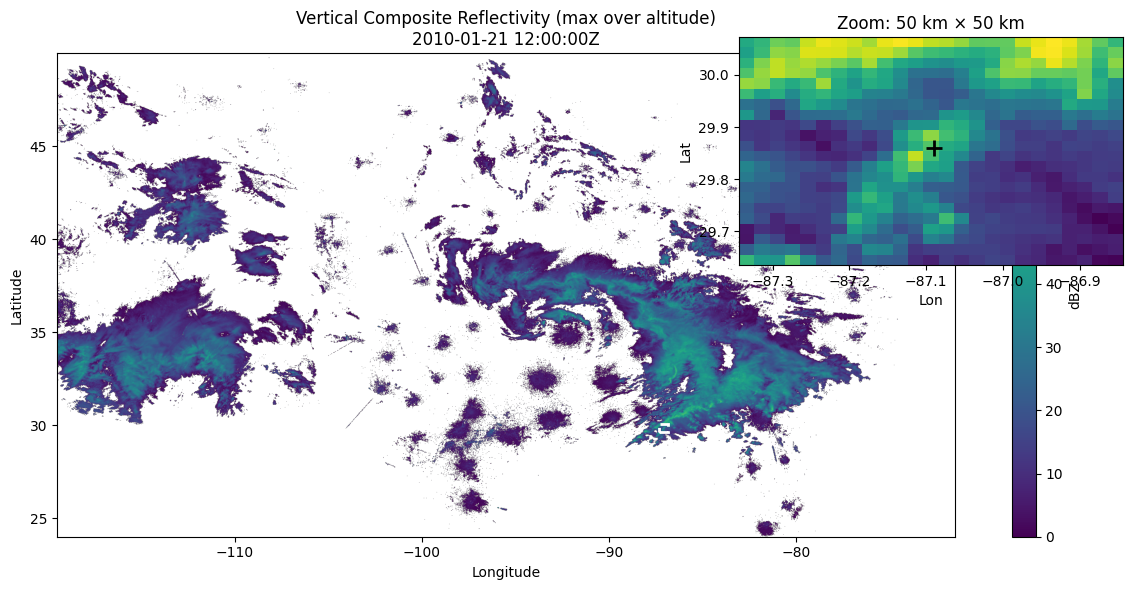

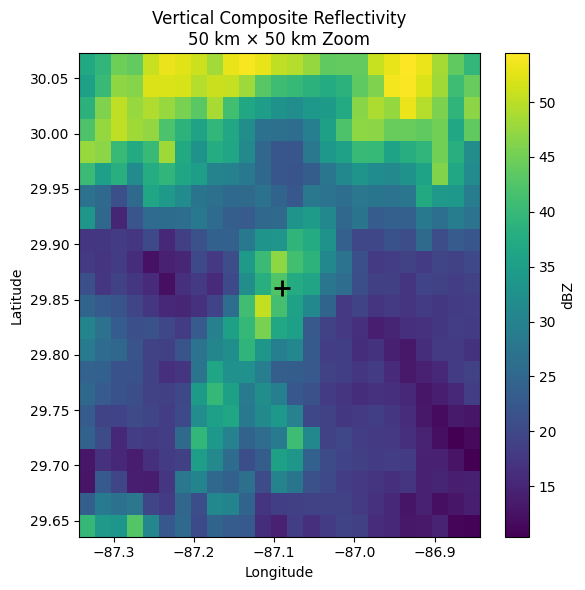

In [ ]:
# Vertical composite (fast) for your GridRad file + 50km x 50km zoom inset
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
import xarray as xr
import os
from matplotlib.patches import Rectangle

nc_path = "Datasets/temp/nexrad_3d_v4_2_20100121T120000Z.nc"
out_dir = "Datasets/temp"
os.makedirs(out_dir, exist_ok=True)

ds = nc.Dataset(nc_path, "r")
alts = ds.variables['Altitude'][:]      # shape (29,)
lats = ds.variables['Latitude'][:]      # shape (1248,)
lons = ds.variables['Longitude'][:]     # shape (2304,)
# convert lon to -180..180 for plotting if needed
lons_plot = lons.copy()
lons_plot[lons_plot > 180] -= 360.0

nalt = len(alts)
nlat = len(lats)
nlon = len(lons)
shape3 = (nalt, nlat, nlon)
print("Grid shape (alt,lat,lon):", shape3)

# read sparse arrays
idx_raw = ds.variables['index'][:]           # (N_nonempty,)
dbz_raw = ds.variables['Reflectivity'][:]    # (N_nonempty,)

print("sparse count:", len(idx_raw))
print("dbz min/max (raw):", np.nanmin(dbz_raw), np.nanmax(dbz_raw))

# check for 1-based indexing and convert to 0-based
if idx_raw.min() == 1:
    print("index appears 1-based -> converting to 0-based")
    idx0 = idx_raw - 1
else:
    idx0 = idx_raw.copy()

# Attempt unravel in C-order first
def unravel_check(order):
    try:
        a_idx, y_idx, x_idx = np.unravel_index(idx0, shape3, order=order)
        # basic bounds check
        ok = (a_idx.min() >= 0 and a_idx.max() < nalt and
              y_idx.min() >= 0 and y_idx.max() < nlat and
              x_idx.min() >= 0 and x_idx.max() < nlon)
        return ok, (a_idx, y_idx, x_idx)
    except Exception as e:
        return False, (None, None, None)

okC, (aC, yC, xC) = unravel_check('C')
if okC:
    a_idx, y_idx, x_idx = aC, yC, xC
    used_order = 'C'
else:
    okF, (aF, yF, xF) = unravel_check('F')
    if okF:
        a_idx, y_idx, x_idx = aF, yF, xF
        used_order = 'F'
    else:
        raise RuntimeError("Could not unravel 'index' into (alt,lat,lon) with either order='C' or 'F'.")

print("Using unravel order =", used_order)
print("sample a_idx unique (first 10):", np.unique(a_idx)[:10])
print("sample lat idx min/max:", y_idx.min(), y_idx.max())

# Build composite fast using np.maximum.at on flattened 2D index (lat,lon)
linear2d = (y_idx.astype(np.int64) * nlon) + x_idx.astype(np.int64)   # 1D index into lat*lon grid
flat_size = nlat * nlon

# initialize with -inf so maximum works; cast dbz to float
composite_flat = np.full(flat_size, -np.inf, dtype=np.float32)
# apply max at each linear2d location
np.maximum.at(composite_flat, linear2d, dbz_raw.astype(np.float32))

# reshape back to 2D (lat, lon)
composite2d = composite_flat.reshape((nlat, nlon))
# convert -inf -> nan where no observations
composite2d[~np.isfinite(composite2d)] = np.nan

# diagnostics
valid_count = np.isfinite(composite2d).sum()
print("Composite: valid grid points:", valid_count, "/", composite2d.size)
if valid_count > 0:
    print("Composite min/max/mean (valid):", np.nanmin(composite2d), np.nanmax(composite2d), np.nanmean(composite2d))

# --- STORM CENTER (input) ---
# Provided in file: Longitude (deg E) = 272.91, Latitude = 29.86
storm_lon_degE = 272.91
storm_lat = 29.86
# convert lon to -180..180 for plotting/projections
storm_lon = storm_lon_degE - 360.0 if storm_lon_degE > 180 else storm_lon_degE
print(f"Storm lon (plot coords): {storm_lon}, lat: {storm_lat}")

# desired half-extents (meters)
half_size_m = 25_000.0  # 25 km half -> 50 km total

# compute lat/lon bounds for the 50x50 km window (prefer pyproj, fallback to approximate)
try:
    from pyproj import Transformer
    # AEQD centered on storm location
    aeqd_proj = f"+proj=aeqd +lat_0={storm_lat} +lon_0={storm_lon} +units=m +datum=WGS84"
    t_geog2xy = Transformer.from_crs("EPSG:4326", aeqd_proj, always_xy=True)
    t_xy2geog = Transformer.from_crs(aeqd_proj, "EPSG:4326", always_xy=True)

    # box corners in local meters
    x0, y0 = 0.0, 0.0
    corners_xy = np.array([
        [-half_size_m, -half_size_m],
        [-half_size_m,  half_size_m],
        [ half_size_m,  half_size_m],
        [ half_size_m, -half_size_m],
    ])
    # transform back to lon/lat
    corner_lons = []
    corner_lats = []
    for x, y in corners_xy:
        lon_pt, lat_pt = t_xy2geog.transform(x, y)
        corner_lons.append(lon_pt)
        corner_lats.append(lat_pt)

    min_lon_box = min(corner_lons)
    max_lon_box = max(corner_lons)
    min_lat_box = min(corner_lats)
    max_lat_box = max(corner_lats)
    print("Computed zoom box via pyproj (lon/lat):", (min_lon_box, min_lat_box, max_lon_box, max_lat_box))
except Exception as e:
    print("pyproj failed or unavailable, falling back to approximate degree conversion:", e)
    # Approx conversion: 1 deg lat ~ 110.574 km; 1 deg lon ~ 111.320*cos(lat) km
    km_per_deg_lat = 110.574
    km_per_deg_lon = 111.320 * np.cos(np.deg2rad(storm_lat))
    delta_lat = half_size_m / 1000.0 / km_per_deg_lat
    delta_lon = half_size_m / 1000.0 / km_per_deg_lon
    min_lat_box = storm_lat - delta_lat
    max_lat_box = storm_lat + delta_lat
    min_lon_box = storm_lon - delta_lon
    max_lon_box = storm_lon + delta_lon
    print("Approx zoom box (lon/lat):", (min_lon_box, min_lat_box, max_lon_box, max_lat_box))

# Ensure lon bounds are in the same range as lons_plot (which are -180..180)
# If lons_plot are in -180..180 they already are; ensure box lons also in that range
if min_lon_box < -180:
    min_lon_box += 360
if max_lon_box > 180:
    max_lon_box -= 360

# find the index ranges in the grid for the zoom window
lat_mask = (lats >= min_lat_box) & (lats <= max_lat_box)
lon_mask = (lons_plot >= min_lon_box) & (lons_plot <= max_lon_box)

# if masks are empty (due to resolution or rounding), expand by 1 index
if lat_mask.sum() == 0:
    # find nearest index
    lat_idx_near = np.abs(lats - storm_lat).argmin()
    lat_mask = np.zeros_like(lat_mask); lat_mask[lat_idx_near] = True
if lon_mask.sum() == 0:
    lon_idx_near = np.abs(lons_plot - storm_lon).argmin()
    lon_mask = np.zeros_like(lon_mask); lon_mask[lon_idx_near] = True

lat_inds = np.where(lat_mask)[0]
lon_inds = np.where(lon_mask)[0]
iy0, iy1 = lat_inds.min(), lat_inds.max()
ix0, ix1 = lon_inds.min(), lon_inds.max()
print("Zoom index ranges lat:", iy0, iy1, " lon:", ix0, ix1)
print("Zoom window size (grid cells):", (iy1-iy0+1), (ix1-ix0+1))

# subset of composite for inset (note: do NOT modify original composite2d)
sub = composite2d[iy0:iy1+1, ix0:ix1+1]

# Plot main figure and inset
fig, ax = plt.subplots(1, 1, figsize=(12,6))
extent = (lons_plot.min(), lons_plot.max(), lats.min(), lats.max())
im = ax.imshow(composite2d, origin='lower', extent=extent, aspect='auto')
ax.set_title("Vertical Composite Reflectivity (max over altitude)\n" + getattr(ds, 'Analysis_time', ''))
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
cbar = fig.colorbar(im, ax=ax, label='dBZ')

# draw rectangle showing zoom window on main axes
rect_lon = min_lon_box
rect_lat = min_lat_box
rect_width = max_lon_box - min_lon_box
rect_height = max_lat_box - min_lat_box
# If rectangle crosses dateline (rect_width negative), fix by using absolute width (rare here)
if rect_width < 0:
    rect_width = (max_lon_box + 360) - min_lon_box

rect = Rectangle((rect_lon, rect_lat), rect_width, rect_height,
                 linewidth=2, edgecolor='white', facecolor='none', linestyle='--')
ax.add_patch(rect)

# inset axes (position as fraction of figure: [left, bottom, width, height])
axins = fig.add_axes([0.62, 0.55, 0.32, 0.38])
# compute extent for inset using actual lon/lat bounds of the selected indices
inset_extent = (lons_plot[ix0], lons_plot[ix1], lats[iy0], lats[iy1])
# show subset; use origin='lower' and set aspect='auto'
im2 = axins.imshow(sub, origin='lower', extent=inset_extent, aspect='auto')
axins.set_title("Zoom: 50 km × 50 km")
axins.set_xlabel("Lon")
axins.set_ylabel("Lat")
# draw crosshair at storm center in the inset (if inside)
if (storm_lon >= inset_extent[0] and storm_lon <= inset_extent[1] and
    storm_lat >= inset_extent[2] and storm_lat <= inset_extent[3]):
    axins.plot(storm_lon, storm_lat, marker='+', color='k', markersize=12, markeredgewidth=2)

plt.tight_layout()
plt.show()

# --- Separate figure for the 50 km × 50 km zoom ---
fig_zoom, ax_zoom = plt.subplots(1, 1, figsize=(6, 6))
im_zoom = ax_zoom.imshow(sub, origin='lower', extent=inset_extent, aspect='auto')
ax_zoom.set_title("Vertical Composite Reflectivity\n50 km × 50 km Zoom")
ax_zoom.set_xlabel("Longitude")
ax_zoom.set_ylabel("Latitude")
cbar_zoom = fig_zoom.colorbar(im_zoom, ax=ax_zoom, label='dBZ')

# crosshair for storm center (same logic as before)
if (storm_lon >= inset_extent[0] and storm_lon <= inset_extent[1] and
    storm_lat >= inset_extent[2] and storm_lat <= inset_extent[3]):
    ax_zoom.plot(storm_lon, storm_lat, marker='+', color='k', markersize=12, markeredgewidth=2)

plt.tight_layout()
plt.show()

ds.close()


####**View NEXRAD Level-3 Dataset Information**

[inspect_first_tar] Inspecting: Datasets/nexrad_datasets/tmp_tarbell/NWS_NEXRAD_NXL3_KABR_20170717000000_20170717235959.tar.gz
[inspect_first_tar] 23665 members found. Showing first 200 names:
   KABR_NXUS63_GSMABR_201707170016
   KABR_NXUS63_GSMABR_201707170118
   KABR_NXUS63_GSMABR_201707170223
   KABR_NXUS63_GSMABR_201707170321
   KABR_NXUS63_GSMABR_201707170419
   KABR_NXUS63_GSMABR_201707170517
   KABR_NXUS63_GSMABR_201707170540
   KABR_NXUS63_GSMABR_201707170544
   KABR_NXUS63_GSMABR_201707170617
   KABR_NXUS63_GSMABR_201707170718
   KABR_NXUS63_GSMABR_201707170816
   KABR_NXUS63_GSMABR_201707170917
   KABR_NXUS63_GSMABR_201707171018
   KABR_NXUS63_GSMABR_201707171119
   KABR_NXUS63_GSMABR_201707171217
   KABR_NXUS63_GSMABR_201707171316
   KABR_NXUS63_GSMABR_201707171415
   KABR_NXUS63_GSMABR_201707171419
   KABR_NXUS63_GSMABR_201707171519
   KABR_NXUS63_GSMABR_201707171617
   KABR_NXUS63_GSMABR_201707171650
   KABR_NXUS63_GSMABR_201707171705
   KABR_NXUS63_GSMABR_201707171717
  

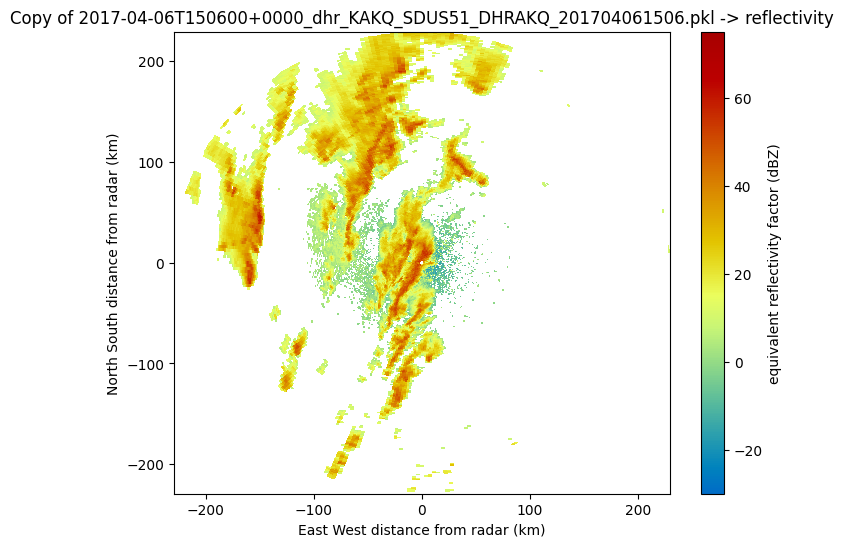

[display_product_from_path] plotted field 'reflectivity' for file 'Copy of 2017-04-06T150600+0000_dhr_KAKQ_SDUS51_DHRAKQ_201704061506.pkl'


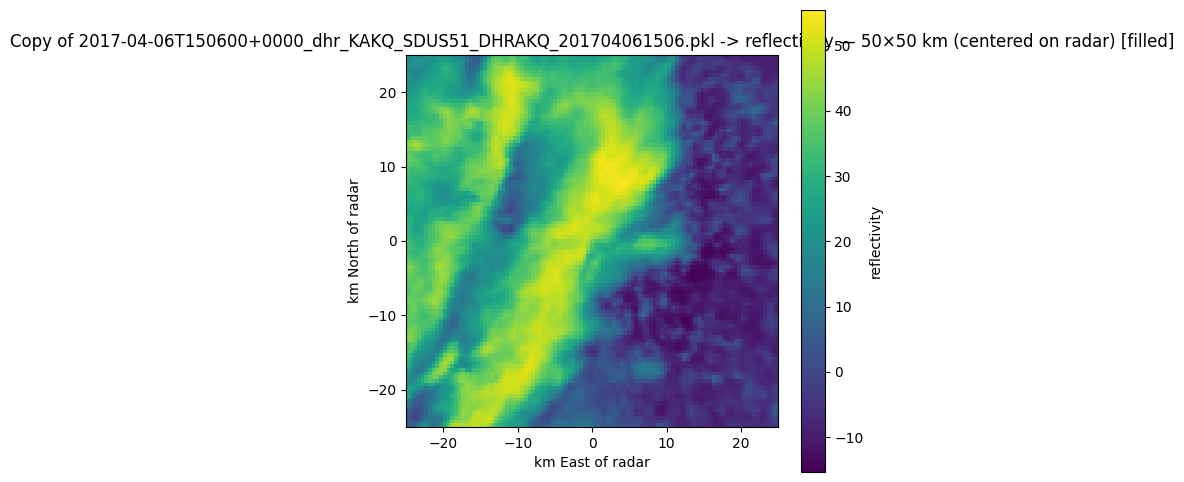

[50km crop] plotted using pyart.map.grid_from_radars() with nearest fill/smoothing


In [ ]:
import s3fs
import matplotlib.pyplot as plt
import pyart
import os, tarfile, re
import pickle
import numpy as np

from io import BytesIO
from collections import Counter
from scipy.ndimage import distance_transform_edt, gaussian_filter
from scipy.spatial import cKDTree
from typing import Optional


############################################################################# HELPER ##############################################################################


def _fill_nans_by_nearest_avg(arr, k: int = 4, max_distance: Optional[float] = None,
                              fill_global_mean: bool = True, debug: bool = False):
    """
    Fill NaNs in a 2D numeric array by averaging the k nearest non-NaN neighbors.
    Compatible with SciPy versions that do or do not support cKDTree.query(n_jobs=...).
    """
    import numpy as np

    # handle masked arrays
    if hasattr(arr, "filled"):
        arr = arr.filled(np.nan)
    arr = np.asarray(arr, dtype=float)

    mask = np.isnan(arr)
    if not mask.any():
        return arr

    coords_non_nan = np.column_stack(np.nonzero(~mask))
    vals = arr[~mask]
    coords_nan = np.column_stack(np.nonzero(mask))

    if coords_non_nan.shape[0] == 0:
        if debug:
            print("[_fill_nans_by_nearest_avg] no non-NaN cells found")
        return arr

    tree = cKDTree(coords_non_nan)

    kq = min(k, coords_non_nan.shape[0])

    # compatibility: some scipy versions support n_jobs, others don't
    try:
        # prefer parallel if available
        dists, idxs = tree.query(coords_nan, k=kq, n_jobs=-1)
    except TypeError:
        # older scipy: no n_jobs argument
        dists, idxs = tree.query(coords_nan, k=kq)

    # normalize shapes when kq == 1
    if kq == 1:
        dists = dists[:, None]
        idxs = idxs[:, None]

    if max_distance is not None:
        valid_mask = (dists <= max_distance)
    else:
        valid_mask = np.ones_like(dists, dtype=bool)

    fill_vals = np.empty(coords_nan.shape[0], dtype=float)
    fill_vals.fill(np.nan)
    sums = np.zeros(coords_nan.shape[0], dtype=float)
    counts = np.zeros(coords_nan.shape[0], dtype=int)

    for neigh_slot in range(kq):
        valid = valid_mask[:, neigh_slot]
        if not valid.any():
            continue
        idxs_slot = idxs[:, neigh_slot][valid]
        sums[valid] += vals[idxs_slot]
        counts[valid] += 1

    nonzero = counts > 0
    fill_vals[nonzero] = sums[nonzero] / counts[nonzero]

    arr_filled = arr.copy()
    arr_filled[mask] = fill_vals

    if fill_global_mean:
        global_mean = np.nanmean(vals) if vals.size > 0 else np.nan
        if np.isnan(global_mean):
            if debug:
                print("[_fill_nans_by_nearest_avg] global mean is NaN; leaving remaining NaNs")
        else:
            arr_filled[np.isnan(arr_filled)] = global_mean

    return arr_filled



def _load_composite_pickle(pkl_path: str, debug: bool=False):
    try:
        with open(pkl_path, "rb") as fh:
            comp = pickle.load(fh)
        if debug:
            print(f"[cache] loaded composite from {pkl_path}")
        return comp
    except Exception as e:
        if debug:
            print(f"[cache] failed to load pickle {pkl_path}: {e}")
        return None


############################################################################ LEVEL 2 #############################################################################


'''
# List files for a given date and radar site
fs = s3fs.S3FileSystem(anon=True)

# e.g., KTLX on 20210720
prefix = "noaa-nexrad-level2/2021/07/20/KTLX/"
files = fs.ls(prefix)
print("Available scans:", files[:5])


# Choose one file and open it via Py-ART directly from S3
sample = files[0]
with fs.open(sample, 'rb') as fobj:
    radar = pyart.io.read_nexrad_archive(fobj)

# Inspect metadata
print(dir(radar))

print("Tilts:", radar.sweep_number)
print("Fields available:", radar.fields.keys())

# Extract base reflectivity (usually 'reflectivity')
reflect = radar.fields['reflectivity']['data'][0]  # first tilt

# Plot
plt.figure(figsize=(36,36))
display = pyart.graph.RadarDisplay(radar)
display.plot('reflectivity', sweep=0, vmin=10, vmax=60, title="KTLX Reflectivity")
plt.show()
'''


################################################################## DISPLAY AVALIABLE PRODUCTS #############################################################################



def extract_product_token_from_second_segment(member_name: str) -> str:
    """
    Strict: return exactly the first 3 alnum chars of the 3rd underscore segment.
    Example:
      "KEWX_SDUS24_N1QDFX_201707171046" -> "N1Q"
      "KXXX_ABC_DHR_2019..."             -> "DHR"
    Returns None if the segment is missing or doesn't yield alnum chars.
    """
    if not isinstance(member_name, str):
        return None
    parts = member_name.split('_')
    if len(parts) < 3:
        return None
    seg = parts[2].upper()
    seg = re.sub(r'[^A-Z0-9]', '', seg)  # keep only alnum
    if len(seg) == 0:
        return None
    return seg[:3]  # EXACTLY 3 chars (or fewer if seg <3)


# Inspect first tar in tmp_tar_dir, show members and token counts ---
def inspect_first_tar(tmp_tar_dir: str = "Datasets/nexrad_datasets/tmp_tarbell",
                      top_n: int = 20,
                      sample_map_n: int = 40,
                      debug: bool = True):
    """
    Inspect the first TAR in tmp_tar_dir, list members, extract product tokens
    using the second-underscore segment rule, and print the most common tokens.
    Also prints a short sample mapping (member -> extracted token).
    Returns (tar_path, names, counts) like previous helper.
    """
    files = sorted([os.path.join(tmp_tar_dir, f) for f in os.listdir(tmp_tar_dir)
                    if f.lower().endswith(('.tar', '.tgz', '.tar.gz'))])
    if not files:
        raise FileNotFoundError(f"No tar files found in {tmp_tar_dir}")
    tar_path = files[0]
    if debug:
        print(f"[inspect_first_tar] Inspecting: {tar_path}")

    tf = tarfile.open(tar_path, mode="r:*")
    members = [m for m in tf.getmembers() if m.isfile()]
    names = [m.name for m in members]

    if debug:
        print(f"[inspect_first_tar] {len(names)} members found. Showing first {min(200, len(names))} names:")
        for n in names[:200]:
            print("  ", n)

    # build token list using strict rule
    tokens = []
    sample_map = []
    for n in names:
        tok = extract_product_token_from_second_segment(n)
        tokens.append(tok if tok is not None else "<NONE>")
        if len(sample_map) < sample_map_n:
            sample_map.append((n, tok))

    counts = Counter(tokens)
    if debug:
        print("\n[inspect_first_tar] Sample mapping (first {} members):".format(len(sample_map)))
        for mname, tok in sample_map:
            print(f"  {mname:60s} -> {tok}")
        print(f"\n[inspect_first_tar] Top {top_n} product tokens and counts:")
        for token, cnt in counts.most_common(top_n):
            print(f"  {token:6s} : {cnt}")

    try:
        tf.close()
    except Exception:
        print("continuing")
        pass

    return tar_path, names, counts



################################################################## DISPLAY SELECTED PRODUCT ##################################################################



def display_product_from_path(path: str, product_token: str = "_dhr", field_preference: str = "reflectivity", debug: bool = True):
    """
    Look inside 'path' (a directory) and find the FIRST file whose filename contains product_token
    (case-insensitive). Treat that file as the pickled cached composite (pkl) if possible:
        comp = _load_composite_pickle(pkl_path, debug=debug)
    If that fails, fall back to trying to read the file contents with pyart.io.read_nexrad_level3.
    After comp is obtained, perform the same plotting / gridding workflow as before.

    Returns (comp, member_name)
    """
    if debug:
        print(f"[display_product_from_path] scanning directory {path!r} for token '{product_token}'")

    if not os.path.exists(path):
        raise FileNotFoundError(f"path not found: {path}")

    if not os.path.isdir(path):
        raise ValueError(f"path must be a directory containing files; got file: {path}")

    # list files in deterministic order
    names = sorted(os.listdir(path))
    candidate_name = None
    token_uc = (product_token or "").lower()

    for nm in names:
        if token_uc in nm.lower():
            candidate_name = nm
            break

    if candidate_name is None:
        # helpful fallback: show top tokens
        tokens = []
        for nm in names:
            parts = nm.split('_')
            tok = None
            if len(parts) >= 3:
                tok = re.sub(r'[^A-Z0-9]', '', parts[2].upper())
            tokens.append(tok or "<NONE>")
        counts = Counter(tokens)
        raise ValueError(f"No file matched token '{product_token}' in directory {path!r}. Top tokens: {counts.most_common(40)}")

    member_path = os.path.join(path, candidate_name)
    if debug:
        print(f"[display_product_from_path] selected file: {member_path}")

    # Attempt to load cached composite via helper (user has this in-scope)
    comp = None
    pkl_path = member_path
    try:
        if os.path.exists(pkl_path):
            # user-provided function expected in-scope
            comp = _load_composite_pickle(pkl_path, debug=debug)
            if comp is not None and debug:
                print(f"[display_product_from_path] composite cache HIT: {pkl_path}")
    except Exception as e:
        if debug:
            print(f"[display_product_from_path] _load_composite_pickle failed: {e}")

    # If cache load failed, try reading raw file bytes with pyart
    if comp is None:
        try:
            with open(member_path, "rb") as fh:
                blob = fh.read()
            bio = BytesIO(blob)
            # try reading with pyart (same approach as before)
            try:
                comp = pyart.io.read_nexrad_level3(bio)
            except Exception:
                # maybe pyart expects seekable object — retry
                try:
                    bio.seek(0)
                    comp = pyart.io.read_nexrad_level3(bio)
                except Exception as e:
                    raise RuntimeError(f"pyart failed to read file {member_path}: {e}")
        except Exception as e:
            raise RuntimeError(f"Failed to open/read {member_path}: {e}")

    if comp is None:
        raise RuntimeError("pyart failed to produce composite from selected file")

    # --- plotting & grid logic (kept mostly the same as your original) ---
    fields = list(comp.fields.keys()) if hasattr(comp, 'fields') else []
    if debug:
        print(f"[display_product_from_path] composite fields: {fields}")
    try:
        raw_times = comp.time['data']
        units = comp.time.get('units', 'unknown')
        if debug:
            print(f"[display_product_from_path] comp.time units: {units}; raw_times[0]: {raw_times[0] if len(raw_times)>0 else 'N/A'}")
    except Exception:
        pass

    plot_field = field_preference if field_preference in fields else (fields[0] if fields else None)
    if plot_field is None:
        raise RuntimeError("No plottable fields found in composite")

    # RadarDisplay primary plotting (defensive)
    try:
        from pyart.graph import RadarDisplay
        fig, ax = plt.subplots(1, 1, figsize=(8, 6))
        display = RadarDisplay(comp)
        display.plot(plot_field, sweep=0, ax=ax, title=f"{os.path.basename(member_path)} -> {plot_field}")
        plt.show()
        if debug:
            print(f"[display_product_from_path] plotted field '{plot_field}' for file '{candidate_name}'")
    except Exception as e:
        # fallback imshow of first sweep
        try:
            sweep = 0
            start = comp.sweep_start_ray_index['data'][sweep]
            stop  = comp.sweep_end_ray_index['data'][sweep]
            arr = comp.fields[plot_field]['data'][start:stop, :]
            arr_plot = arr.filled(np.nan) if isinstance(arr, np.ma.MaskedArray) else arr
            fig, ax = plt.subplots(1,1, figsize=(8,6))
            im = ax.imshow(arr_plot, origin='lower', aspect='auto')
            ax.set_title(f"Fallback plot: {os.path.basename(member_path)} -> {plot_field}")
            fig.colorbar(im, ax=ax, label=plot_field)
            plt.show()
            if debug:
                print(f"[display_product_from_path] fallback plotted '{plot_field}'. (RadarDisplay error: {e})")
        except Exception as e2:
            raise RuntimeError(f"Both RadarDisplay and fallback plotting failed: {e}; {e2}")

    # Try gridding with pyart.map.grid_from_radars; if that fails, use polar->cartesian binning fallback
    try:
        from pyart.map import grid_from_radars
        # radar lat/lon from the composite/radar object — be defensive
        try:
            radar_lat = float(comp.latitude['data'][0])
            radar_lon = float(comp.longitude['data'][0])
        except Exception:
            # try scalars if array-like isn't present
            radar_lat = float(comp.latitude['data']) if isinstance(comp.latitude['data'], (float, int)) else None
            radar_lon = float(comp.longitude['data']) if isinstance(comp.longitude['data'], (float, int)) else None

        if radar_lat is None or radar_lon is None:
            raise RuntimeError("Could not determine radar latitude/longitude from composite for gridding")

        half_side_m = 25_000.0  # 25 km each way -> 50 km total
        grid_shape = (1, 101, 101)
        grid_limits = ((0.0, 1000.0), (-half_side_m, half_side_m), (-half_side_m, half_side_m))

        grid = grid_from_radars([comp],
                                grid_shape=grid_shape,
                                grid_limits=grid_limits,
                                grid_origin=(radar_lat, radar_lon),
                                fields=[plot_field])

        gdata = grid.fields[plot_field]['data'][0, :, :]
        extent_km = (-half_side_m/1000.0, half_side_m/1000.0, -half_side_m/1000.0, half_side_m/1000.0)

        # fill NaNs nearest (using your helper)
        gdata_filled = _fill_nans_by_nearest_avg(gdata.astype(float), k=4, max_distance=None, fill_global_mean=True)

        # optional smoothing
        try:
            gdata_sm = gaussian_filter(gdata_filled, sigma=0.6, mode='nearest') if gaussian_filter is not None else gdata_filled
        except Exception:
            gdata_sm = gdata_filled

        fig, ax = plt.subplots(1, 1, figsize=(6, 6))
        im = ax.imshow(gdata_sm, origin='lower', extent=extent_km, aspect='equal')
        ax.set_title(f"{os.path.basename(member_path)} -> {plot_field} — 50×50 km (centered on radar) [filled]")
        ax.set_xlabel("km East of radar")
        ax.set_ylabel("km North of radar")
        fig.colorbar(im, ax=ax, label=plot_field)
        plt.show()
        print("[50km crop] plotted using pyart.map.grid_from_radars() with nearest fill/smoothing")

    except Exception as grid_err:
        # fallback: polar->cartesian histogram binning (same as original)
        try:
            sweep = 0
            start = comp.sweep_start_ray_index['data'][sweep]
            stop = comp.sweep_end_ray_index['data'][sweep]
            ranges_m = comp.range['data']
            azimuths = comp.azimuth['data'][start:stop]
            vals = comp.fields[plot_field]['data'][start:stop, :]
            vals = np.array(vals)
            R = ranges_m / 1000.0
            AZ = np.deg2rad(azimuths)[:, None]
            R2D = np.tile(R, (len(azimuths), 1))
            x = R2D * np.sin(AZ)
            y = R2D * np.cos(AZ)

            xmin, xmax = -25.0, 25.0
            ymin, ymax = -25.0, 25.0
            nbins = 101
            xi = np.linspace(xmin, xmax, nbins)
            yi = np.linspace(ymin, ymax, nbins)

            xf = x.ravel()
            yf = y.ravel()
            vf = vals.ravel()
            if np.ma.is_masked(vf):
                vf = vf.filled(np.nan)

            H_sum, xedges, yedges = np.histogram2d(xf, yf, bins=[xi, yi], range=[[xmin, xmax], [ymin, ymax]], weights=vf)
            H_count, _, _ = np.histogram2d(xf, yf, bins=[xi, yi], range=[[xmin, xmax], [ymin, ymax]])
            with np.errstate(invalid='ignore', divide='ignore'):
                H_mean = H_sum / np.where(H_count == 0, np.nan, H_count)

            imdata = H_mean.T
            imdata_filled = _fill_nans_by_nearest_avg(imdata.astype(float), k=4, max_distance=None, fill_global_mean=True)

            try:
                imdata_sm = gaussian_filter(imdata_filled, sigma=0.6, mode='nearest') if gaussian_filter is not None else imdata_filled
            except Exception:
                imdata_sm = imdata_filled

            fig, ax = plt.subplots(1, 1, figsize=(6, 6))
            im = ax.imshow(imdata_sm, origin='lower', extent=[xmin, xmax, ymin, ymax], aspect='equal')
            ax.set_title(f"Fallback 50×50 km crop: {os.path.basename(member_path)} -> {plot_field} [filled]")
            ax.set_xlabel("km East of radar")
            ax.set_ylabel("km North of radar")
            fig.colorbar(im, ax=ax, label=plot_field)
            plt.show()
            print("[50km crop] plotted using fallback binning (nearest fill/smoothing).")
        except Exception as fallback_err:
            print("[50km crop] failed:")
            print("  grid error:", grid_err)
            print("  fallback error:", fallback_err)

    return comp, candidate_name



_, names, counts = inspect_first_tar("Datasets/nexrad_datasets/tmp_tarbell")

tar_path = "Datasets/temp"

# see printed top tokens; pick one (e.g. 'DHR')
comp, member_name = display_product_from_path("Datasets/temp", product_token="_dhr_", field_preference="reflectivity")




In [ ]:
import os, re, pickle, math, warnings, traceback
import numpy as np
import matplotlib.pyplot as plt
import imageio.v2 as imageio

from datetime import datetime
from pathlib import Path

# ---------------- CONFIG ----------------
STORM_DIR = "Datasets/training_datasets/level_three_cropped/2017/KDLH/storm_3411"
OUT_GIF   = "dhr_anim.gif"
OUT_MP4   = "dhr_anim.mp4"
FPS       = 4
CMAP      = "pyart_NWSRef"
VMIN, VMAX = 0, 60
FIGSIZE   = (7, 6)
DPI       = 140
PAD_INCH  = 0.05
TITLE_FMT = "{title}\n{ts:%Y-%m-%d %H:%M:%S} UTC"

# Set to False to silence debug prints about failed adapters
VERBOSE = True

# Try pyart colormap if available
try:
    import pyart
    cmap = plt.get_cmap(CMAP)
except Exception:
    warnings.warn("pyart not found or cmap missing; using default matplotlib cmap.")
    cmap = plt.get_cmap("viridis")
    pyart = None

# Helpers
_ts_re = re.compile(r'(\d{8})[_-]?(\d{4,6})')

def parse_timestamp_from_name(name: str):
    m = _ts_re.search(name)
    if not m:
        return None
    ymd, hm = m.groups()
    year = int(ymd[:4]); mon = int(ymd[4:6]); day = int(ymd[6:8])
    hour = int(hm[:2]); minute = int(hm[2:4])
    second = int(hm[4:6]) if len(hm) >= 6 else 0
    try:
        return datetime(year, mon, day, hour, minute, second)
    except ValueError:
        return None

def safe_title_from_name(name: str):
    return Path(name).stem.replace("_", " ")

# field name tests (more tolerant)
def is_reflectivity_name(k: str):
    if not k:
        return False
    s = k.lower()
    # common reflectivity keys encountered in pyart / NEXRAD
    return any(sub in s for sub in ("dhr", "reflect", "refl", "dbz", "n0r"))

def is_velocity_name(k: str):
    if not k:
        return False
    s = k.lower()
    return "vel" in s or "velocity" in s or "doppler" in s

# debug summary helper (kept short)
def debug_object_summary(obj, label=None, maxlen=800):
    if not VERBOSE:
        return
    print("---- DEBUG OBJECT SUMMARY ----")
    if label:
        print("Label:", label)
    print("Type:", type(obj))
    try:
        r = repr(obj)
        print("Repr head:", r[:maxlen].replace("\n", " "))
    except Exception as e:
        print("Could not get repr:", e)
    if isinstance(obj, dict):
        print("dict keys (first 50):", list(obj.keys())[:50])
    if hasattr(obj, "keys") and not isinstance(obj, dict):
        try:
            print("obj.keys() (first 50):", list(obj.keys())[:50])
        except Exception:
            pass
    if hasattr(obj, "fields"):
        try:
            f = obj.fields
            print(".fields type:", type(f), "len (if possible):",
                  (len(f) if hasattr(f, "__len__") else "unknown"),
                  "keys (first 50):", list(f.keys())[:50] if isinstance(f, dict) else "not dict")
        except Exception as e:
            print("Error reading .fields:", e)
    if hasattr(obj, "__dict__"):
        try:
            print("__dict__ keys (first 50):", list(obj.__dict__.keys())[:50])
        except Exception:
            pass
    print("---- end debug ----")


# ---------------- ADAPTER ----------------
def adapt_pyart_radar(obj):
    """
    Unified adapter: accepts pyart Radar OR pyart-like objects/dicts that expose a .fields mapping.
    Returns a single dict with a single plot_fn closure that handles:
      - pcolormesh(gate_x, gate_y, data) when gate coords available or can be constructed
      - pyart.graph.RadarDisplay.plot for Radar objects (fallback)
      - imshow(arr) as last resort
    If object only has velocity-like fields, returns None.
    """
    # attempt to detect pyart Radar class
    RadarClass = None
    try:
        if pyart is not None:
            from pyart.core import Radar as RadarClass
    except Exception:
        RadarClass = None

    is_radar = RadarClass is not None and isinstance(obj, RadarClass)

    # Get fields mapping (works for Radar and dict-like objects)
    fields = None
    if is_radar:
        try:
            fields = obj.fields
        except Exception:
            fields = None
    else:
        if isinstance(obj, dict):
            fields = obj.get("fields", None) or obj
        else:
            fields = getattr(obj, "fields", None)

    if not fields:
        return None

    # coerce to dict if needed
    if not isinstance(fields, dict):
        try:
            keys = list(fields.keys())
            fields = {k: fields[k] for k in keys}
        except Exception:
            return None

    available_keys = list(fields.keys())
    refl_keys = [k for k in available_keys if is_reflectivity_name(k)]
    vel_keys = [k for k in available_keys if is_velocity_name(k)]

    # if no reflectivity-like keys, skip (velocity-only)
    if not refl_keys:
        if VERBOSE:
            print(f"[SKIP] .fields present but no reflectivity-like keys. Example keys: {available_keys}")
        return None

    # use the first reflectivity-like key
    field_key = refl_keys[0]

    # timestamp heuristics
    ts = None
    if is_radar:
        try:
            ts = pyart.util.datetimes_from_radar(obj)[0]
        except Exception:
            ts = getattr(obj, "time", None) or getattr(obj, "timestamp", None) or None
    else:
        ts = getattr(obj, "time", None) or getattr(obj, "timestamp", None) or getattr(obj, "valid_time", None)

    title = f"DHR (field={field_key})"

    # helper accessors (work for Radar objects and dict-like)
    def _get_raw_field():
        # returns the raw field container (dict-like or ndarray)
        try:
            if is_radar:
                return obj.fields.get(field_key)
            else:
                return fields.get(field_key)
        except Exception:
            return None

    def _get_data_array():
        raw = _get_raw_field()
        if raw is None:
            return None
        # typical pyart field: dict with "data"
        try:
            if isinstance(raw, dict) and "data" in raw:
                return np.asarray(raw["data"])
        except Exception:
            pass
        # object with .data attribute
        try:
            if hasattr(raw, "data"):
                return np.asarray(getattr(raw, "data"))
        except Exception:
            pass
        # raw might be already an array-like
        try:
            return np.asarray(raw)
        except Exception:
            return None

    def _get_gate_xy():
        # Prefer obj attributes (Radar), then dict keys (duck-typing).
        gx = None; gy = None
        try:
            if is_radar:
                gx = getattr(obj, "gate_x", None)
                gy = getattr(obj, "gate_y", None)
            else:
                # dict-like: could be keys or attributes
                gx = getattr(obj, "gate_x", None) if hasattr(obj, "gate_x") else (obj.get("gate_x") if isinstance(obj, dict) else None)
                gy = getattr(obj, "gate_y", None) if hasattr(obj, "gate_y") else (obj.get("gate_y") if isinstance(obj, dict) else None)
                # also try top-level keys
                if gx is None or gy is None:
                    gx = (obj.get("gate_x") if isinstance(obj, dict) else gx) or getattr(obj, "gate_x", None)
                    gy = (obj.get("gate_y") if isinstance(obj, dict) else gy) or getattr(obj, "gate_y", None)
        except Exception:
            gx = gy = None
        return gx, gy

    # helper to try to find 1D azimuth/range arrays
    def _get_azimuth_and_range():
        az = None; rg = None
        # try attributes first (Radar)
        try:
            if is_radar:
                az = getattr(obj, "azimuth", None)
                rg = getattr(obj, "range", None)
            else:
                # dict-like keys or attributes
                if isinstance(obj, dict):
                    az = obj.get("azimuth", None) or obj.get("az", None)
                    rg = obj.get("range", None)
                else:
                    az = getattr(obj, "azimuth", None) or getattr(obj, "az", None)
                    rg = getattr(obj, "range", None)
        except Exception:
            az = rg = None
        # unwrap possible pyart lazy containers
        try:
            if az is not None and hasattr(az, "data"):
                az = getattr(az, "data")
        except Exception:
            pass
        try:
            if rg is not None and hasattr(rg, "data"):
                rg = getattr(rg, "data")
        except Exception:
            pass
        # coerce to numpy arrays where possible
        try:
            if az is not None:
                az = np.asarray(az)
        except Exception:
            az = None
        try:
            if rg is not None:
                rg = np.asarray(rg)
        except Exception:
            rg = None
        return az, rg

    # unified plot function with extra debug and meshgrid construction
    def plot_fn(ax):
        try:
            if VERBOSE:
                print("----- plot_fn DEBUG START -----")
                print("is_radar:", is_radar, "field_key:", field_key)

            raw_field = _get_raw_field()
            if VERBOSE:
                try:
                    rf_repr = repr(raw_field)
                    print("raw_field type:", type(raw_field))
                    print("raw_field repr head:", rf_repr[:500].replace("\n", " "))
                except Exception as _e:
                    print("Could not repr raw_field:", _e)

            data_arr = _get_data_array()
            gx, gy = _get_gate_xy()

            # show data array diagnostics
            if data_arr is None:
                if VERBOSE:
                    print("[DEBUG] data array is None for field", field_key)
            else:
                try:
                    darr = np.asarray(data_arr)
                    print("[DEBUG] data_arr: type=", type(data_arr), "ndim=", darr.ndim,
                          "shape=", getattr(darr, "shape", None),
                          "dtype=", darr.dtype if hasattr(darr, "dtype") else None)
                    # quick stats
                    try:
                        finite_count = np.isfinite(darr).sum()
                        total = darr.size
                        nan_count = np.isnan(darr).sum() if np.issubdtype(darr.dtype, np.floating) else 0
                        print(f"[DEBUG] data_arr: size={total}, finite={finite_count}, nans={nan_count}")
                        if np.ma.is_masked(darr):
                            print("[DEBUG] data_arr is a masked array with mask summary:", getattr(darr.mask, "sum", lambda: None)())
                    except Exception as _e:
                        print("Could not compute data stats:", _e)
                except Exception as _e:
                    print("Could not coerce data_arr to ndarray:", _e)
                    darr = None

            # gate diagnostics
            if gx is None or gy is None:
                if VERBOSE:
                    print("[DEBUG] gate_x/gate_y are None (not present on object). gx:", gx, "gy:", gy)
            else:
                try:
                    gx_arr = np.asarray(gx)
                    gy_arr = np.asarray(gy)
                    print("[DEBUG] gate_x: type=", type(gx), "ndim=", getattr(gx_arr, "ndim", None), "shape=", getattr(gx_arr, "shape", None), "dtype=", gx_arr.dtype if hasattr(gx_arr, "dtype") else None)
                    print("[DEBUG] gate_y: type=", type(gy), "ndim=", getattr(gy_arr, "ndim", None), "shape=", getattr(gy_arr, "shape", None), "dtype=", gy_arr.dtype if hasattr(gy_arr, "dtype") else None)
                    # simple ranges
                    try:
                        print("[DEBUG] gate_x range:", np.nanmin(gx_arr), "->", np.nanmax(gx_arr))
                        print("[DEBUG] gate_y range:", np.nanmin(gy_arr), "->", np.nanmax(gy_arr))
                    except Exception:
                        pass
                except Exception as e:
                    print("Could not coerce gate_x/gate_y to arrays:", e)
                    gx_arr = gy_arr = None

            # Attempt pcolormesh if gate coords look usable
            try:
                used_pcolormesh = False

                # 1) If gate_x/gate_y are numeric 2D arrays, use them directly
                if gx is not None and gy is not None and data_arr is not None:
                    gx_arr = np.asarray(gx)
                    gy_arr = np.asarray(gy)
                    darr = np.asarray(data_arr)
                    if gx_arr.ndim == 2 and gy_arr.ndim == 2 and darr.ndim == 2:
                        if gx_arr.shape == darr.shape and gy_arr.shape == darr.shape:
                            if VERBOSE:
                                print("[DEBUG] gate_x/gate_y 2D match data; attempting pcolormesh.")
                            im = ax.pcolormesh(gx_arr, gy_arr, darr, vmin=VMIN, vmax=VMAX, cmap=cmap, shading='auto')
                            if not any(hasattr(a, "get_ylabel") and a.get_ylabel() for a in ax.figure.axes):
                                ax.figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label="dBZ")
                            ax.set_aspect("equal")
                            ax.set_xlabel("X (m)")
                            ax.set_ylabel("Y (m)")
                            used_pcolormesh = True
                            if VERBOSE:
                                print(f"[plot_fn] plotted with gate_x/gate_y (pcolormesh) for {title}")
                            print("----- plot_fn DEBUG END (pcolormesh successful) -----")
                            return
                        else:
                            if VERBOSE:
                                print("[DEBUG] gate_x/gate_y shapes do NOT match data shape.")
                                print("       gate_x.shape:", gx_arr.shape, "gate_y.shape:", gy_arr.shape, "data.shape:", darr.shape)

                # 2) If gate_x/gate_y are not numeric 2D, try to build them from 1D azimuth & range arrays
                if (gx is None or gy is None or not (hasattr(gx, "__array__") and hasattr(gy, "__array__"))) and data_arr is not None:
                    if VERBOSE:
                        print("[DEBUG] Attempting to construct gate_x/gate_y from azimuth & range vectors.")
                    az, rg = _get_azimuth_and_range()
                    if az is None or rg is None:
                        if VERBOSE:
                            print("[DEBUG] azimuth or range not found (az, rg):", az, rg)
                    else:
                        try:
                            # Ensure 1D
                            az1 = np.asarray(az).squeeze()
                            rg1 = np.asarray(rg).squeeze()
                            if az1.ndim == 1 and rg1.ndim == 1:
                                if VERBOSE:
                                    print("[DEBUG] azimuth length:", az1.size, "range length:", rg1.size, "data shape:", np.asarray(data_arr).shape)
                                # Ensure orientation: data likely (nrays, ngates) = (len(az1), len(rg1))
                                if np.asarray(data_arr).shape[0] == az1.size and np.asarray(data_arr).shape[1] == rg1.size:
                                    # az in degrees -> radians
                                    az_rad = np.deg2rad(az1)
                                    # create 2D grids shaped (nrays, ngates)
                                    # R: shape (1, ngates) broadcast to (nrays, ngates)
                                    R = rg1[None, :]
                                    A = az_rad[:, None]
                                    gx_new = R * np.sin(A)
                                    gy_new = R * np.cos(A)
                                    if VERBOSE:
                                        print("[DEBUG] constructed gate_x/gate_y via meshgrid; shapes:", gx_new.shape, gy_new.shape)
                                        print("[DEBUG] gate_x range:", gx_new.min(), "->", gx_new.max())
                                        print("[DEBUG] gate_y range:", gy_new.min(), "->", gy_new.max())
                                    # plot
                                    im = ax.pcolormesh(gx_new, gy_new, np.asarray(data_arr), vmin=VMIN, vmax=VMAX, cmap=cmap, shading='auto')
                                    if not any(hasattr(a, "get_ylabel") and a.get_ylabel() for a in ax.figure.axes):
                                        ax.figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label="dBZ")
                                    ax.set_aspect("equal")
                                    ax.set_xlabel("X (m)")
                                    ax.set_ylabel("Y (m)")
                                    used_pcolormesh = True
                                    if VERBOSE:
                                        print(f"[plot_fn] plotted with constructed gate_x/gate_y (meshgrid) for {title}")
                                    print("----- plot_fn DEBUG END (meshgrid pcolormesh successful) -----")
                                    return
                                else:
                                    if VERBOSE:
                                        print("[DEBUG] az/range lengths do not match data dims. az.size, rg.size, data.shape:", az1.size, rg1.size, np.asarray(data_arr).shape)
                            else:
                                if VERBOSE:
                                    print("[DEBUG] az or range are not 1D arrays. az.ndim, rg.ndim:", getattr(az1, 'ndim', None), getattr(rg1, 'ndim', None))
                        except Exception:
                            if VERBOSE:
                                print("Exception while constructing gate coords from az/range:")
                                traceback.print_exc()

                # 3) If it's a real Radar and pyart plotting is available, try RadarDisplay.plot
                if is_radar and pyart is not None:
                    try:
                        if VERBOSE:
                            print("[DEBUG] Trying pyart.graph.RadarDisplay.plot() fallback")
                        disp = pyart.graph.RadarDisplay(obj)
                        disp.plot(field=field_key, sweep=0, ax=ax, vmin=VMIN, vmax=VMAX, cmap=cmap, colorbar_flag=True)
                        ax.set_aspect('equal')
                        if VERBOSE:
                            print(f"[plot_fn] used pyart RadarDisplay.plot for {title}")
                        print("----- plot_fn DEBUG END (RadarDisplay.plot successful) -----")
                        return
                    except Exception:
                        if VERBOSE:
                            print("RadarDisplay.plot raised an exception, stack follows:")
                            traceback.print_exc()

                # Final fallback: imshow of 2D array
                if data_arr is not None:
                    try:
                        if VERBOSE:
                            print("[DEBUG] Using imshow fallback now.")
                        im = ax.imshow(np.asarray(data_arr), origin="lower", vmin=VMIN, vmax=VMAX, cmap=cmap, interpolation="nearest")
                        if not any(hasattr(a, "get_ylabel") and a.get_ylabel() for a in ax.figure.axes):
                            ax.figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label="dBZ")
                        ax.set_xlabel("Range index")
                        ax.set_ylabel("Azimuth index")
                        ax.set_aspect("auto")
                        if VERBOSE:
                            print(f"[plot_fn] used imshow fallback for {title}")
                        print("----- plot_fn DEBUG END (imshow used) -----")
                        return
                    except Exception:
                        if VERBOSE:
                            print("imshow fallback failed, stack follows:")
                            traceback.print_exc()

                # Nothing plotted
                if VERBOSE:
                    print(f"[plot_fn] nothing plottable for {title}")
                    print("----- plot_fn DEBUG END (nothing plotted) -----")
        except Exception:
            print("Unexpected error inside plot_fn:")
            traceback.print_exc()

    return {"plot_fn": plot_fn, "title": title, "timestamp": ts}



def normalize_timestamp(ts):
    """
    Convert ts -> datetime or None.
    Handles: datetime, numpy.datetime64, list/array (take first), numeric epoch,
    ISO-like strings, or returns None for dicts / unknown formats.
    """
    if ts is None:
        return None

    # datetime already
    if isinstance(ts, datetime):
        return ts

    # numpy datetime64
    try:
        if np and isinstance(ts, np.datetime64):
            # convert numpy datetime64 -> datetime (UTC)
            return datetime.utcfromtimestamp((ts.astype('datetime64[s]').astype('int')))
    except Exception:
        pass

    # list/tuple/ndarray -> try first element
    if isinstance(ts, (list, tuple)) or (hasattr(ts, "shape") and getattr(ts, "ndim", None) is not None):
        try:
            if len(ts) == 0:
                return None
            return normalize_timestamp(ts[0])
        except Exception:
            return None

    # numbers -> treat as epoch seconds
    if isinstance(ts, (int, float, np.integer, np.floating)):
        try:
            return datetime.utcfromtimestamp(float(ts))
        except Exception:
            return None

    # strings -> try iso / common patterns
    if isinstance(ts, str):
        s = ts.strip()
        # common trailing Z or timezone like +00:00 or +0000
        if s.endswith("Z"):
            s = s[:-1]
        # attempt fromisoformat (handles YYYY-MM-DDTHH:MM:SS[.ffffff][+HH:MM])
        try:
            return datetime.fromisoformat(s)
        except Exception:
            # try to parse numeric string epoch
            try:
                f = float(s)
                return datetime.utcfromtimestamp(f)
            except Exception:
                # try compact pattern like YYYYMMDDHHMMSS or YYYYMMDD_HHMMSS
                m = re.search(r'(\d{4})(\d{2})(\d{2})[T_ -]?(\d{2})(\d{2})(\d{2})', s)
                if m:
                    y,mo,d,h,mi,se = map(int, m.groups())
                    try:
                        return datetime(y, mo, d, h, mi, se)
                    except Exception:
                        return None
                return None

    # dicts and other mapping types -> give up
    return None



def adapt_pickle_object(obj, name=None):
    a = adapt_pyart_radar(obj)
    if a:
        return a
    # If we get here, adaptation failed -> show debug summary if verbose
    if VERBOSE:
        print(f"[ADAPT FAIL] object not adapted for file: {name}")
        debug_object_summary(obj, label=name)
    return None



# ---------------- LOAD & RENDER ----------------
def load_frames(storm_dir):
    frames = []
    filename_velocity_patterns = ("_n0s_", "_vel", "_velocity", "_v_", "_nvw")
    for fn in sorted(os.listdir(storm_dir)):
        lowfn = fn.lower()
        if any(pat in lowfn for pat in filename_velocity_patterns):
            if VERBOSE:
                print(f"[FILE SKIP] filename indicates velocity/metadata scan, skipping: {fn}")
            continue

        path = os.path.join(storm_dir, fn)
        if not os.path.isfile(path):
            continue

        if not (lowfn.endswith((".pkl", ".pickle", ".h5", ".hdf5", ".hdf"))):
            continue

        obj = None
        if lowfn.endswith((".pkl", ".pickle")):
            try:
                with open(path, "rb") as f:
                    obj = pickle.load(f)
            except Exception as e:
                if VERBOSE:
                    print(f"[skip] pickle load failed for {fn}: {e}")
                continue
        else:
            continue

        adapted = adapt_pickle_object(obj, name=fn)
        if adapted is None:
            if VERBOSE:
                print(f"[skip] could not adapt {fn} to a plottable DHR")
            continue

        # normalize timestamp BEFORE appending
        raw_ts = adapted.get("timestamp")
        ts = normalize_timestamp(raw_ts) or parse_timestamp_from_name(fn)
        if VERBOSE and raw_ts is not None and ts is None:
            print(f"[TS WARN] could not normalize timestamp from adapter for {fn}; raw type: {type(raw_ts)}")

        frames.append({
            "path": path,
            "plot_fn": adapted["plot_fn"],
            "title": adapted.get("title", fn),
            "timestamp": ts,
            "name": fn
        })

    # sort chronologically: (None last), then timestamp, then filename
    frames.sort(key=lambda d: (d["timestamp"] is None, d["timestamp"] or datetime.max, d["name"]))
    return frames


def render_frames(frames, figsize=FIGSIZE, dpi=DPI):
    """
    Render each frame to an RGB numpy array (H,W,3) robust to different
    Matplotlib backends / versions.
    """
    images = []
    for i, fr in enumerate(frames, 1):
        fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
        fr["plot_fn"](ax)
        ts = fr["timestamp"]
        title = TITLE_FMT.format(title=fr["title"], ts=ts) if ts else fr["title"]
        ax.set_title(title, fontsize=11)
        fig.tight_layout(pad=PAD_INCH)
        # draw the canvas
        fig.canvas.draw()

        # Try the simplest/fastest method first
        im_array = None
        try:
            # preferred, but not always present
            s = fig.canvas.tostring_rgb()
            w, h = fig.canvas.get_width_height()
            im_array = np.frombuffer(s, dtype=np.uint8).reshape(h, w, 3)
        except Exception:
            # fallback: use print_to_buffer() which returns a RGBA/ARGB buffer
            try:
                buf, (w, h) = fig.canvas.print_to_buffer()
                arr4 = np.frombuffer(buf, dtype=np.uint8).reshape(h, w, 4)
                # detect which channel is alpha (the one with mean closest to 255)
                means = arr4.mean(axis=(0, 1))
                alpha_idx = int(np.argmax(means))
                # if alpha channel looks like full-255 but other channels also might be high,
                # we still remove the detected alpha channel and keep the other three in order.
                rgb = arr4.take([j for j in range(4) if j != alpha_idx], axis=2)
                im_array = rgb
            except Exception as e:
                # last resort: try tostring_argb (older builds)
                try:
                    s2 = fig.canvas.tostring_argb()
                    w, h = fig.canvas.get_width_height()
                    arr4 = np.frombuffer(s2, dtype=np.uint8).reshape(h, w, 4)
                    # ARGB -> drop A and reorder to RGB from positions [1,2,3]
                    im_array = arr4[:, :, [1, 2, 3]]
                except Exception as e2:
                    plt.close(fig)
                    raise RuntimeError("Failed to extract image buffer from Matplotlib canvas: "
                                       f"{e} / {e2}") from e2

        # ensure we have uint8 HxWx3
        if im_array is None:
            plt.close(fig)
            raise RuntimeError("Failed to capture figure image (no buffer produced).")

        # If we have 4 channels left for some reason, drop the last channel
        if im_array.ndim == 3 and im_array.shape[2] == 4:
            im_array = im_array[:, :, :3]

        # If image is not contiguous / is read-only, copy it
        im_array = np.ascontiguousarray(im_array, dtype=np.uint8)

        images.append(im_array.copy())
        plt.close(fig)
        print(f"Rendered {i}/{len(frames)}: {fr['name']}")
    return images


def write_gif(images, out_path, fps=FPS):
    duration = 1.0 / fps
    imageio.mimsave(out_path, images, format="GIF", duration=duration)
    print(f"GIF saved -> {out_path}")

def write_mp4(images, out_path, fps=FPS):
    try:
        import imageio_ffmpeg
        writer = imageio.get_writer(out_path, fps=fps, codec="libx264", quality=8, format="FFMPEG")
        for im in images:
            writer.append_data(im)
        writer.close()
        print(f"MP4 saved -> {out_path}")
    except Exception as e:
        print(f"MP4 failed (need ffmpeg): {e}")

# Main run
if __name__ == "__main__":
    frames = load_frames(STORM_DIR)
    if not frames:
        raise SystemExit("No plottable DHR frames found. Check adapters/filters.")
    images = render_frames(frames)
    write_gif(images, OUT_GIF, fps=FPS)
    write_mp4(images, OUT_MP4, fps=FPS)


SyntaxError: expected 'except' or 'finally' block (ipython-input-1167131043.py, line 451)

####**View NEXRAD Level-2 Dataset Information**

####**View Synoptic Dataset Information**

In [ ]:
'''
Isolate building and send requests via synoptic API, so that we can manually test.
'''


################################################################ HELPER NETWORK-VIEWER FUNCTION #########################################################################################


def summarize_networks(nets_json, top_n=None, min_reporting=0, exclude_restricted=True, show_example=10):
    """
    nets_json : dict  -- the direct r.json() result from /v2/networks
    Returns a dataframe and prints pretty output.
    """
    # Accept multiple possible shapes: 'MNET' (your dump) or a direct list
    raw_list = None
    if isinstance(nets_json, dict):
        if "MNET" in nets_json and isinstance(nets_json["MNET"], list):
            raw_list = nets_json["MNET"]
        elif "NETWORKS" in nets_json and isinstance(nets_json["NETWORKS"], list):
            raw_list = nets_json["NETWORKS"]
        else:
            # fallback: find first list-of-dicts child
            for v in nets_json.values():
                if isinstance(v, list) and v and isinstance(v[0], dict):
                    raw_list = v
                    break
    if raw_list is None:
        raise ValueError("Can't find networks list in the JSON you passed. Print the JSON keys and re-run.")

    rows = []
    for n in raw_list:
        def g(key, default=None):
            return n.get(key, default)

        # Some fields are strings in the API; coerce safely
        def to_int(x):
            try:
                return int(x)
            except Exception:
                return None

        # period_of_record may be a dict
        period = g("PERIOD_OF_RECORD") or {}

        # safe percent parse
        pa = g("PERCENT_ACTIVE")
        try:
            pa_val = float(pa) if pa not in (None, "") else None
        except Exception:
            pa_val = None

        rows.append({
            "ID":                g("ID"),
            "SHORTNAME":         g("SHORTNAME"),
            "LONGNAME":          g("LONGNAME"),
            "CATEGORY":          g("CATEGORY"),
            "LAST_OBSERVATION":  g("LAST_OBSERVATION"),
            "REPORTING_STATIONS": to_int(g("REPORTING_STATIONS")),
            "ACTIVE_STATIONS":    to_int(g("ACTIVE_STATIONS")),
            "TOTAL_STATIONS":     to_int(g("TOTAL_STATIONS")),
            "PERCENT_ACTIVE":     pa_val,
            "ACTIVE_RESTRICTED":  to_int(g("ACTIVE_RESTRICTED") or 0),
            "TOTAL_RESTRICTED":   to_int(g("TOTAL_RESTRICTED") or 0),
            "PERIOD_START":       period.get("start"),
            "PERIOD_END":         period.get("end"),
        })

    df = pd.DataFrame(rows)

    # normalize types & sort
    df["REPORTING_STATIONS"] = df["REPORTING_STATIONS"].fillna(0).astype(int)
    df["ACTIVE_RESTRICTED"]  = df["ACTIVE_RESTRICTED"].fillna(0).astype(int)
    df["TOTAL_RESTRICTED"]   = df["TOTAL_RESTRICTED"].fillna(0).astype(int)

    df = df.sort_values(by="REPORTING_STATIONS", ascending=False).reset_index(drop=True)

    # Pretty print — trimmed columns
    display_cols = ["ID","SHORTNAME","LONGNAME","REPORTING_STATIONS","ACTIVE_STATIONS",
                    "TOTAL_STATIONS","PERCENT_ACTIVE","ACTIVE_RESTRICTED","TOTAL_RESTRICTED","LAST_OBSERVATION"]
    print("\nTop networks (sorted by REPORTING_STATIONS):\n")
    print(df[display_cols].head(top_n or show_example).to_string(index=False))

    # Candidate pick: dense and not restricted (configurable)
    candidates = df[
        (df["REPORTING_STATIONS"] >= min_reporting)
    ]
    if exclude_restricted:
        candidates = candidates[(candidates["ACTIVE_RESTRICTED"] == 0) & (candidates["TOTAL_RESTRICTED"] == 0)]

    print("\n\nPromising candidate networks (dense & not restricted):\n")
    if len(candidates):
        print(candidates[["ID","SHORTNAME","REPORTING_STATIONS","ACTIVE_RESTRICTED","TOTAL_RESTRICTED"]].head(30).to_string(index=False))
    else:
        print("  (none matched your filters — try lowering min_reporting or allow restricted networks)")

    return df, candidates


############################################################################################################################################################################


bounding_lat = (33.61583, 37.00230)
bounding_lon = (-103.00257, -94.43121)
center_lat, center_lon = 36.0568, -98.3178   # midpoint of those
                  #  YYYY  MM DD HH MM
scan_time = datetime(2024, 9, 6, 4, 0)      # an evening supercell time

'''
# Look at available variables
r = requests.get(
    "https://api.synopticdata.com/v2/variables",
    params={"token": SYNOPTIC_TOKEN}
)
r.raise_for_status()

# Parse the JSON body
resp = r.json()

# Pretty-print the JSON to explore its keys
print(json.dumps(resp, indent=2))
'''

# Look at available networks
r = requests.get(
  "https://api.synopticdata.com/v2/networks",
  params={"token": SYNOPTIC_TOKEN}
)
summarize_networks(r.json())

# Manually call the function to test
synoptic_test_df = filter_synoptic(
    bounding_lat=bounding_lat,
    bounding_lon=bounding_lon,
    center_lat=center_lat,
    center_lon=center_lon,
    scan_time=scan_time,
    time_window=timedelta(minutes=5),
    debug=True
)

print("\nReturned DataFrame:")
display(synoptic_test_df)


Top networks (sorted by REPORTING_STATIONS):

  ID      SHORTNAME                                                                    LONGNAME  REPORTING_STATIONS  ACTIVE_STATIONS  TOTAL_STATIONS  PERCENT_ACTIVE  ACTIVE_RESTRICTED  TOTAL_RESTRICTED     LAST_OBSERVATION
3005         HELIOS                                               NV5 Geospatial Helios Product               15299            22597           35329           63.96              22597             35329 2025-08-08T07:40:00Z
 262       COCORAHS                         Community Collaborative Rain, Hail and Snow Network               12508            22546           39820           56.62              22546             39820 2025-08-08T08:00:00Z
  65 APRSWXNET/CWOP Automatic Position Reporting System WX NET/Citizen Weather Observer Program               12462            13203           30923           42.70                  0                 0 2025-08-08T07:52:00Z
3022        TEMPEST                                          

,source,time,station_lat,station_lon,gust,distance_km
0,synoptic_1,2024-09-06 03:55:00,35.22000,-101.71722,17.00,320.964190
1,synoptic_1,2024-09-06 03:55:00,35.69500,-101.39500,17.00,280.146577
2,synoptic_1,2024-09-06 04:00:00,35.69500,-101.39500,18.00,280.146577
3,synoptic_2,2024-09-06 03:59:00,34.77556,-94.89778,8.69,341.070124
4,synoptic_2,2024-09-06 04:02:00,34.04972,-94.73722,0.87,394.965712
...,...,...,...,...,...,...
214,synoptic_65,2024-09-06 04:00:00,35.02208,-98.93782,0.00,128.003063
215,synoptic_65,2024-09-06 04:05:00,35.02208,-98.93782,0.00,128.003063
216,synoptic_65,2024-09-06 03:58:00,36.13031,-95.92728,0.00,214.942425
217,synoptic_65,2024-09-06 04:03:00,36.13031,-95.92728,0.00,214.942425


####**View LSR Dataset Information**

In [ ]:
from IPython.display import display
from io import StringIO


#                YYYY MM DD
start = datetime(2020, 4, 12)
end =   datetime(2020, 4, 14)
debug=True

base_url = "https://mesonet.agron.iastate.edu/cgi-bin/request/gis/lsr.py"

# Format start/end as ISO8601 with trailing Z
sts = start.strftime('%Y-%m-%dT%H:%MZ')
ets = (end + timedelta(seconds=1)).strftime('%Y-%m-%dT%H:%MZ')

params = {
    'wfo': 'ALL',
    'sts': sts,
    'ets': ets,
    'fmt': 'csv'
}

if debug: print(f"\n Fetching LSRs from {sts} to {ets} with params {params} \n")

# Fetch with requests
resp = requests.get(base_url, params=params)
resp.raise_for_status()
if debug:
    print("Fetch HTTP", resp.status_code, "| Response snippet:",
          resp.text[:200].replace('\n',' '))

# Read into pandas via StringIO
df = pd.read_csv(
    StringIO(resp.text),
    parse_dates=['VALID'],
    engine='python',
    on_bad_lines='skip'
)
if debug: print(f"{len(df)} total reports before filtering")

# Filter for thunderstorm-wind events with MG or EG
if debug:     display(df['TYPETEXT'].value_counts())
keep_codes = ['tstm wind',
              'tstm wnd gst',
              'non-tstm wnd gst',
              'marine tstm wind',
              'tornado'
              ]
df = df[df['TYPETEXT'].str.lower().isin(keep_codes)]
df = df.reset_index(drop=True)

display(df)


################################################################################################################################################################################


# count by state
state_counts = df['STATE'].value_counts()

# print “state: amount” style lines
for state, cnt in state_counts.items():
    print(f"{state}: {cnt}")



 Fetching LSRs from 2020-04-12T00:00Z to 2020-04-14T00:00Z with params {'wfo': 'ALL', 'sts': '2020-04-12T00:00Z', 'ets': '2020-04-14T00:00Z', 'fmt': 'csv'} 

Fetch HTTP 200 | Response snippet: VALID,VALID2,LAT,LON,MAG,WFO,TYPECODE,TYPETEXT,CITY,COUNTY,STATE,SOURCE,REMARK,UGC,UGCNAME,QUALIFIER 202004120000,2020/04/12 00:00,45.60,-109.03,1,BYZ,S,SNOW,6 WSW PARK CITY,STILLWATER,MT,COCORAHS,,MT
5159 total reports before filtering


,count
TYPETEXT,
SNOW,1839
TSTM WND DMG,1268
NON-TSTM WND GST,517
NON-TSTM WND DMG,447
HEAVY SNOW,274
TORNADO,239
HAIL,200
FLASH FLOOD,130
TSTM WND GST,87


,VALID,VALID2,LAT,LON,MAG,WFO,TYPECODE,TYPETEXT,CITY,COUNTY,STATE,SOURCE,REMARK,UGC,UGCNAME,QUALIFIER
0,2020-04-12 00:00:00,2020/04/12 00:00,47.69,-111.47,33.0,TFX,N,NON-TSTM WND GST,10 NNE VAUGHN,CASCADE,MT,MESONET,MESONET STATION MTM21 9.6 NE VAUGHN (MT-MESO).,MTC013,Cascade,M
1,2020-04-12 00:00:00,2020/04/12 00:00,46.12,-111.53,36.0,TFX,N,NON-TSTM WND GST,7 SW TOSTON,BROADWATER,MT,MESONET,MESONET STATION MTM55 6.7 SW TOSTON (MT-MESO).,MTC007,Broadwater,M
2,2020-04-12 00:00:00,2020/04/12 00:00,42.57,-114.15,52.0,BOI,N,NON-TSTM WND GST,2 SSW HAZELTON,JEROME,ID,MESONET,MESONET STATION 8401 D4 - VALLEY INTERCHANGE.,IDC053,Jerome,M
3,2020-04-12 00:06:00,2020/04/12 00:06,47.29,-112.15,35.0,TFX,N,NON-TSTM WND GST,17 SW SIMMS,LEWIS AND CLARK,MT,MESONET,MESONET STATION MTBOW BOWMANS (MT DOT).,MTC049,Lewis and Clark,M
4,2020-04-12 00:14:00,2020/04/12 00:14,47.33,-112.10,40.0,TFX,N,NON-TSTM WND GST,14 SW SIMMS,LEWIS AND CLARK,MT,AWOS,AWOS STATION K1GM GOLF.,MTC049,Lewis and Clark,M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
853,2020-04-13 22:20:00,2020/04/13 22:20,42.15,-70.87,59.0,BOX,N,NON-TSTM WND GST,HANOVER,PLYMOUTH,MA,MESONET,NaN,MAC023,Plymouth,M
854,2020-04-13 22:30:00,2020/04/13 22:30,42.04,-70.67,72.0,BOX,N,NON-TSTM WND GST,DUXBURY,PLYMOUTH,MA,MESONET,NaN,MAC023,Plymouth,M
855,2020-04-13 23:08:00,2020/04/13 23:08,37.14,-107.76,47.0,GJT,N,NON-TSTM WND GST,DURANGO-LA PLATA AIRPOR,LA PLATA,CO,ASOS,NaN,COC067,La Plata,M
856,2020-04-13 23:20:00,2020/04/13 23:20,31.83,-104.81,61.0,MAF,N,NON-TSTM WND GST,4 S PINE SPRINGS,Culberson,TX,ASOS,NaN,TXC109,Culberson,M


MI: 110
NC: 60
AL: 55
GA: 54
MS: 51
SC: 45
NE: 36
NJ: 35
KS: 34
NY: 33
LA: 31
MA: 29
OH: 26
TX: 23
PA: 23
MD: 23
DE: 21
WV: 21
KY: 21
VA: 21
FL: 19
MT: 15
CO: 13
AR: 13
TN: 12
ID: 11
IA: 9
CT: 3
OR: 3
UT: 2
SD: 2
VT: 2
OK: 1
WA: 1


####**View SPC Dataset Information**

In [ ]:
import pandas as pd

from IPython.display import display


############################################################################# RAW #############################################################################


# Load storm reports into DataFrame
csv_path = "Datasets/surface_obs_datasets/spc_reports/2024_wind.csv"
spc_raw_df = pd.read_csv(csv_path)

# Display the DataFrame
display(spc_raw_df)


############################################################################ LOADED ##############################################################################

start=datetime(2024, 12, 27)
end=  datetime(2024, 12, 29)

# Load the lsr dataframe once, and save it
spc_df = load_raw_spc(
                # YYYY MM DD
    start=start,
    end  =end,
    debug=True
)

############################################################################ FILTERED #############################################################################


bounding_lat = (24.396308, 49.384358)
bounding_lon = (-124.848974, -66.93457)
center_lat, center_lon = 36.0568, -98.3178   # midpoint of those
                  #  YYYY  MM DD HH MM
scan_time = datetime(2024, 12, 28, 12, 0)      # an evening supercell time

spc_df = filter_spc(
    spc_df=spc_df,
    bounding_lat=bounding_lat,
    bounding_lon=bounding_lon,
    center_lat=center_lat,
    center_lon=center_lon,
    scan_time=scan_time,
    time_window=timedelta(minutes=1440),
    debug=True
)

,om,yr,mo,dy,date,time,tz,st,stf,stn,...,len,wid,ns,sn,sg,f1,f2,f3,f4,mt
0,752308,2024,1,6,2024-01-06,02:25:00,3,FL,12,0,...,0,0,0,0,0,37,0,0,0,EG
1,752309,2024,1,6,2024-01-06,02:27:00,3,FL,12,0,...,0,0,0,0,0,129,0,0,0,EG
2,752310,2024,1,6,2024-01-06,02:33:00,3,FL,12,0,...,0,0,0,0,0,129,0,0,0,EG
3,752311,2024,1,6,2024-01-06,02:55:00,3,FL,12,0,...,0,0,0,0,0,65,0,0,0,EG
4,752312,2024,1,6,2024-01-06,04:25:00,3,FL,12,0,...,0,0,0,0,0,123,0,0,0,EG
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20076,772384,2024,12,31,2024-12-31,15:28:00,3,VA,51,0,...,0,0,0,0,0,137,0,0,0,EG
20077,772385,2024,12,31,2024-12-31,15:37:00,3,VA,51,0,...,0,0,0,0,0,137,0,0,0,EG
20078,772386,2024,12,31,2024-12-31,16:46:00,3,VA,51,0,...,0,0,0,0,0,510,0,0,0,EG
20079,772387,2024,12,31,2024-12-31,17:08:00,3,MD,24,0,...,0,0,0,0,0,9,0,0,0,EG


[load_raw_spc] using folder: Datasets/lsr/spc_reports
[load_raw_spc] loading years: [2024]
[load_raw_spc] reading Datasets/lsr/spc_reports/2024_wind.csv
[load_raw_spc] concatenated rows: 20081
[load_raw_spc] parsed time; 0 rows failed to parse time
[load_raw_spc] after coordinate/gust computation: rows=20081
  lat/nulls=0, lon/nulls=0, gust/nulls=0
[load_raw_spc] dropped 0 rows missing time/lat/lon/gust -> 20081 remaining
[filter_spc] bounding_lat=(24.396308,49.384358), bounding_lon=(-124.848974,-66.93457)
[filter_spc] scan_time=2024-12-28 12:00:00, window=±1 day, 0:00:00
[filter_spc] converted scan_time to datetime: 2024-12-28 12:00:00
[filter_spc] coerced time dtype = datetime64[ns]
[filter_spc] time window start=2024-12-27 12:00:00, end=2024-12-29 12:00:00
[filter_spc] after time filter: 248 records
[filter_spc] records after spatial filter: 248
[filter_spc] final returned records: 248
